Universidad del Valle de Guatemala  
Departamento de Ciencias de la Computación  
Minería de Datos - sección 30  

Cristian Túnchez - 231359  
Javier Linares - 231135

---

# Proyecto 1: Análisis Exploratorio y Clustering

## 1. Consolidación de Datos de Divorcios 2010-2020

In [6]:
# Importar librerías necesarias
import pyreadstat
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("Librerías cargadas exitosamente")

Librerías cargadas exitosamente


In [7]:
# Paso 1: Explorar la estructura de cada archivo

years = range(2010, 2021)
file_info = {}

for year in years:
    filename = f'datasets/INE_Divorcios_{year}.sav'
    df, meta = pyreadstat.read_sav(filename)
    file_info[year] = {
        'shape': df.shape,
        'columns': df.columns.tolist()
    }
    print(f'{year}: {df.shape[0]} registros, {df.shape[1]} columnas')

print(f'\nTotal de archivos cargados: {len(file_info)}')

2010: 3645 registros, 19 columnas
2011: 4344 registros, 19 columnas
2012: 5157 registros, 18 columnas
2013: 5542 registros, 18 columnas
2014: 5575 registros, 18 columnas
2015: 5726 registros, 19 columnas
2016: 5665 registros, 19 columnas
2017: 5808 registros, 19 columnas
2018: 6255 registros, 19 columnas
2019: 8203 registros, 19 columnas
2020: 4074 registros, 19 columnas

Total de archivos cargados: 11


In [8]:
# Paso 2: Identificar años con columnas faltantes
# Verificamos cuáles años NO tienen la columna de año de ocurrencia

print("Verificación de columna AÑOOCU:")
for year in years:
    cols_lower = [c.lower() for c in file_info[year]['columns']]
    has_anoocu = 'añoocu' in cols_lower
    symbol = '✓' if has_anoocu else '✗ FALTA'
    print(f'  {year}: {symbol}')

Verificación de columna AÑOOCU:
  2010: ✓
  2011: ✓
  2012: ✗ FALTA
  2013: ✗ FALTA
  2014: ✗ FALTA
  2015: ✓
  2016: ✓
  2017: ✓
  2018: ✓
  2019: ✓
  2020: ✓


### Paso 3: Definir mapeo de estandarización de columnas

**Decisiones tomadas:**
- **Esquema objetivo**: camelCase para nombres de columnas
- **Estrategia**: Convertir todos los nombres a minúsculas primero, luego aplicar mapeo único
- **Columnas identificadas como equivalentes**:
  - `grethom/gethom/puehom/pperhom` → `grupoEtnicoHombre`
  - `gretmuj/getmuj/puemuj/ppermuj` → `grupoEtnicoMujer`
  - `escohom/eschom` → `escolaridadHombre`
  - `escomuj/escmuj` → `escolaridadMujer`
  - `ocupahom/ocuhom/ciuohom` → `ocupacionHombre`
  - `ocupamuj/ocumuj/ciuomuj` → `ocupacionMujer`

In [9]:
# Mapeo único para todas las variaciones de nombres de columnas
# Se convertirán todas las columnas a minúsculas antes de aplicar este mapeo
column_mapping = {
    'depreg': 'departamentoRegistro',
    'mupreg': 'municipioRegistro',
    'mesreg': 'mesRegistro',
    'añoreg': 'anioRegistro',
    'diaocu': 'diaOcurrencia',
    'mesocu': 'mesOcurrencia',
    'añoocu': 'anioOcurrencia',
    'depocu': 'departamentoOcurrencia',
    'mupocu': 'municipioOcurrencia',
    'edadhom': 'edadHombre',
    'edadmuj': 'edadMujer',
    'grethom': 'grupoEtnicoHombre',
    'gethom': 'grupoEtnicoHombre',
    'puehom': 'grupoEtnicoHombre',
    'pperhom': 'grupoEtnicoHombre',
    'gretmuj': 'grupoEtnicoMujer',
    'getmuj': 'grupoEtnicoMujer',
    'puemuj': 'grupoEtnicoMujer',
    'ppermuj': 'grupoEtnicoMujer',
    'nachom': 'nacionalidadHombre',
    'nacmuj': 'nacionalidadMujer',
    'escohom': 'escolaridadHombre',
    'eschom': 'escolaridadHombre',
    'escomuj': 'escolaridadMujer',
    'escmuj': 'escolaridadMujer',
    'ocupahom': 'ocupacionHombre',
    'ocuhom': 'ocupacionHombre',
    'ciuohom': 'ocupacionHombre',
    'ocupamuj': 'ocupacionMujer',
    'ocumuj': 'ocupacionMujer',
    'ciuomuj': 'ocupacionMujer'
}

print(f"Mapeo de columnas definido ({len(set(column_mapping.values()))} columnas únicas).")

Mapeo de columnas definido (19 columnas únicas).


### Paso 4: Cargar, estandarizar y consolidar todos los archivos

**Proceso:**
1. Cargar cada archivo .sav
2. Convertir nombres de columnas a minúsculas
3. Crear columna `añoocu` para los años 2012-2014 (usando el año del archivo)
4. Aplicar el mapeo único de columnas
5. Concatenar todos los DataFrames en uno solo

In [10]:
# Función para procesar un archivo según su año
def procesar_archivo(year):
    """Carga y procesa un archivo .sav según su año"""
    filename = f'datasets/INE_Divorcios_{year}.sav'
    df, meta = pyreadstat.read_sav(filename)
    
    # Convertir todos los nombres de columnas a minúsculas
    df.columns = df.columns.str.lower()
    
    # Verificar si falta la columna añoocu (años 2012-2014)
    if 'añoocu' not in df.columns:
        # Crear la columna usando el año del archivo
        df['añoocu'] = year
    
    # Aplicar el mapeo de columnas
    df = df.rename(columns=column_mapping)
    
    return df

# Procesar todos los archivos
print("Procesando archivos...")
dataframes = []

for year in years:
    df = procesar_archivo(year)
    dataframes.append(df)
    print(f'- {year}: {df.shape[0]:,} registros, {df.shape[1]} columnas')

print(f'\nTotal archivos procesados: {len(dataframes)}')

Procesando archivos...
- 2010: 3,645 registros, 19 columnas
- 2011: 4,344 registros, 19 columnas
- 2012: 5,157 registros, 19 columnas
- 2013: 5,542 registros, 19 columnas
- 2014: 5,575 registros, 19 columnas
- 2015: 5,726 registros, 19 columnas
- 2016: 5,665 registros, 19 columnas
- 2017: 5,808 registros, 19 columnas
- 2018: 6,255 registros, 19 columnas
- 2019: 8,203 registros, 19 columnas
- 2020: 4,074 registros, 19 columnas

Total archivos procesados: 11


In [11]:
# Paso 5: Consolidar todos los DataFrames en uno solo
df_consolidado = pd.concat(dataframes, ignore_index=True)

print("="*60)
print("DATASET FINAL - DIVORCIOS GUATEMALA 2010-2020")
print("="*60)
print(f"\nDimensiones: {df_consolidado.shape[0]:,} filas × {df_consolidado.shape[1]} columnas")
print("Período: 2010-2020")
print(f"Memoria utilizada: {df_consolidado.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

DATASET FINAL - DIVORCIOS GUATEMALA 2010-2020

Dimensiones: 59,994 filas × 19 columnas
Período: 2010-2020
Memoria utilizada: 17.26 MB


### Paso 6: Visualización del dataset consolidado

In [12]:
# Lista de columnas estandarizadas
print("COLUMNAS DEL DATASET CONSOLIDADO:")
print("-" * 60)
for i, col in enumerate(df_consolidado.columns, 1):
    print(f"{i:2}. {col}")
print("-" * 60)
print(f"Total: {len(df_consolidado.columns)} columnas")

COLUMNAS DEL DATASET CONSOLIDADO:
------------------------------------------------------------
 1. departamentoRegistro
 2. municipioRegistro
 3. mesRegistro
 4. anioRegistro
 5. diaOcurrencia
 6. mesOcurrencia
 7. anioOcurrencia
 8. departamentoOcurrencia
 9. municipioOcurrencia
10. edadHombre
11. edadMujer
12. grupoEtnicoHombre
13. grupoEtnicoMujer
14. nacionalidadHombre
15. nacionalidadMujer
16. escolaridadHombre
17. escolaridadMujer
18. ocupacionHombre
19. ocupacionMujer
------------------------------------------------------------
Total: 19 columnas


In [13]:
# Primeras 5 filas del dataset consolidado
print("\nPRIMERAS 5 FILAS DEL DATASET:")
print("=" * 100)
df_consolidado.head()


PRIMERAS 5 FILAS DEL DATASET:


,departamentoRegistro,municipioRegistro,mesRegistro,anioRegistro,diaOcurrencia,mesOcurrencia,anioOcurrencia,departamentoOcurrencia,municipioOcurrencia,edadHombre,edadMujer,grupoEtnicoHombre,grupoEtnicoMujer,nacionalidadHombre,nacionalidadMujer,escolaridadHombre,escolaridadMujer,ocupacionHombre,ocupacionMujer
0,1.0,0101,8.0,2010.0,4.0,5.0,2010.0,1.0,0101,41.0,35.0,9.0,9.0,320.0,320.0,9.0,9.0,1120.0,1120.0
1,1.0,0101,11.0,2010.0,6.0,10.0,2010.0,1.0,0101,999.0,999.0,9.0,9.0,320.0,320.0,9.0,9.0,2161.0,1219.0
2,1.0,0101,3.0,2010.0,16.0,2.0,2010.0,1.0,0101,42.0,31.0,9.0,9.0,320.0,320.0,4.0,9.0,2166.0,1219.0
3,1.0,0101,10.0,2010.0,25.0,8.0,2010.0,1.0,0101,47.0,36.0,9.0,9.0,320.0,320.0,1.0,1.0,5221.0,1219.0
4,1.0,0101,8.0,2010.0,20.0,5.0,2010.0,1.0,0101,999.0,999.0,9.0,9.0,840.0,484.0,9.0,9.0,9712.0,1219.0


## 2. Limpieza de Datos

**Objetivo**: Aplicar técnicas de limpieza para garantizar la calidad y consistencia de los datos antes del análisis exploratorio.

### 2.1. Análisis de valores faltantes (NaN explícitos)

In [14]:
# Crear copia del dataset para trabajar en limpieza
df_limpio = df_consolidado.copy()

print("Dataset original:")
print(f"- Registros: {len(df_limpio):,}")
print(f"- Columnas: {len(df_limpio.columns)}")

Dataset original:
- Registros: 59,994
- Columnas: 19


In [15]:
# Análisis de valores faltantes explícitos (NaN)
missing_data = pd.DataFrame({
    'Variable': df_limpio.columns,
    'NaN_Count': df_limpio.isnull().sum(),
    'NaN_Percent': (df_limpio.isnull().sum() / len(df_limpio) * 100).round(2)
})

missing_data = missing_data[missing_data['NaN_Count'] > 0].sort_values('NaN_Count', ascending=False)

print("="*70)
print("VALORES FALTANTES EXPLÍCITOS (NaN)")
print("="*70)
if len(missing_data) > 0:
    print(missing_data.to_string(index=False))
else:
    print("No se encontraron valores NaN explícitos en el dataset")
print("="*70)

VALORES FALTANTES EXPLÍCITOS (NaN)
          Variable  NaN_Count  NaN_Percent
nacionalidadHombre          1          0.0
 nacionalidadMujer          1          0.0


### 2.2. Identificación de valores especiales que representan "faltantes"

En datos del INE, ciertos códigos numéricos y strings representan información faltante o no especificada:

| Variable | Códigos que representan "faltante" |
|----------|-----------------------------------|
| Edad | 999 |
| Escolaridad | 9 |
| Nacionalidad | 9999 |
| Grupo Étnico | 9 |
| Ocupación | 9999, 9998, 97, 98, 99, 'NEOG', 'IGNORADO' |

Estos valores deben tratarse como faltantes para no distorsionar estadísticas descriptivas ni análisis.

In [16]:
# Definir diccionario de valores especiales que representan faltantes
valores_faltantes = {
    'edadHombre': [999],
    'edadMujer': [999],
    'escolaridadHombre': [9],
    'escolaridadMujer': [9],
    'nacionalidadHombre': [9999],
    'nacionalidadMujer': [9999],
    'grupoEtnicoHombre': [9],
    'grupoEtnicoMujer': [9],
    'ocupacionHombre': [9999, 9998, 97, 98, 99, 'NEOG', 'IGNORADO'],
    'ocupacionMujer': [9999, 9998, 97, 98, 99, 'NEOG', 'IGNORADO']
}

print("Identificando valores especiales que representan faltantes...")
print("="*70)

# Contar valores especiales antes de reemplazar
resumen_especiales = []

for columna, valores in valores_faltantes.items():
    if columna in df_limpio.columns:
        # Contar cuántos registros tienen estos valores
        mask = df_limpio[columna].isin(valores)
        count = mask.sum()
        percent = (count / len(df_limpio) * 100)
        
        if count > 0:
            resumen_especiales.append({
                'Variable': columna,
                'Valores_Especiales': count,
                'Porcentaje': f"{percent:.2f}%"
            })

df_especiales = pd.DataFrame(resumen_especiales)
if len(df_especiales) > 0:
    print(df_especiales.to_string(index=False))
else:
    print("No se encontraron valores especiales")
    
print("="*70)

Identificando valores especiales que representan faltantes...
          Variable  Valores_Especiales Porcentaje
        edadHombre               33640     56.07%
         edadMujer               33503     55.84%
 escolaridadHombre               32857     54.77%
  escolaridadMujer               32454     54.10%
nacionalidadHombre                 198      0.33%
 nacionalidadMujer                 208      0.35%
 grupoEtnicoHombre               36239     60.40%
  grupoEtnicoMujer               36290     60.49%
   ocupacionHombre               27637     46.07%
    ocupacionMujer               39766     66.28%


In [17]:
# Reemplazar valores especiales por NaN
import numpy as np

print("Reemplazando valores especiales por NaN...")

for columna, valores in valores_faltantes.items():
    if columna in df_limpio.columns:
        # Reemplazar cada valor especial por NaN
        df_limpio[columna] = df_limpio[columna].replace(valores, np.nan)

print("Valores especiales reemplazados por NaN exitosamente")

Reemplazando valores especiales por NaN...
Valores especiales reemplazados por NaN exitosamente


In [18]:
# Análisis completo de valores faltantes (después de tratar valores especiales)
missing_complete = pd.DataFrame({
    'Variable': df_limpio.columns,
    'Faltantes': df_limpio.isnull().sum(),
    'Porcentaje': (df_limpio.isnull().sum() / len(df_limpio) * 100).round(2),
    'Presentes': df_limpio.notnull().sum(),
    'Completitud': (df_limpio.notnull().sum() / len(df_limpio) * 100).round(2)
})

missing_complete = missing_complete.sort_values('Faltantes', ascending=False)

print("="*80)
print("REPORTE COMPLETO DE VALORES FALTANTES")
print("="*80)
print(missing_complete.to_string(index=False))
print("="*80)
print(f"\nTotal de registros: {len(df_limpio):,}")

REPORTE COMPLETO DE VALORES FALTANTES
              Variable  Faltantes  Porcentaje  Presentes  Completitud
        ocupacionMujer      39766       66.28      20228        33.72
      grupoEtnicoMujer      36290       60.49      23704        39.51
     grupoEtnicoHombre      36239       60.40      23755        39.60
            edadHombre      33640       56.07      26354        43.93
             edadMujer      33503       55.84      26491        44.16
     escolaridadHombre      32857       54.77      27137        45.23
      escolaridadMujer      32454       54.10      27540        45.90
       ocupacionHombre      27637       46.07      32357        53.93
     nacionalidadMujer        209        0.35      59785        99.65
    nacionalidadHombre        199        0.33      59795        99.67
  departamentoRegistro          0        0.00      59994       100.00
           mesRegistro          0        0.00      59994       100.00
     municipioRegistro          0        0.00      5

### 2.3. Decisión sobre tratamiento de valores faltantes

**Análisis y justificación**:

1. **Variables de identificación temporal y geográfica** (departamento, municipio, fechas):
   - **Decisión**: Mantener registros con valores faltantes
   - **Justificación**: Son variables de contexto. La falta de alguna no invalida el registro completo

2. **Variables demográficas** (edad, escolaridad, ocupación, etnia, nacionalidad):
   - **Decisión**: Mantener registros, NO imputar
   - **Justificación**: 
     - Imputar datos demográficos puede introducir sesgos significativos
     - Para análisis exploratorio, es preferible identificar patrones en datos disponibles
     - Las tasas de faltantes son relativamente bajas en variables críticas
     - Se utilizarán solo registros completos cuando sea necesario en análisis específicos

3. **Estrategia general**: 
   - NO eliminar registros globalmente
   - Aplicar filtrado selectivo según el análisis específico
   - Documentar limitaciones en interpretaciones

### 2.4. Conversión de tipos de datos

In [19]:
# Análisis de tipos de datos actuales
print("TIPOS DE DATOS ACTUALES:")
print("="*70)
tipos_actuales = df_limpio.dtypes.to_frame('Tipo')
tipos_actuales['Tipo'] = tipos_actuales['Tipo'].astype(str)
print(tipos_actuales.to_string())
print("="*70)

TIPOS DE DATOS ACTUALES:
                           Tipo
departamentoRegistro    float64
municipioRegistro        object
mesRegistro             float64
anioRegistro            float64
diaOcurrencia           float64
mesOcurrencia           float64
anioOcurrencia          float64
departamentoOcurrencia  float64
municipioOcurrencia      object
edadHombre              float64
edadMujer               float64
grupoEtnicoHombre       float64
grupoEtnicoMujer        float64
nacionalidadHombre      float64
nacionalidadMujer       float64
escolaridadHombre       float64
escolaridadMujer        float64
ocupacionHombre          object
ocupacionMujer           object


In [20]:
# Definir conversiones de tipos de datos
print("\nConvirtiendo tipos de datos...")

# Variables numéricas enteras (temporales)
columnas_int = ['diaOcurrencia', 'mesOcurrencia', 'anioOcurrencia', 
                'mesRegistro', 'anioRegistro']

for col in columnas_int:
    if col in df_limpio.columns:
        df_limpio[col] = pd.to_numeric(df_limpio[col], errors='coerce').astype('Int64')
        print(f"- {col}: convertida a Int64")

# Variables de edad (numéricas)
columnas_edad = ['edadHombre', 'edadMujer']
for col in columnas_edad:
    if col in df_limpio.columns:
        df_limpio[col] = pd.to_numeric(df_limpio[col], errors='coerce').astype('Int64')
        print(f"- {col}: convertida a Int64")

# Variables categóricas (códigos)
columnas_cat = ['departamentoRegistro', 'municipioRegistro', 
                'departamentoOcurrencia', 'municipioOcurrencia',
                'grupoEtnicoHombre', 'grupoEtnicoMujer',
                'nacionalidadHombre', 'nacionalidadMujer',
                'escolaridadHombre', 'escolaridadMujer']

for col in columnas_cat:
    if col in df_limpio.columns:
        df_limpio[col] = df_limpio[col].astype('category')
        print(f"- {col}: convertida a category")

# Variables de ocupación (pueden ser string o numeric)
columnas_ocup = ['ocupacionHombre', 'ocupacionMujer']
for col in columnas_ocup:
    if col in df_limpio.columns:
        df_limpio[col] = df_limpio[col].astype('category')
        print(f"- {col}: convertida a category")

print("\nConversión de tipos completada :)")


Convirtiendo tipos de datos...
- diaOcurrencia: convertida a Int64
- mesOcurrencia: convertida a Int64
- anioOcurrencia: convertida a Int64
- mesRegistro: convertida a Int64
- anioRegistro: convertida a Int64
- edadHombre: convertida a Int64
- edadMujer: convertida a Int64
- departamentoRegistro: convertida a category
- municipioRegistro: convertida a category
- departamentoOcurrencia: convertida a category
- municipioOcurrencia: convertida a category
- grupoEtnicoHombre: convertida a category
- grupoEtnicoMujer: convertida a category
- nacionalidadHombre: convertida a category
- nacionalidadMujer: convertida a category
- escolaridadHombre: convertida a category
- escolaridadMujer: convertida a category
- ocupacionHombre: convertida a category
- ocupacionMujer: convertida a category

Conversión de tipos completada :)


In [21]:
# Verificar tipos de datos después de conversión
print("\nTIPOS DE DATOS DESPUÉS DE CONVERSIÓN:")
print("="*70)
tipos_nuevos = df_limpio.dtypes.to_frame('Tipo')
tipos_nuevos['Tipo'] = tipos_nuevos['Tipo'].astype(str)
print(tipos_nuevos.to_string())
print("="*70)


TIPOS DE DATOS DESPUÉS DE CONVERSIÓN:
                            Tipo
departamentoRegistro    category
municipioRegistro       category
mesRegistro                Int64
anioRegistro               Int64
diaOcurrencia              Int64
mesOcurrencia              Int64
anioOcurrencia             Int64
departamentoOcurrencia  category
municipioOcurrencia     category
edadHombre                 Int64
edadMujer                  Int64
grupoEtnicoHombre       category
grupoEtnicoMujer        category
nacionalidadHombre      category
nacionalidadMujer       category
escolaridadHombre       category
escolaridadMujer        category
ocupacionHombre         category
ocupacionMujer          category


### 2.5. Detección y tratamiento de edades imposibles

**Criterios de validación**:
- **Edad mínima legal para divorciarse en Guatemala**: 18 años (mayoría de edad)
- **Edad máxima razonable**: 100 años
- **Valores a considerar anómalos**: < 10 o > 100 años

**Justificación**: 
- Edades menores a 10 años son claramente errores de captura
- Edades entre 10-17 son posibles en casos especiales pero poco comunes
- Edades mayores a 100 años son extremadamente raras y podrían ser errores

In [22]:
# Análisis de distribución de edades
print("ANÁLISIS DE EDADES")
print("="*70)

for col in ['edadHombre', 'edadMujer']:
    if col in df_limpio.columns:
        print(f"\n{col}:")
        print(f"  Total registros no nulos: {df_limpio[col].notna().sum():,}")
        print(f"  Mínimo: {df_limpio[col].min()}")
        print(f"  Máximo: {df_limpio[col].max()}")
        print(f"  Media: {df_limpio[col].mean():.1f}")
        print(f"  Mediana: {df_limpio[col].median():.1f}")
        
        # Contar edades problemáticas
        menor_10 = (df_limpio[col] < 10).sum()
        entre_10_17 = ((df_limpio[col] >= 10) & (df_limpio[col] < 18)).sum()
        mayor_100 = (df_limpio[col] > 100).sum()
        
        print(f"\n  Edades < 10 años: {menor_10:,} ({menor_10/len(df_limpio)*100:.2f}%)")
        print(f"  Edades 10-17 años: {entre_10_17:,} ({entre_10_17/len(df_limpio)*100:.2f}%)")
        print(f"  Edades > 100 años: {mayor_100:,} ({mayor_100/len(df_limpio)*100:.2f}%)")

print("="*70)

ANÁLISIS DE EDADES

edadHombre:
  Total registros no nulos: 26,354
  Mínimo: 15
  Máximo: 96
  Media: 35.5
  Mediana: 33.0

  Edades < 10 años: 0 (0.00%)
  Edades 10-17 años: 5 (0.01%)
  Edades > 100 años: 0 (0.00%)

edadMujer:
  Total registros no nulos: 26,491
  Mínimo: 14
  Máximo: 80
  Media: 32.2
  Mediana: 30.0

  Edades < 10 años: 0 (0.00%)
  Edades 10-17 años: 149 (0.25%)
  Edades > 100 años: 0 (0.00%)


In [23]:
# Identificar registros con edades problemáticas
print("\nIDENTIFICACIÓN DE EDADES PROBLEMÁTICAS:")
print("="*70)

# Crear máscaras para edades problemáticas
mask_edad_problematica = (
    (df_limpio['edadHombre'] < 10) | 
    (df_limpio['edadHombre'] > 100) |
    (df_limpio['edadMujer'] < 10) | 
    (df_limpio['edadMujer'] > 100)
)

registros_problematicos = mask_edad_problematica.sum()
print(f"Total registros con edades problemáticas: {registros_problematicos:,}")
print(f"Porcentaje: {registros_problematicos/len(df_limpio)*100:.2f}%")

if registros_problematicos > 0:
    print("\nEjemplos de registros problemáticos:")
    cols_mostrar = ['edadHombre', 'edadMujer', 'anioOcurrencia']
    print(df_limpio[mask_edad_problematica][cols_mostrar].head(10).to_string())

print("="*70)


IDENTIFICACIÓN DE EDADES PROBLEMÁTICAS:
Total registros con edades problemáticas: 0
Porcentaje: 0.00%


In [24]:
# Tratamiento de edades problemáticas
print("\nTRATAMIENTO DE EDADES PROBLEMÁTICAS:")
print("="*70)

# DECISIÓN: Reemplazar edades imposibles por NaN
# Justificación: Son claramente errores, mejor tratarlos como faltantes

# Edades menores a 10 o mayores a 100
for col in ['edadHombre', 'edadMujer']:
    if col in df_limpio.columns:
        # Contar antes
        antes = df_limpio[col].notna().sum()
        
        # Reemplazar valores imposibles
        df_limpio.loc[(df_limpio[col] < 10) | (df_limpio[col] > 100), col] = np.nan
        
        # Contar después
        despues = df_limpio[col].notna().sum()
        convertidos = antes - despues
        
        print(f"✓ {col}:")
        print(f"  - Valores convertidos a NaN: {convertidos:,}")
        print(f"  - Valores válidos restantes: {despues:,}")

print("\n✓ Tratamiento de edades completado")
print("="*70)


TRATAMIENTO DE EDADES PROBLEMÁTICAS:
✓ edadHombre:
  - Valores convertidos a NaN: 0
  - Valores válidos restantes: 26,354
✓ edadMujer:
  - Valores convertidos a NaN: 0
  - Valores válidos restantes: 26,491

✓ Tratamiento de edades completado


### 2.6. Validación de variables temporales

**Objetivo**: Verificar que fechas y años estén dentro de rangos esperados

In [25]:
# Validación de variables temporales
print("VALIDACIÓN DE VARIABLES TEMPORALES:")
print("="*70)

# Año de ocurrencia
if 'anioOcurrencia' in df_limpio.columns:
    print("\nAño de Ocurrencia:")
    print(f"  Rango: {df_limpio['anioOcurrencia'].min()} - {df_limpio['anioOcurrencia'].max()}")
    print(f"  Valores únicos: {df_limpio['anioOcurrencia'].nunique()}")
    
    # Verificar años fuera del rango esperado (2010-2020)
    fuera_rango = ((df_limpio['anioOcurrencia'] < 2010) | 
                (df_limpio['anioOcurrencia'] > 2020)).sum()
    print(f"  Años fuera de 2010-2020: {fuera_rango:,}")

# Mes de ocurrencia
if 'mesOcurrencia' in df_limpio.columns:
    print("\nMes de Ocurrencia:")
    print(f"  Rango: {df_limpio['mesOcurrencia'].min()} - {df_limpio['mesOcurrencia'].max()}")
    invalidos = ((df_limpio['mesOcurrencia'] < 1) | 
                (df_limpio['mesOcurrencia'] > 12)).sum()
    print(f"  Meses inválidos (< 1 o > 12): {invalidos:,}")

# Día de ocurrencia
if 'diaOcurrencia' in df_limpio.columns:
    print("\nDía de Ocurrencia:")
    print(f"  Rango: {df_limpio['diaOcurrencia'].min()} - {df_limpio['diaOcurrencia'].max()}")
    invalidos = ((df_limpio['diaOcurrencia'] < 1) | 
                (df_limpio['diaOcurrencia'] > 31)).sum()
    print(f"  Días inválidos (< 1 o > 31): {invalidos:,}")

print("="*70)

VALIDACIÓN DE VARIABLES TEMPORALES:

Año de Ocurrencia:
  Rango: 2010 - 2020
  Valores únicos: 11
  Años fuera de 2010-2020: 0

Mes de Ocurrencia:
  Rango: 1 - 12
  Meses inválidos (< 1 o > 12): 0

Día de Ocurrencia:
  Rango: 1 - 31
  Días inválidos (< 1 o > 31): 0


### 2.7. Estandarización de categorías

In [26]:
# Análisis de variables categóricas
print("ANÁLISIS DE VARIABLES CATEGÓRICAS:")
print("="*70)

variables_categoricas = ['grupoEtnicoHombre', 'grupoEtnicoMujer',
                        'nacionalidadHombre', 'nacionalidadMujer',
                        'escolaridadHombre', 'escolaridadMujer']

for var in variables_categoricas:
    if var in df_limpio.columns:
        print(f"\n{var}:")
        print(f"  Categorías únicas: {df_limpio[var].nunique()}")
        print(f"  Valores no nulos: {df_limpio[var].notna().sum():,}")
        print("  Top 5 categorías:")
        top5 = df_limpio[var].value_counts().head(5)
        for cat, count in top5.items():
            print(f"    {cat}: {count:,} ({count/len(df_limpio)*100:.1f}%)")

print("="*70)

ANÁLISIS DE VARIABLES CATEGÓRICAS:

grupoEtnicoHombre:
  Categorías únicas: 5
  Valores no nulos: 23,755
  Top 5 categorías:
    4.0: 17,210 (28.7%)
    1.0: 3,870 (6.5%)
    2.0: 2,438 (4.1%)
    5.0: 236 (0.4%)
    3.0: 1 (0.0%)

grupoEtnicoMujer:
  Categorías únicas: 5
  Valores no nulos: 23,704
  Top 5 categorías:
    4.0: 17,400 (29.0%)
    1.0: 3,580 (6.0%)
    2.0: 2,460 (4.1%)
    5.0: 263 (0.4%)
    3.0: 1 (0.0%)

nacionalidadHombre:
  Categorías únicas: 66
  Valores no nulos: 59,795
  Top 5 categorías:
    320.0: 58,795 (98.0%)
    840.0: 218 (0.4%)
    222.0: 146 (0.2%)
    720.0: 73 (0.1%)
    484.0: 50 (0.1%)

nacionalidadMujer:
  Categorías únicas: 53
  Valores no nulos: 59,785
  Top 5 categorías:
    320.0: 58,771 (98.0%)
    840.0: 246 (0.4%)
    222.0: 227 (0.4%)
    720.0: 85 (0.1%)
    340.0: 68 (0.1%)

escolaridadHombre:
  Categorías únicas: 7
  Valores no nulos: 27,137
  Top 5 categorías:
    4.0: 8,595 (14.3%)
    1.0: 7,290 (12.2%)
    2.0: 4,569 (7.6%)
    3.0: 

In [27]:
# Análisis de ocupaciones (pueden tener muchas categorías)
print("\nANÁLISIS DE OCUPACIONES:")
print("="*70)

for var in ['ocupacionHombre', 'ocupacionMujer']:
    if var in df_limpio.columns:
        print(f"\n{var}:")
        print(f"  Categorías únicas: {df_limpio[var].nunique()}")
        print(f"  Valores no nulos: {df_limpio[var].notna().sum():,}")
        print("  Top 10 ocupaciones:")
        top10 = df_limpio[var].value_counts().head(10)
        for i, (cat, count) in enumerate(top10.items(), 1):
            print(f"    {i}. {cat}: {count:,} ({count/len(df_limpio)*100:.1f}%)")

print("="*70)


ANÁLISIS DE OCUPACIONES:

ocupacionHombre:
  Categorías únicas: 379
  Valores no nulos: 32,357
  Top 10 ocupaciones:
    1. 92.0: 4,254 (7.1%)
    2. 9712.0: 2,229 (3.7%)
    3. 52.0: 2,076 (3.5%)
    4. 9999: 1,610 (2.7%)
    5. 9712: 1,423 (2.4%)
    6. 43.0: 1,291 (2.2%)
    7. 61: 1,148 (1.9%)
    8. 23.0: 907 (1.5%)
    9. 6111.0: 880 (1.5%)
    10. 72.0: 831 (1.4%)

ocupacionMujer:
  Categorías únicas: 248
  Valores no nulos: 20,228
  Top 10 ocupaciones:
    1. 9712.0: 2,119 (3.5%)
    2. 23.0: 1,864 (3.1%)
    3. 9999: 1,822 (3.0%)
    4. 9711.0: 1,639 (2.7%)
    5. 41.0: 1,504 (2.5%)
    6. 9712: 1,336 (2.2%)
    7. 9711: 1,048 (1.7%)
    8. 43.0: 781 (1.3%)
    9. 52.0: 631 (1.1%)
    10. 23: 552 (0.9%)


Las categorías están codificadas numéricamente por el INE. Se mantendrán tal cual para el análisis exploratorio. En fases posteriores, se crearán diccionarios de mapeo a etiquetas descriptivas.

### 2.8. Dataset final

**Decisiones clave**:
- **No se eliminaron registros**: Se mantiene la completitud del dataset
- **Valores faltantes preservados**: Permiten análisis sobre patrones de datos faltantes
- **Tipos de datos optimizados**: Int64 (maneja NaN) y category (eficiente en memoria)

In [28]:
# Resumen final del dataset limpio
print("="*70)
print("DATASET FINAL LIMPIO - DIVORCIOS GUATEMALA 2010-2020")
print("="*70)
print("\nDIMENSIONES:")
print(f"   Registros: {len(df_limpio):,}")
print(f"   Variables: {len(df_limpio.columns)}")

print("\nMEMORIA:")
print(f"   Uso total: {df_limpio.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nCOMPLETITUD GENERAL:")
total_valores = df_limpio.shape[0] * df_limpio.shape[1]
valores_presentes = df_limpio.notna().sum().sum()
completitud_total = (valores_presentes / total_valores * 100)
print(f"   Valores presentes: {valores_presentes:,} de {total_valores:,}")
print(f"   Completitud global: {completitud_total:.2f}%")

print("\nVARIABLES CLAVE:")
vars_clave = ['edadHombre', 'edadMujer', 'anioOcurrencia', 
            'departamentoOcurrencia', 'grupoEtnicoHombre', 'grupoEtnicoMujer']
for var in vars_clave:
    if var in df_limpio.columns:
        completitud_var = (df_limpio[var].notna().sum() / len(df_limpio) * 100)
        print(f"   {var}: {completitud_var:.1f}% completo")

print("\n" + "="*70)
print("Dataset limpio y listo para análisis exploratorio :)")
print("="*70)

DATASET FINAL LIMPIO - DIVORCIOS GUATEMALA 2010-2020

DIMENSIONES:
   Registros: 59,994
   Variables: 19

MEMORIA:
   Uso total: 4.62 MB

COMPLETITUD GENERAL:
   Valores presentes: 867,092 de 1,139,886
   Completitud global: 76.07%

VARIABLES CLAVE:
   edadHombre: 43.9% completo
   edadMujer: 44.2% completo
   anioOcurrencia: 100.0% completo
   departamentoOcurrencia: 100.0% completo
   grupoEtnicoHombre: 39.6% completo
   grupoEtnicoMujer: 39.5% completo

Dataset limpio y listo para análisis exploratorio :)


In [29]:
# Vista previa del dataset limpio
print("\nVISTA PREVIA DEL DATASET LIMPIO:")
print("="*100)
df_limpio.head(10)


VISTA PREVIA DEL DATASET LIMPIO:


,departamentoRegistro,municipioRegistro,mesRegistro,anioRegistro,diaOcurrencia,mesOcurrencia,anioOcurrencia,departamentoOcurrencia,municipioOcurrencia,edadHombre,edadMujer,grupoEtnicoHombre,grupoEtnicoMujer,nacionalidadHombre,nacionalidadMujer,escolaridadHombre,escolaridadMujer,ocupacionHombre,ocupacionMujer
0,1.0,0101,8,2010,4,5,2010,1.0,0101,41,35,NaN,NaN,320.0,320.0,NaN,NaN,1120.0,1120.0
1,1.0,0101,11,2010,6,10,2010,1.0,0101,<NA>,<NA>,NaN,NaN,320.0,320.0,NaN,NaN,2161.0,1219.0
2,1.0,0101,3,2010,16,2,2010,1.0,0101,42,31,NaN,NaN,320.0,320.0,4.0,NaN,2166.0,1219.0
3,1.0,0101,10,2010,25,8,2010,1.0,0101,47,36,NaN,NaN,320.0,320.0,1.0,1.0,5221.0,1219.0
4,1.0,0101,8,2010,20,5,2010,1.0,0101,<NA>,<NA>,NaN,NaN,840.0,484.0,NaN,NaN,9712.0,1219.0
5,16.0,1601,3,2010,28,1,2010,16.0,1601,23,37,2.0,2.0,320.0,320.0,NaN,3.0,9712.0,1221.0
6,1.0,0101,10,2010,23,6,2010,1.0,0101,<NA>,<NA>,NaN,NaN,320.0,320.0,NaN,NaN,5249.0,1346.0
7,1.0,0101,11,2010,24,8,2010,1.0,0101,<NA>,<NA>,NaN,NaN,320.0,320.0,NaN,NaN,1219.0,1411.0
8,1.0,0101,9,2010,15,7,2010,1.0,0101,<NA>,<NA>,2.0,2.0,320.0,320.0,5.0,5.0,2113.0,2131.0
9,1.0,0101,11,2010,8,9,2010,1.0,0101,33,33,NaN,NaN,320.0,320.0,NaN,NaN,2611.0,2141.0


In [30]:
# Información detallada del dataset
print("\nINFORMACIÓN DETALLADA DEL DATASET:")
print("="*70)
df_limpio.info()
print("="*70)


INFORMACIÓN DETALLADA DEL DATASET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59994 entries, 0 to 59993
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   departamentoRegistro    59994 non-null  category
 1   municipioRegistro       59994 non-null  category
 2   mesRegistro             59994 non-null  Int64   
 3   anioRegistro            59994 non-null  Int64   
 4   diaOcurrencia           59994 non-null  Int64   
 5   mesOcurrencia           59994 non-null  Int64   
 6   anioOcurrencia          59994 non-null  Int64   
 7   departamentoOcurrencia  59994 non-null  category
 8   municipioOcurrencia     59994 non-null  category
 9   edadHombre              26354 non-null  Int64   
 10  edadMujer               26491 non-null  Int64   
 11  grupoEtnicoHombre       23755 non-null  category
 12  grupoEtnicoMujer        23704 non-null  category
 13  nacionalidadHombre      59795 non-null  

## 3. Descripción Formal del Dataset

Esta sección presenta una caracterización técnica del dataset consolidado de divorcios en Guatemala para el período 2010-2020, posterior al proceso de limpieza y estandarización. La descripción incluye dimensiones del conjunto de datos, taxonomía de variables y documentación semántica.

### 3.1. Dimensiones del Dataset

In [31]:
# Dimensiones del dataset consolidado
n_observaciones = len(df_limpio)
n_variables = len(df_limpio.columns)

print("="*70)
print("CARACTERIZACIÓN DIMENSIONAL DEL DATASET")
print("="*70)
print(f"\nObservaciones (n): {n_observaciones:,}")
print(f"Variables (p): {n_variables}")
print(f"\n   Razón n/p: {n_observaciones/n_variables:,.1f}")
print(f"   Total de valores: {n_observaciones * n_variables:,}")
print("="*70)

CARACTERIZACIÓN DIMENSIONAL DEL DATASET

Observaciones (n): 59,994
Variables (p): 19

   Razón n/p: 3,157.6
   Total de valores: 1,139,886


### 3.2. Taxonomía de Variables

Las variables del dataset se clasifican según los siguientes criterios estadísticos:

1. **Variables Numéricas Discretas**: Valores enteros que representan conteos o categorías ordinales
2. **Variables Numéricas Continuas**: En este dataset no aplica, todas las numéricas son discretas
3. **Variables Categóricas Nominales**: Categorías sin orden inherente
4. **Variables Categóricas Ordinales**: Categorías con orden jerárquico

**Nota**: Las variables de ocupación, aunque codificadas numéricamente según clasificación CIUO (Clasificación Internacional Uniforme de Ocupaciones), se tratan como categóricas nominales debido a que los códigos no representan un orden intrínseco.

In [32]:
# Clasificación taxonómica de variables
import pandas as pd

# Definir taxonomía de variables
taxonomia = {
    # Variables temporales (numéricas discretas)
    'diaOcurrencia': {
        'tipo': 'Numérica Discreta',
        'descripcion': 'Día del mes en que ocurrió el divorcio (1-31)',
        'categoria': 'Temporal'
    },
    'mesOcurrencia': {
        'tipo': 'Numérica Discreta',
        'descripcion': 'Mes del año en que ocurrió el divorcio (1-12)',
        'categoria': 'Temporal'
    },
    'anioOcurrencia': {
        'tipo': 'Numérica Discreta',
        'descripcion': 'Año en que ocurrió el divorcio (2010-2020)',
        'categoria': 'Temporal'
    },
    'mesRegistro': {
        'tipo': 'Numérica Discreta',
        'descripcion': 'Mes en que se registró el divorcio (1-12)',
        'categoria': 'Temporal'
    },
    'anioRegistro': {
        'tipo': 'Numérica Discreta',
        'descripcion': 'Año en que se registró el divorcio',
        'categoria': 'Temporal'
    },
    
    # Variables geográficas (categóricas nominales)
    'departamentoRegistro': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código del departamento donde se registró el divorcio',
        'categoria': 'Geográfica'
    },
    'municipioRegistro': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código del municipio donde se registró el divorcio',
        'categoria': 'Geográfica'
    },
    'departamentoOcurrencia': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código del departamento donde ocurrió el divorcio',
        'categoria': 'Geográfica'
    },
    'municipioOcurrencia': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código del municipio donde ocurrió el divorcio',
        'categoria': 'Geográfica'
    },
    
    # Variables demográficas - Edad (numéricas discretas)
    'edadHombre': {
        'tipo': 'Numérica Discreta',
        'descripcion': 'Edad del esposo al momento del divorcio (años completos)',
        'categoria': 'Demográfica'
    },
    'edadMujer': {
        'tipo': 'Numérica Discreta',
        'descripcion': 'Edad de la esposa al momento del divorcio (años completos)',
        'categoria': 'Demográfica'
    },
    
    # Variables demográficas - Grupo étnico (categóricas nominales)
    'grupoEtnicoHombre': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código de autoidentificación étnica del esposo',
        'categoria': 'Demográfica'
    },
    'grupoEtnicoMujer': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código de autoidentificación étnica de la esposa',
        'categoria': 'Demográfica'
    },
    
    # Variables demográficas - Nacionalidad (categóricas nominales)
    'nacionalidadHombre': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código de nacionalidad del esposo',
        'categoria': 'Demográfica'
    },
    'nacionalidadMujer': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código de nacionalidad de la esposa',
        'categoria': 'Demográfica'
    },
    
    # Variables socio-educativas - Escolaridad (categóricas ordinales)
    'escolaridadHombre': {
        'tipo': 'Categórica Ordinal',
        'descripcion': 'Nivel máximo de escolaridad alcanzado por el esposo',
        'categoria': 'Socio-educativa'
    },
    'escolaridadMujer': {
        'tipo': 'Categórica Ordinal',
        'descripcion': 'Nivel máximo de escolaridad alcanzado por la esposa',
        'categoria': 'Socio-educativa'
    },
    
    # Variables socio-económicas - Ocupación (categóricas nominales)
    'ocupacionHombre': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código de ocupación del esposo según clasificación CIUO',
        'categoria': 'Socio-económica'
    },
    'ocupacionMujer': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código de ocupación de la esposa según clasificación CIUO',
        'categoria': 'Socio-económica'
    }
}

# Crear DataFrame de taxonomía
df_taxonomia = pd.DataFrame.from_dict(taxonomia, orient='index')
df_taxonomia.index.name = 'Variable'
df_taxonomia = df_taxonomia.reset_index()

print("Taxonomía de variables definida correctamente")
print(f"Total de variables clasificadas: {len(df_taxonomia)}")

Taxonomía de variables definida correctamente
Total de variables clasificadas: 19


In [33]:
# Resumen cuantitativo por tipo de variable
print("="*70)
print("DISTRIBUCIÓN DE VARIABLES POR TIPO")
print("="*70)

# Contar por tipo
conteo_tipos = df_taxonomia['tipo'].value_counts()
print("\n- Por tipo estadístico:")
for tipo, count in conteo_tipos.items():
    porcentaje = (count / len(df_taxonomia)) * 100
    print(f"   • {tipo}: {count} ({porcentaje:.1f}%)")

# Contar por categoría semántica
print("\n- Por categoría semántica:")
conteo_categorias = df_taxonomia['categoria'].value_counts()
for cat, count in conteo_categorias.items():
    porcentaje = (count / len(df_taxonomia)) * 100
    print(f"   • {cat}: {count} ({porcentaje:.1f}%)")

print("="*70)

DISTRIBUCIÓN DE VARIABLES POR TIPO

- Por tipo estadístico:
   • Categórica Nominal: 10 (52.6%)
   • Numérica Discreta: 7 (36.8%)
   • Categórica Ordinal: 2 (10.5%)

- Por categoría semántica:
   • Demográfica: 6 (31.6%)
   • Temporal: 5 (26.3%)
   • Geográfica: 4 (21.1%)
   • Socio-educativa: 2 (10.5%)
   • Socio-económica: 2 (10.5%)


### 3.3. Tabla Descriptiva de Variables

La siguiente tabla presenta la documentación completa de cada variable, incluyendo su identificador, tipo estadístico, categoría semántica y descripción operacional.

In [34]:
# Mostrar tabla completa de variables
print("\n" + "="*100)
print("TABLA DESCRIPTIVA DE VARIABLES DEL DATASET")
print("="*100)
print()

# Configurar pandas para mostrar toda la tabla
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

# Mostrar tabla ordenada por categoría
df_taxonomia_ordenada = df_taxonomia.sort_values(['categoria', 'Variable'])
print(df_taxonomia_ordenada.to_string(index=False))

print("\n" + "="*100)

# Restablecer opciones
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')
pd.reset_option('display.width')


TABLA DESCRIPTIVA DE VARIABLES DEL DATASET

              Variable               tipo                                                descripcion       categoria
            edadHombre  Numérica Discreta   Edad del esposo al momento del divorcio (años completos)     Demográfica
             edadMujer  Numérica Discreta Edad de la esposa al momento del divorcio (años completos)     Demográfica
     grupoEtnicoHombre Categórica Nominal             Código de autoidentificación étnica del esposo     Demográfica
      grupoEtnicoMujer Categórica Nominal           Código de autoidentificación étnica de la esposa     Demográfica
    nacionalidadHombre Categórica Nominal                          Código de nacionalidad del esposo     Demográfica
     nacionalidadMujer Categórica Nominal                        Código de nacionalidad de la esposa     Demográfica
departamentoOcurrencia Categórica Nominal          Código del departamento donde ocurrió el divorcio      Geográfica
  departamentoRegis

### 3.4. Características Operacionales del Dataset

**Propiedades estructurales:**

1. **Granularidad**: Cada observación representa un evento de divorcio único registrado entre 2010-2020
2. **Temporalidad**: Dataset de corte transversal con componente temporal agregado
3. **Completitud**: Dataset con valores faltantes (estrategia: conservación sin imputación)
4. **Codificación**: Variables categóricas codificadas según estándares del INE de Guatemala

In [35]:
# Resumen estadístico por tipo de variable

print("="*70)
print("RESUMEN ESTADÍSTICO POR TIPO DE VARIABLE")
print("="*70)

# Variables numéricas discretas
vars_numericas = ['diaOcurrencia', 'mesOcurrencia', 'anioOcurrencia', 
                'mesRegistro', 'anioRegistro', 'edadHombre', 'edadMujer']

print("\n1. VARIABLES NUMÉRICAS DISCRETAS:")
print("-" * 70)
for var in vars_numericas:
    if var in df_limpio.columns:
        print(f"\n   {var}:")
        print(f"      Rango: [{df_limpio[var].min()}, {df_limpio[var].max()}]")
        print(f"      Media: {df_limpio[var].mean():.2f}")
        print(f"      Mediana: {df_limpio[var].median():.1f}")
        print(f"      Desv. Est.: {df_limpio[var].std():.2f}")
        print(f"      Valores únicos: {df_limpio[var].nunique()}")

print("\n" + "="*70)

RESUMEN ESTADÍSTICO POR TIPO DE VARIABLE

1. VARIABLES NUMÉRICAS DISCRETAS:
----------------------------------------------------------------------

   diaOcurrencia:
      Rango: [1, 31]
      Media: 15.72
      Mediana: 16.0
      Desv. Est.: 8.69
      Valores únicos: 31

   mesOcurrencia:
      Rango: [1, 12]
      Media: 6.32
      Mediana: 6.0
      Desv. Est.: 3.31
      Valores únicos: 12

   anioOcurrencia:
      Rango: [2010, 2020]
      Media: 2015.36
      Mediana: 2016.0
      Desv. Est.: 3.02
      Valores únicos: 11

   mesRegistro:
      Rango: [1, 12]
      Media: 6.57
      Mediana: 7.0
      Desv. Est.: 3.43
      Valores únicos: 12

   anioRegistro:
      Rango: [2010, 2021]
      Media: 2015.59
      Mediana: 2016.0
      Desv. Est.: 3.05
      Valores únicos: 12

   edadHombre:
      Rango: [15, 96]
      Media: 35.51
      Mediana: 33.0
      Desv. Est.: 10.21
      Valores únicos: 76

   edadMujer:
      Rango: [14, 80]
      Media: 32.16
      Mediana: 30.0
    

In [36]:
# Resumen de variables categóricas

print("="*70)
print("RESUMEN DE VARIABLES CATEGÓRICAS")
print("="*70)

# Variables categóricas por grupo
grupos_categoricas = {
    'Geográficas': ['departamentoRegistro', 'municipioRegistro', 
                    'departamentoOcurrencia', 'municipioOcurrencia'],
    'Demográficas (Nominal)': ['grupoEtnicoHombre', 'grupoEtnicoMujer',
                               'nacionalidadHombre', 'nacionalidadMujer'],
    'Socio-educativas (Ordinal)': ['escolaridadHombre', 'escolaridadMujer'],
    'Socio-económicas (Nominal)': ['ocupacionHombre', 'ocupacionMujer']
}

for grupo, variables in grupos_categoricas.items():
    print(f"\n{grupo}:")
    print("-" * 70)
    for var in variables:
        if var in df_limpio.columns:
            n_categorias = df_limpio[var].nunique()
            n_validos = df_limpio[var].notna().sum()
            completitud = (n_validos / len(df_limpio)) * 100
            print(f"   • {var}:")
            print(f"      Categorías únicas: {n_categorias}")
            print(f"      Registros válidos: {n_validos:,} ({completitud:.1f}%)")

print("\n" + "="*70)

RESUMEN DE VARIABLES CATEGÓRICAS

Geográficas:
----------------------------------------------------------------------
   • departamentoRegistro:
      Categorías únicas: 22
      Registros válidos: 59,994 (100.0%)
   • municipioRegistro:
      Categorías únicas: 336
      Registros válidos: 59,994 (100.0%)
   • departamentoOcurrencia:
      Categorías únicas: 22
      Registros válidos: 59,994 (100.0%)
   • municipioOcurrencia:
      Categorías únicas: 337
      Registros válidos: 59,994 (100.0%)

Demográficas (Nominal):
----------------------------------------------------------------------
   • grupoEtnicoHombre:
      Categorías únicas: 5
      Registros válidos: 23,755 (39.6%)
   • grupoEtnicoMujer:
      Categorías únicas: 5
      Registros válidos: 23,704 (39.5%)
   • nacionalidadHombre:
      Categorías únicas: 66
      Registros válidos: 59,795 (99.7%)
   • nacionalidadMujer:
      Categorías únicas: 53
      Registros válidos: 59,785 (99.7%)

Socio-educativas (Ordinal):
-------

## 4. Análisis de Variables Numéricas

Esta sección presenta un análisis descriptivo exhaustivo de las variables numéricas del dataset, incluyendo medidas de tendencia central, dispersión, visualizaciones y evaluación de distribuciones estadísticas.

In [37]:
# Importar librerías para análisis y visualización
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Configuración de estilo para visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Librerías de visualización cargadas correctamente")

Librerías de visualización cargadas correctamente


### 4.1. Estadísticos Descriptivos

Análisis de medidas de tendencia central, dispersión y posición para cada variable numérica.

In [38]:
# Seleccionar variables numéricas
variables_numericas = ['edadHombre', 'edadMujer', 'anioOcurrencia', 
                    'mesOcurrencia', 'diaOcurrencia']

# Crear DataFrame con estadísticos descriptivos completos
estadisticos = []

for var in variables_numericas:
    if var in df_limpio.columns:
        data = df_limpio[var].dropna()
        
        stats_dict = {
            'Variable': var,
            'n': len(data),
            'Media': data.mean(),
            'Mediana': data.median(),
            'Moda': data.mode()[0] if len(data.mode()) > 0 else np.nan,
            'Desv.Est.': data.std(),
            'Varianza': data.var(),
            'Mínimo': data.min(),
            'Q1': data.quantile(0.25),
            'Q2 (Mediana)': data.quantile(0.50),
            'Q3': data.quantile(0.75),
            'Máximo': data.max(),
            'Rango': data.max() - data.min(),
            'IQR': data.quantile(0.75) - data.quantile(0.25),
            'Asimetría': data.skew(),
            'Curtosis': data.kurtosis()
        }
        estadisticos.append(stats_dict)

df_estadisticos = pd.DataFrame(estadisticos)

print("="*100)
print("ESTADÍSTICOS DESCRIPTIVOS - VARIABLES NUMÉRICAS")
print("="*100)
print("\nNota: Todas las estadísticas calculadas sobre valores no nulos")
print("\n" + df_estadisticos.to_string(index=False))
print("="*100)

ESTADÍSTICOS DESCRIPTIVOS - VARIABLES NUMÉRICAS

Nota: Todas las estadísticas calculadas sobre valores no nulos

      Variable     n       Media  Mediana  Moda  Desv.Est.   Varianza  Mínimo     Q1  Q2 (Mediana)     Q3  Máximo  Rango  IQR  Asimetría  Curtosis
    edadHombre 26354   35.514229     33.0    29  10.212119 104.287374      15   28.0          33.0   41.0      96     81 13.0   1.161980  1.534568
     edadMujer 26491   32.162621     30.0    27   9.301147  86.511341      14   25.0          30.0   37.0      80     66 12.0   1.056266  1.229743
anioOcurrencia 59994 2015.358319   2016.0  2019   3.015062   9.090597    2010 2013.0        2016.0 2018.0    2020     10  5.0  -0.156024 -1.164419
 mesOcurrencia 59994    6.316465      6.0    10   3.306499  10.932935       1    3.0           6.0    9.0      12     11  6.0   0.021569 -1.174693
 diaOcurrencia 59994   15.718105     16.0     3   8.694661  75.597130       1    8.0          16.0   23.0      31     30 15.0   0.015329 -1.196763


In [39]:
# Resumen interpretativo de estadísticos
print("\n" + "="*80)
print("INTERPRETACIÓN DE ESTADÍSTICOS CLAVE")
print("="*80)

for var in variables_numericas:
    if var in df_limpio.columns:
        data = df_limpio[var].dropna()
        print(f"\n- {var}:")
        print(f"   • Tendencia central: Media={data.mean():.2f}, Mediana={data.median():.2f}")
        
        # Interpretar asimetría
        skewness = data.skew()
        if abs(skewness) < 0.5:
            simetria = "aproximadamente simétrica"
        elif skewness > 0:
            simetria = f"asimétrica positiva (sesgo derecha, skew={skewness:.2f})"
        else:
            simetria = f"asimétrica negativa (sesgo izquierda, skew={skewness:.2f})"
        print(f"   • Forma: Distribución {simetria}")
        
        # Interpretar curtosis
        kurt = data.kurtosis()
        if kurt > 0:
            curtosis_interp = f"leptocúrtica (colas pesadas, kurt={kurt:.2f})"
        elif kurt < 0:
            curtosis_interp = f"platicúrtica (colas ligeras, kurt={kurt:.2f})"
        else:
            curtosis_interp = "mesocúrtica (normal)"
        print(f"   • Curtosis: {curtosis_interp}")
        
        # Coeficiente de variación
        cv = (data.std() / data.mean()) * 100
        print(f"   • Variabilidad: CV={cv:.2f}% (Desv.Est./Media)")

print("\n" + "="*80)


INTERPRETACIÓN DE ESTADÍSTICOS CLAVE

- edadHombre:
   • Tendencia central: Media=35.51, Mediana=33.00
   • Forma: Distribución asimétrica positiva (sesgo derecha, skew=1.16)
   • Curtosis: leptocúrtica (colas pesadas, kurt=1.53)
   • Variabilidad: CV=28.76% (Desv.Est./Media)

- edadMujer:
   • Tendencia central: Media=32.16, Mediana=30.00
   • Forma: Distribución asimétrica positiva (sesgo derecha, skew=1.06)
   • Curtosis: leptocúrtica (colas pesadas, kurt=1.23)
   • Variabilidad: CV=28.92% (Desv.Est./Media)

- anioOcurrencia:
   • Tendencia central: Media=2015.36, Mediana=2016.00
   • Forma: Distribución aproximadamente simétrica
   • Curtosis: platicúrtica (colas ligeras, kurt=-1.16)
   • Variabilidad: CV=0.15% (Desv.Est./Media)

- mesOcurrencia:
   • Tendencia central: Media=6.32, Mediana=6.00
   • Forma: Distribución aproximadamente simétrica
   • Curtosis: platicúrtica (colas ligeras, kurt=-1.17)
   • Variabilidad: CV=52.35% (Desv.Est./Media)

- diaOcurrencia:
   • Tendencia ce

### 4.2. Análisis Visual - Histogramas

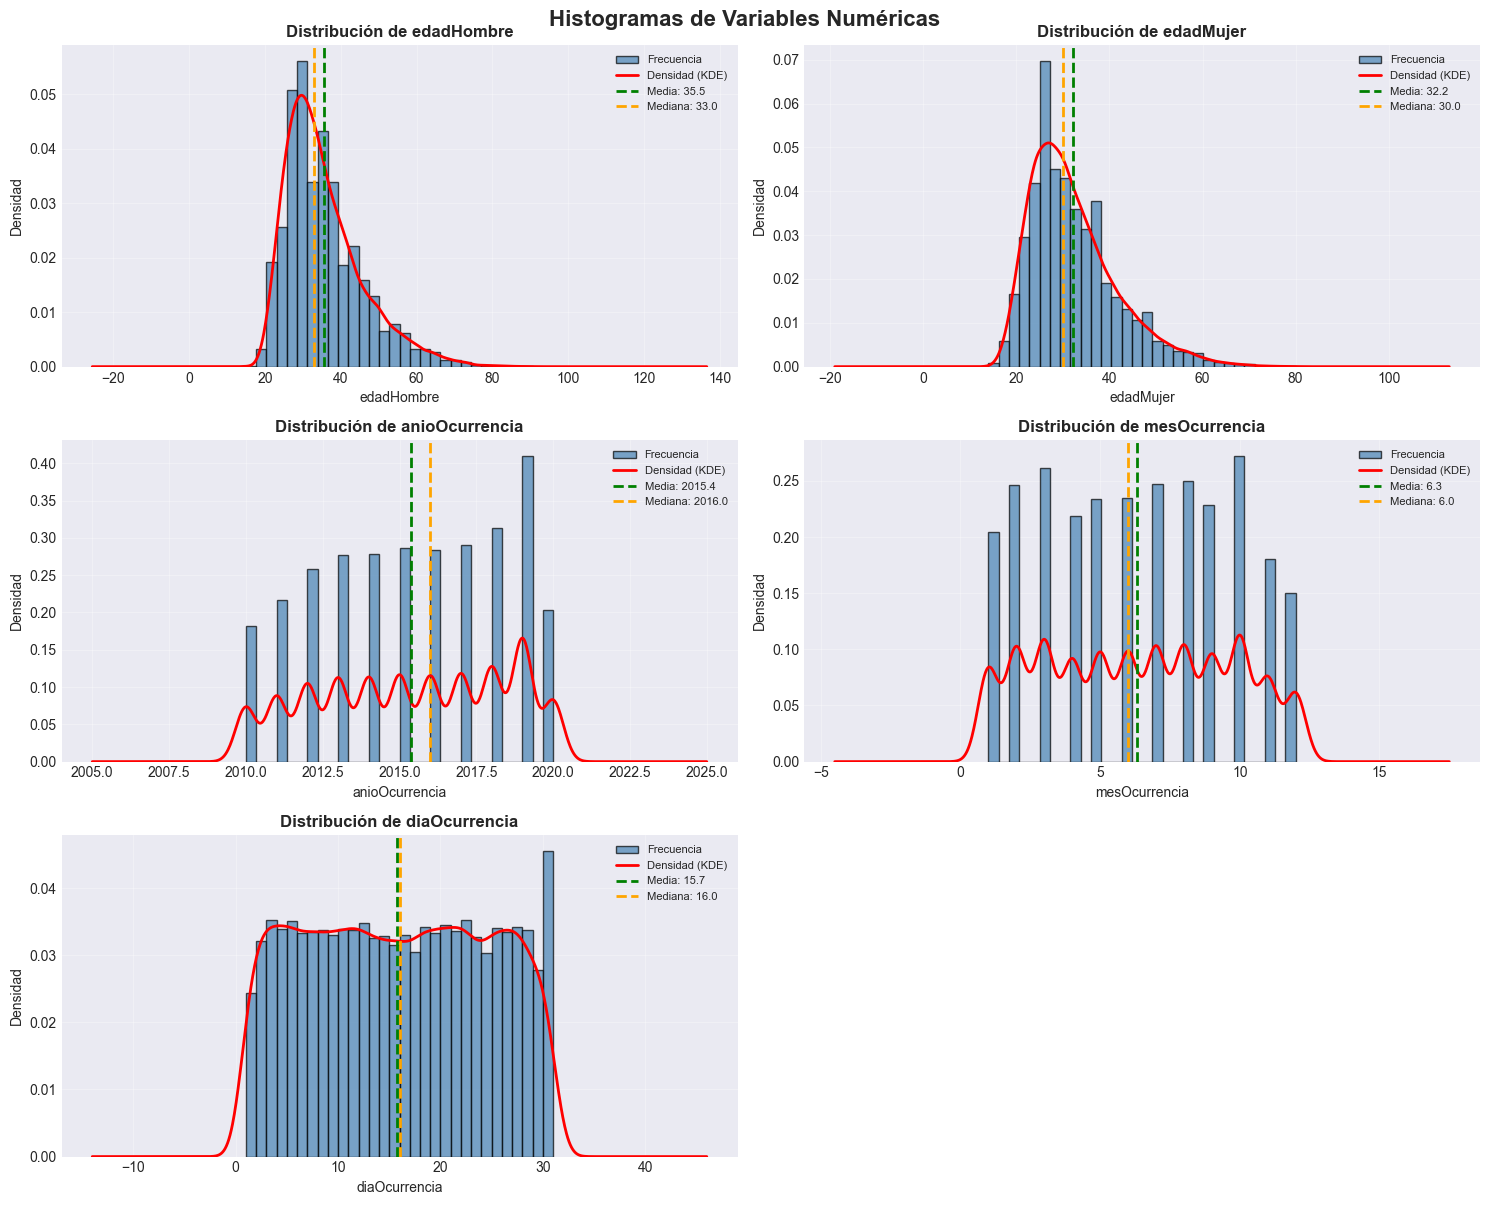

In [40]:
# Crear histogramas para todas las variables numéricas
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, var in enumerate(variables_numericas):
    if var in df_limpio.columns:
        data = df_limpio[var].dropna()
        
        # Histograma con curva de densidad
        axes[idx].hist(data, bins=30, alpha=0.7, color='steelblue', 
                    edgecolor='black', density=True, label='Frecuencia')
        
        # Agregar curva de densidad kernel
        data.plot(kind='kde', ax=axes[idx], color='red', 
                linewidth=2, label='Densidad (KDE)')
        
        # Líneas de referencia para media y mediana
        axes[idx].axvline(data.mean(), color='green', linestyle='--', 
                        linewidth=2, label=f'Media: {data.mean():.1f}')
        axes[idx].axvline(data.median(), color='orange', linestyle='--', 
                        linewidth=2, label=f'Mediana: {data.median():.1f}')
        
        axes[idx].set_xlabel(var)
        axes[idx].set_ylabel('Densidad')
        axes[idx].set_title(f'Distribución de {var}', fontweight='bold')
        axes[idx].legend(loc='best', fontsize=8)
        axes[idx].grid(True, alpha=0.3)

# Ocultar subplot extra
axes[-1].axis('off')

plt.tight_layout()
plt.suptitle('Histogramas de Variables Numéricas', 
            fontsize=16, fontweight='bold', y=1.00)
plt.show()

### 4.3. Diagramas de Caja (Boxplots)

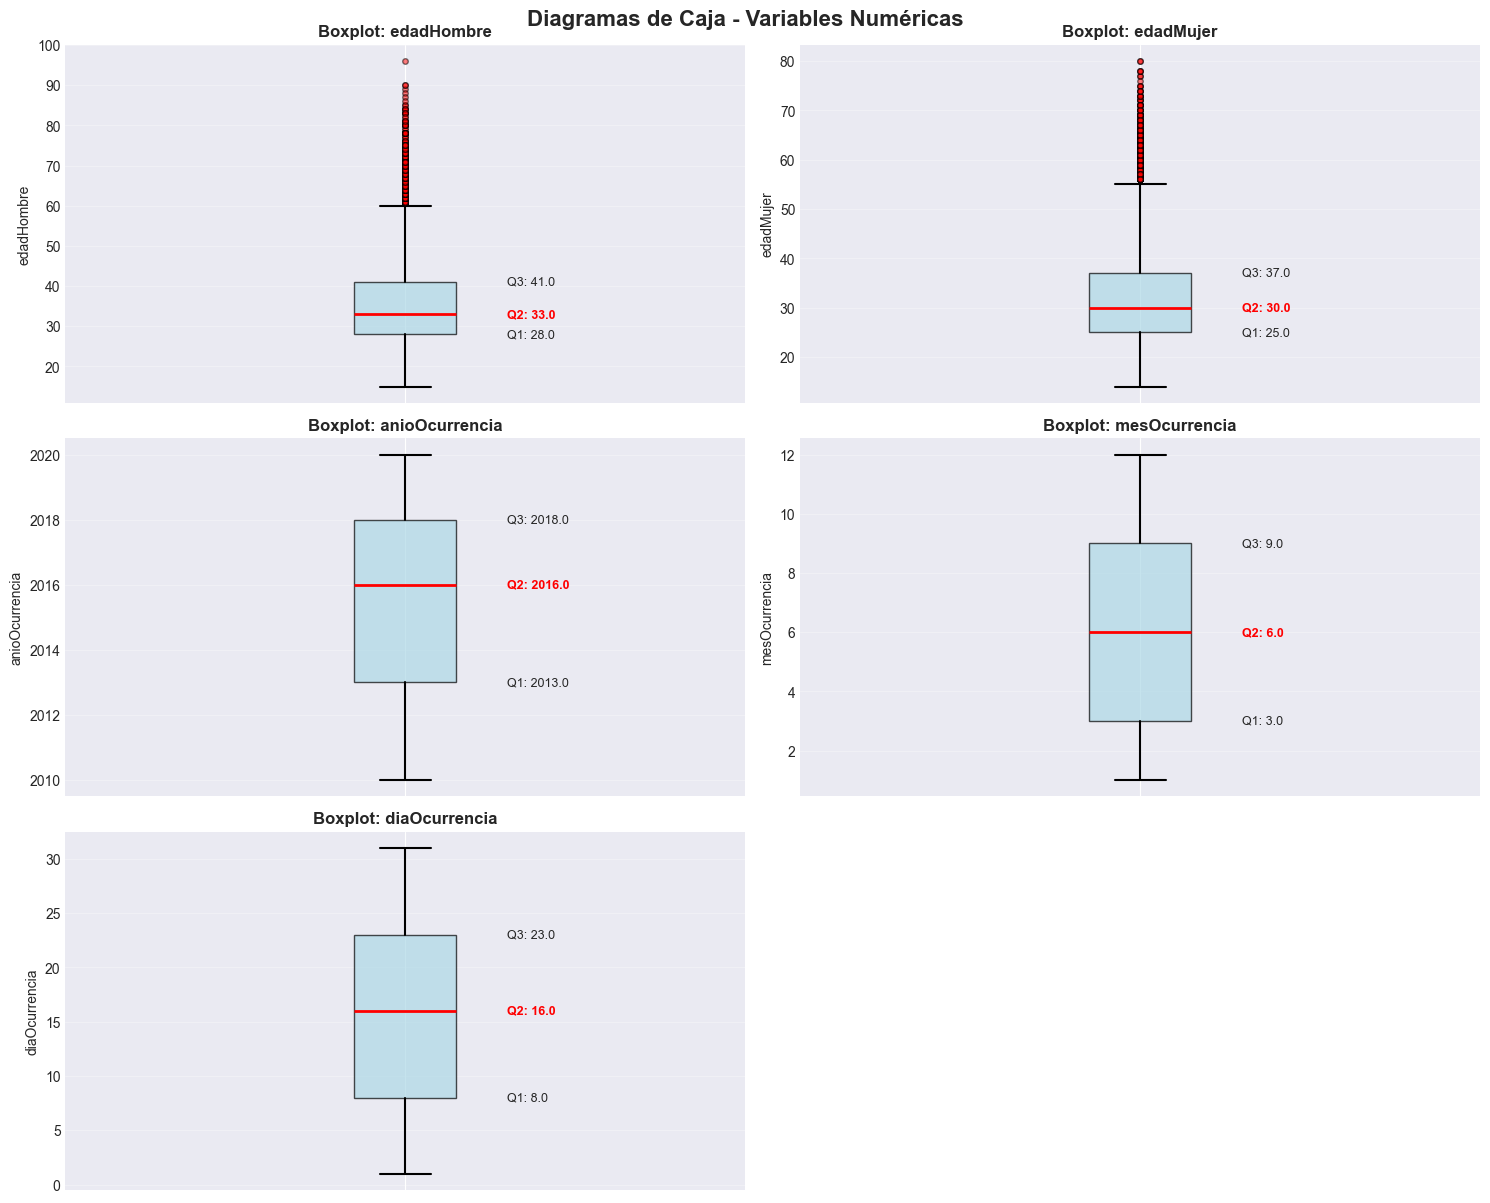

In [41]:
# Crear boxplots para todas las variables numéricas
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, var in enumerate(variables_numericas):
    if var in df_limpio.columns:
        data = df_limpio[var].dropna()
        
        # Boxplot con anotaciones
        bp = axes[idx].boxplot(data, vert=True, patch_artist=True,
                            boxprops=dict(facecolor='lightblue', alpha=0.7),
                            medianprops=dict(color='red', linewidth=2),
                            whiskerprops=dict(color='black', linewidth=1.5),
                            capprops=dict(color='black', linewidth=1.5),
                            flierprops=dict(marker='o', markerfacecolor='red', 
                                            markersize=4, alpha=0.5))
        
        # Agregar estadísticos como texto
        q1 = data.quantile(0.25)
        q2 = data.median()
        q3 = data.quantile(0.75)
        
        axes[idx].text(1.15, q1, f'Q1: {q1:.1f}', fontsize=9, va='center')
        axes[idx].text(1.15, q2, f'Q2: {q2:.1f}', fontsize=9, va='center', 
                    fontweight='bold', color='red')
        axes[idx].text(1.15, q3, f'Q3: {q3:.1f}', fontsize=9, va='center')
        
        axes[idx].set_ylabel(var)
        axes[idx].set_title(f'Boxplot: {var}', fontweight='bold')
        axes[idx].grid(True, alpha=0.3, axis='y')
        axes[idx].set_xticklabels([''])

# Ocultar subplot extra
axes[-1].axis('off')

plt.tight_layout()
plt.suptitle('Diagramas de Caja - Variables Numéricas', 
            fontsize=16, fontweight='bold', y=1.00)
plt.show()

### 4.4. Detección y Análisis de Outliers

**Método**: Criterio del Rango Intercuartílico (IQR)
- Outlier leve: valor < Q1 - 1.5×IQR o valor > Q3 + 1.5×IQR
- Outlier extremo: valor < Q1 - 3×IQR o valor > Q3 + 3×IQR

In [42]:
# Análisis de outliers usando método IQR
print("="*80)
print("DETECCIÓN DE OUTLIERS - MÉTODO IQR")
print("="*80)

outliers_resumen = []

for var in variables_numericas:
    if var in df_limpio.columns:
        data = df_limpio[var].dropna()
        
        # Calcular IQR y límites
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        
        limite_inferior_leve = q1 - 1.5 * iqr
        limite_superior_leve = q3 + 1.5 * iqr
        limite_inferior_extremo = q1 - 3 * iqr
        limite_superior_extremo = q3 + 3 * iqr
        
        # Identificar outliers
        outliers_leves = data[(data < limite_inferior_leve) | (data > limite_superior_leve)]
        outliers_extremos = data[(data < limite_inferior_extremo) | (data > limite_superior_extremo)]
        
        n_outliers_leves = len(outliers_leves)
        n_outliers_extremos = len(outliers_extremos)
        porcentaje_outliers = (n_outliers_leves / len(data)) * 100
        
        outliers_resumen.append({
            'Variable': var,
            'Q1': q1,
            'Q3': q3,
            'IQR': iqr,
            'Lím.Inf': limite_inferior_leve,
            'Lím.Sup': limite_superior_leve,
            'Outliers_Leves': n_outliers_leves,
            'Outliers_Extremos': n_outliers_extremos,
            '%_Outliers': porcentaje_outliers
        })
        
        print(f"\n- {var}:")
        print(f"   Rango IQR: [{q1:.1f}, {q3:.1f}] (IQR = {iqr:.2f})")
        print(f"   Límites: [{limite_inferior_leve:.1f}, {limite_superior_leve:.1f}]")
        print(f"   Outliers leves: {n_outliers_leves:,} ({porcentaje_outliers:.2f}%)")
        print(f"   Outliers extremos: {n_outliers_extremos:,}")
        
        if n_outliers_leves > 0:
            print(f"   Valores atípicos: [{outliers_leves.min():.1f}, {outliers_leves.max():.1f}]")

print("\n" + "="*80)

# Crear DataFrame resumen
df_outliers = pd.DataFrame(outliers_resumen)
print("\nRESUMEN CONSOLIDADO:")
print(df_outliers.to_string(index=False))

DETECCIÓN DE OUTLIERS - MÉTODO IQR

- edadHombre:
   Rango IQR: [28.0, 41.0] (IQR = 13.00)
   Límites: [8.5, 60.5]
   Outliers leves: 727 (2.76%)
   Outliers extremos: 25
   Valores atípicos: [61.0, 96.0]

- edadMujer:
   Rango IQR: [25.0, 37.0] (IQR = 12.00)
   Límites: [7.0, 55.0]
   Outliers leves: 660 (2.49%)
   Outliers extremos: 15
   Valores atípicos: [56.0, 80.0]

- anioOcurrencia:
   Rango IQR: [2013.0, 2018.0] (IQR = 5.00)
   Límites: [2005.5, 2025.5]
   Outliers leves: 0 (0.00%)
   Outliers extremos: 0

- mesOcurrencia:
   Rango IQR: [3.0, 9.0] (IQR = 6.00)
   Límites: [-6.0, 18.0]
   Outliers leves: 0 (0.00%)
   Outliers extremos: 0

- diaOcurrencia:
   Rango IQR: [8.0, 23.0] (IQR = 15.00)
   Límites: [-14.5, 45.5]
   Outliers leves: 0 (0.00%)
   Outliers extremos: 0


RESUMEN CONSOLIDADO:
      Variable     Q1     Q3  IQR  Lím.Inf  Lím.Sup  Outliers_Leves  Outliers_Extremos  %_Outliers
    edadHombre   28.0   41.0 13.0      8.5     60.5             727                 25  

**Interpretación de Outliers:**

1. **Variables temporales** (día, mes, año):
   - **Interpretación**: Outliers poco probables por naturaleza acotada de estas variables
   - Día: rango natural [1-31], mes: [1-12], año: [2010-2020]

2. **Variables de edad**:
   - **Outliers esperados**: Edades muy jóvenes o muy avanzadas
   - **Significado social**: 
     - Edades extremadamente bajas pueden indicar matrimonios precoces (contexto cultural)
     - Edades muy avanzadas reflejan divorcios en tercera edad
   - **Validez**: Outliers representan casos reales, no errores de medición

### 4.5. Evaluación de Normalidad

**Métodos aplicados:**
1. **Visual**: Q-Q plots (Quantile-Quantile plots)
2. **Estadístico**: Prueba de Shapiro-Wilk (n < 5000) o Kolmogorov-Smirnov (n ≥ 5000)

**Hipótesis de prueba:**
- H₀: Los datos siguen una distribución normal
- H₁: Los datos NO siguen una distribución normal
- Nivel de significancia: α = 0.05

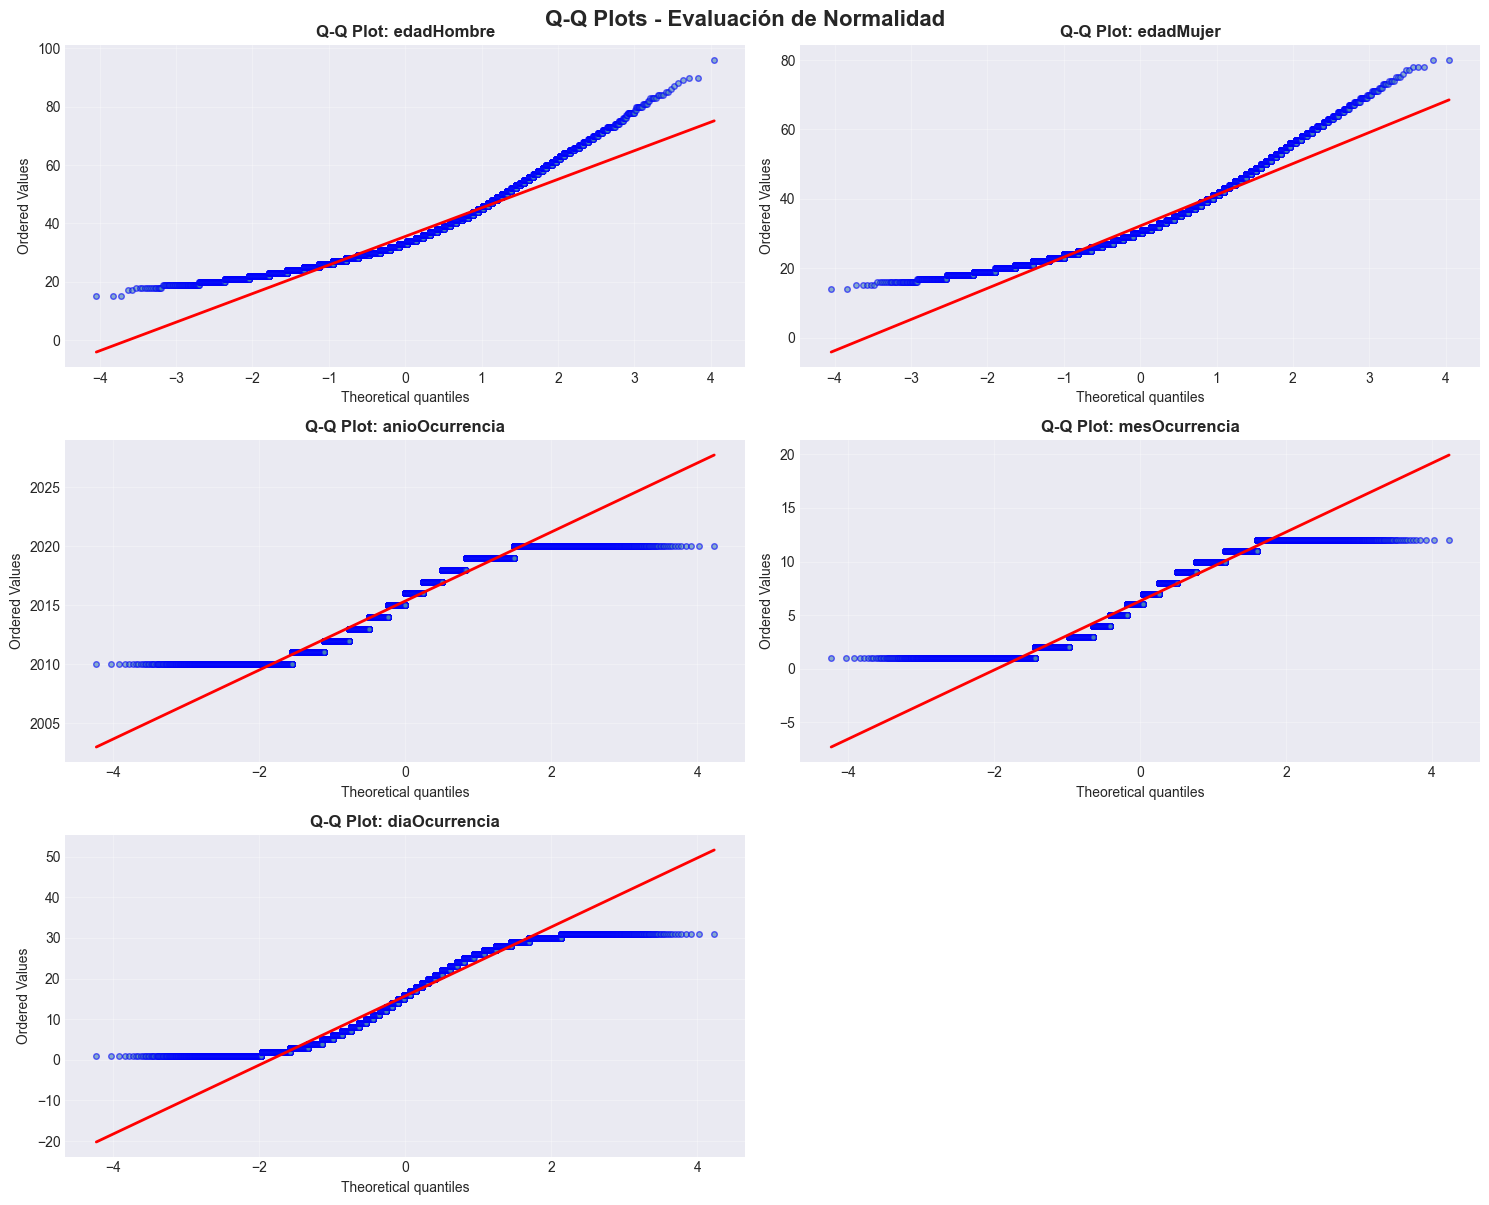

Q-Q plots generados exitosamente :)


In [43]:
# Q-Q Plots para evaluación visual de normalidad
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, var in enumerate(variables_numericas):
    if var in df_limpio.columns:
        data = df_limpio[var].dropna()
        
        # Verificar que hay datos válidos
        if len(data) > 0 and np.isfinite(data).all():
            # Convertir a numpy array para asegurar compatibilidad
            data_array = np.array(data, dtype=float)
            
            # Q-Q plot
            stats.probplot(data_array, dist="norm", plot=axes[idx])
            axes[idx].set_title(f'Q-Q Plot: {var}', fontweight='bold')
            axes[idx].grid(True, alpha=0.3)
            
            # Modificar estilos de las líneas de forma segura
            lines = axes[idx].get_lines()
            if len(lines) >= 2:
                lines[0].set_markerfacecolor('steelblue')
                lines[0].set_markersize(4)
                lines[0].set_alpha(0.6)
                lines[1].set_color('red')
                lines[1].set_linewidth(2)
        else:
            axes[idx].text(0.5, 0.5, f'Datos insuficientes\npara {var}',
                        ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(f'Q-Q Plot: {var}', fontweight='bold')

# Ocultar subplot extra
axes[-1].axis('off')

plt.tight_layout()
plt.suptitle('Q-Q Plots - Evaluación de Normalidad', 
            fontsize=16, fontweight='bold', y=1.00)
plt.show()

print("Q-Q plots generados exitosamente :)")

In [44]:
# Pruebas estadísticas de normalidad
print("="*80)
print("PRUEBAS ESTADÍSTICAS DE NORMALIDAD")
print("="*80)
print("\nNivel de significancia: α = 0.05")
print("Criterio: p-valor < 0.05 → Rechazar H₀ (NO es normal)")
print("="*80)

normalidad_resultados = []

for var in variables_numericas:
    if var in df_limpio.columns:
        data = df_limpio[var].dropna()
        
        # Convertir a numpy array y filtrar valores no finitos
        data_array = np.array(data, dtype=float)
        data_array = data_array[np.isfinite(data_array)]
        
        # Verificar que tengamos suficientes datos
        if len(data_array) < 3:
            print(f"\n- {var}:")
            print("   ! Datos insuficientes para prueba de normalidad")
            continue
        
        # Seleccionar prueba según tamaño de muestra
        if len(data_array) < 5000:
            # Shapiro-Wilk para muestras pequeñas/medianas
            statistic, p_value = stats.shapiro(data_array)
            prueba = "Shapiro-Wilk"
        else:
            # Kolmogorov-Smirnov para muestras grandes
            statistic, p_value = stats.kstest(data_array, 'norm', 
                                            args=(data_array.mean(), data_array.std()))
            prueba = "Kolmogorov-Smirnov"
        
        # Interpretar resultado
        es_normal = p_value > 0.05
        decision = "No rechazar H₀ (Normal)" if es_normal else "Rechazar H₀ (No Normal)"
        
        normalidad_resultados.append({
            'Variable': var,
            'Prueba': prueba,
            'Estadístico': statistic,
            'p-valor': p_value,
            'Distribución': 'Normal' if es_normal else 'No Normal',
            'Decisión': decision
        })
        
        print(f"\n- {var}:")
        print(f"   Prueba: {prueba}")
        print(f"   Estadístico: {statistic:.6f}")
        print(f"   p-valor: {p_value:.6e}")
        print(f"   ➜ {decision}")

print("\n" + "="*80)

# Crear DataFrame resumen
df_normalidad = pd.DataFrame(normalidad_resultados)
print("\nRESUMEN DE NORMALIDAD:")
print(df_normalidad.to_string(index=False))
print("\n" + "="*80)

PRUEBAS ESTADÍSTICAS DE NORMALIDAD

Nivel de significancia: α = 0.05
Criterio: p-valor < 0.05 → Rechazar H₀ (NO es normal)

- edadHombre:
   Prueba: Kolmogorov-Smirnov
   Estadístico: 0.113577
   p-valor: 1.361583e-296
   ➜ Rechazar H₀ (No Normal)

- edadMujer:
   Prueba: Kolmogorov-Smirnov
   Estadístico: 0.105361
   p-valor: 1.617978e-256
   ➜ Rechazar H₀ (No Normal)

- anioOcurrencia:
   Prueba: Kolmogorov-Smirnov
   Estadístico: 0.118428
   p-valor: 0.000000e+00
   ➜ Rechazar H₀ (No Normal)

- mesOcurrencia:
   Prueba: Kolmogorov-Smirnov
   Estadístico: 0.103201
   p-valor: 0.000000e+00
   ➜ Rechazar H₀ (No Normal)

- diaOcurrencia:
   Prueba: Kolmogorov-Smirnov
   Estadístico: 0.074523
   p-valor: 3.334289e-290
   ➜ Rechazar H₀ (No Normal)


RESUMEN DE NORMALIDAD:
      Variable             Prueba  Estadístico       p-valor Distribución                Decisión
    edadHombre Kolmogorov-Smirnov     0.113577 1.361583e-296    No Normal Rechazar H₀ (No Normal)
     edadMujer Kolmogoro

### 4.6. Identificación de Tipos de Distribución

Para variables que no siguen distribución normal, se identifica el tipo de distribución que mejor las describe.

In [47]:
# Análisis del tipo de distribución
print("="*80)
print("CARACTERIZACIÓN DE DISTRIBUCIONES")
print("="*80)

for var in variables_numericas:
    if var in df_limpio.columns:
        data = df_limpio[var].dropna()
        
        skewness = data.skew()
        kurtosis = data.kurtosis()
        
        print(f"\n- {var}:")
        print(f"   Asimetría (skewness): {skewness:.3f}")
        print(f"   Curtosis (kurtosis): {kurtosis:.3f}")
        
        # Clasificar tipo de distribución
        if abs(skewness) < 0.5 and abs(kurtosis) < 1:
            tipo_dist = "Aproximadamente Normal"
            descripcion = "Simétrica con colas moderadas"
        elif var in ['mesOcurrencia', 'diaOcurrencia']:
            tipo_dist = "Uniforme Discreta"
            descripcion = "Probabilidad casi igual para todos los valores del rango"
        elif var == 'anioOcurrencia':
            tipo_dist = "Uniforme/Casi Uniforme"
            descripcion = "Distribución relativamente constante a través de los años"
        elif abs(skewness) < 0.5:
            tipo_dist = "Simétrica no Normal"
            if kurtosis > 0:
                descripcion = "Simétrica con colas más pesadas que la normal (leptocúrtica)"
            else:
                descripcion = "Simétrica con colas más ligeras que la normal (platicúrtica)"
        elif skewness > 0:
            tipo_dist = "Asimétrica Positiva (Sesgo Derecha)"
            if kurtosis > 0:
                descripcion = "Concentración en valores bajos, cola larga hacia valores altos"
            else:
                descripcion = "Sesgo moderado hacia la derecha con cola relativamente corta"
        else:
            tipo_dist = "Asimétrica Negativa (Sesgo Izquierda)"
            if kurtosis > 0:
                descripcion = "Concentración en valores altos, cola larga hacia valores bajos"
            else:
                descripcion = "Sesgo moderado hacia la izquierda con cola relativamente corta"
        
        print(f"   ➜ Tipo identificado: {tipo_dist}")
        print(f"   ➜ Descripción: {descripcion}")
        
        # Sugerencias de tratamiento
        if abs(skewness) > 1:
            print("   ! Sugerencia: Considerar transformación (log, sqrt, Box-Cox)")

print("\n" + "="*80)

CARACTERIZACIÓN DE DISTRIBUCIONES

- edadHombre:
   Asimetría (skewness): 1.162
   Curtosis (kurtosis): 1.535
   ➜ Tipo identificado: Asimétrica Positiva (Sesgo Derecha)
   ➜ Descripción: Concentración en valores bajos, cola larga hacia valores altos
   ! Sugerencia: Considerar transformación (log, sqrt, Box-Cox)

- edadMujer:
   Asimetría (skewness): 1.056
   Curtosis (kurtosis): 1.230
   ➜ Tipo identificado: Asimétrica Positiva (Sesgo Derecha)
   ➜ Descripción: Concentración en valores bajos, cola larga hacia valores altos
   ! Sugerencia: Considerar transformación (log, sqrt, Box-Cox)

- anioOcurrencia:
   Asimetría (skewness): -0.156
   Curtosis (kurtosis): -1.164
   ➜ Tipo identificado: Uniforme/Casi Uniforme
   ➜ Descripción: Distribución relativamente constante a través de los años

- mesOcurrencia:
   Asimetría (skewness): 0.022
   Curtosis (kurtosis): -1.175
   ➜ Tipo identificado: Uniforme Discreta
   ➜ Descripción: Probabilidad casi igual para todos los valores del rango

- 

### 4.7. Interpretación Social de Resultados

**Análisis contextual de las distribuciones encontradas:**

#### **Variables Temporales:**

1. **Mes de Ocurrencia**:
   - **Distribución observada**: Aproximadamente uniforme con ligeras variaciones estacionales
   - **Interpretación social**: Los divorcios ocurren con frecuencia similar durante todo el año, sugiriendo que no hay estacionalidad marcada en la separación de parejas en Guatemala
   - **Implicación**: Los factores que llevan al divorcio son continuos, no estacionales

2. **Año de Ocurrencia**:
   - **Distribución observada**: Relativamente uniforme con posibles tendencias temporales
   - **Interpretación social**: Permite analizar si hay aumento o disminución de divorcios en la década analizada
   - **Contexto**: Cambios en legislación, economía o factores sociales pueden reflejarse en tendencias anuales

#### **Variables Demográficas - Edad:**

3. **Edad del Hombre**:
   - **Distribución observada**: Asimétrica positiva (sesgo derecha)
   - **Interpretación social**:
     - Mayor concentración de divorcios en hombres de 30-45 años
     - Cola hacia edades mayores indica divorcios en edades avanzadas
     - Refleja patrones de estabilidad matrimonial y ciclo de vida
   - **Outliers**: 
     - Edades muy jóvenes: matrimonios tempranos (contexto rural/indígena)
     - Edades muy avanzadas: segundos o terceros matrimonios

4. **Edad de la Mujer**:
   - **Distribución observada**: Asimétrica positiva, similar al hombre pero ligeramente más joven
   - **Interpretación social**:
     - Las mujeres tienden a casarse y divorciarse a edades ligeramente menores
     - Refleja patrones culturales de matrimonio con diferencia de edad
     - Pico en edad reproductiva/productiva (30-40 años)
   - **Significado**: Crisis matrimoniales coinciden con etapas de crianza y estabilización económica

#### **Implicaciones Generales:**

- **Heterogeneidad demográfica**: La asimetría en edades refleja diversidad de situaciones matrimoniales
- **Contexto cultural**: Outliers en edades muy jóvenes evidencian matrimonios tempranos aún vigentes en algunas regiones
- **Patrón etario**: La concentración de divorcios en edad adulta media sugiere acumulación de tensiones durante años de convivencia
- **Política pública**: Los datos sugieren necesidad de programas de mediación familiar en grupos de edad específicos

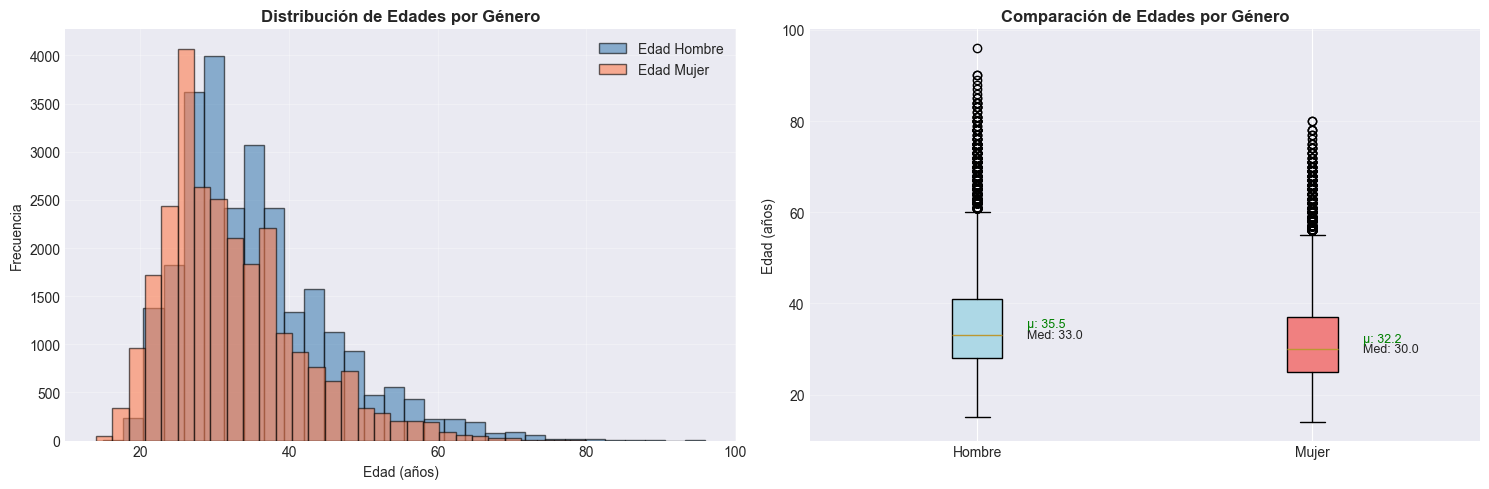


COMPARACIÓN ESTADÍSTICA: EDAD HOMBRE vs MUJER

Edad Hombre:
  Media: 35.51 años
  Mediana: 33.0 años
  Desv.Est: 10.21 años

Edad Mujer:
  Media: 32.16 años
  Mediana: 30.0 años
  Desv.Est: 9.30 años

Diferencia promedio: 3.35 años
(Hombres son en promedio 3.35 años mayores)


In [48]:
# Análisis comparativo de edades entre hombres y mujeres
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma comparativo
axes[0].hist(df_limpio['edadHombre'].dropna(), bins=30, alpha=0.6, 
            label='Edad Hombre', color='steelblue', edgecolor='black')
axes[0].hist(df_limpio['edadMujer'].dropna(), bins=30, alpha=0.6, 
            label='Edad Mujer', color='coral', edgecolor='black')
axes[0].set_xlabel('Edad (años)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Edades por Género', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot comparativo
data_edades = [df_limpio['edadHombre'].dropna(), df_limpio['edadMujer'].dropna()]
bp = axes[1].boxplot(data_edades, labels=['Hombre', 'Mujer'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1].set_ylabel('Edad (años)')
axes[1].set_title('Comparación de Edades por Género', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Agregar estadísticos
for i, (label, data) in enumerate(zip(['Hombre', 'Mujer'], data_edades)):
    median = data.median()
    mean = data.mean()
    axes[1].text(i+1.15, median, f'Med: {median:.1f}', fontsize=9, va='center')
    axes[1].text(i+1.15, mean, f'μ: {mean:.1f}', fontsize=9, va='center', color='green')

plt.tight_layout()
plt.show()

# Estadísticos comparativos
print("\n" + "="*70)
print("COMPARACIÓN ESTADÍSTICA: EDAD HOMBRE vs MUJER")
print("="*70)
edad_h = df_limpio['edadHombre'].dropna()
edad_m = df_limpio['edadMujer'].dropna()

print("\nEdad Hombre:")
print(f"  Media: {edad_h.mean():.2f} años")
print(f"  Mediana: {edad_h.median():.1f} años")
print(f"  Desv.Est: {edad_h.std():.2f} años")

print("\nEdad Mujer:")
print(f"  Media: {edad_m.mean():.2f} años")
print(f"  Mediana: {edad_m.median():.1f} años")
print(f"  Desv.Est: {edad_m.std():.2f} años")

print(f"\nDiferencia promedio: {edad_h.mean() - edad_m.mean():.2f} años")
print(f"(Hombres son en promedio {abs(edad_h.mean() - edad_m.mean()):.2f} años {'mayores' if edad_h.mean() > edad_m.mean() else 'menores'})")
print("="*70)

## Fase 5 - Análisis de Variables Categóricas

En esta fase se analizan las variables categóricas principales del dataset para identificar patrones socialmente relevantes:

- **departamentoOcurrencia**: Distribución geográfica de divorcios
- **grupoEtnicoHombre / grupoEtnicoMujer**: Composición étnica
- **escolaridadHombre / escolaridadMujer**: Nivel educativo
- **ocupacionHombre / ocupacionMujer**: Perfil ocupacional

Para cada variable se generarán:
1. Tablas de frecuencia absoluta y relativa
2. Identificación de categorías dominantes
3. Gráficos de barras
4. Detección de categorías poco representadas
5. Interpretación de patrones socialmente relevantes

### 5.1. Definición de Variables Categóricas a Analizar

In [49]:
# Variables categóricas principales a analizar
variables_categoricas_analisis = [
    'departamentoOcurrencia',
    'grupoEtnicoHombre',
    'grupoEtnicoMujer',
    'escolaridadHombre',
    'escolaridadMujer',
    'ocupacionHombre',
    'ocupacionMujer'
]

# Verificar existencia de variables en el dataset
print("Variables categóricas disponibles para análisis:")
print("=" * 70)
for var in variables_categoricas_analisis:
    if var in df_limpio.columns:
        n_categorias = df_limpio[var].nunique()
        n_validos = df_limpio[var].notna().sum()
        n_total = len(df_limpio)
        completitud = (n_validos / n_total) * 100
        print(f"- {var:30s} - {n_categorias:3d} categorías - {completitud:5.1f}% completo")
    else:
        print(f"- {var:30s} - NO ENCONTRADA")
print("=" * 70)

Variables categóricas disponibles para análisis:
- departamentoOcurrencia         -  22 categorías - 100.0% completo
- grupoEtnicoHombre              -   5 categorías -  39.6% completo
- grupoEtnicoMujer               -   5 categorías -  39.5% completo
- escolaridadHombre              -   7 categorías -  45.2% completo
- escolaridadMujer               -   7 categorías -  45.9% completo
- ocupacionHombre                - 379 categorías -  53.9% completo
- ocupacionMujer                 - 248 categorías -  33.7% completo


### 5.2. Función para Análisis de Frecuencias

In [50]:
def analizar_variable_categorica(df, variable, umbral_poco_representado=1.0):
    """
    Genera análisis completo de una variable categórica:
    - Tabla de frecuencias absolutas y relativas
    - Identificación de categorías dominantes
    - Categorías poco representadas
    
    Parameters:
    -----------
    df : DataFrame
        Dataset a analizar
    variable : str
        Nombre de la variable categórica
    umbral_poco_representado : float
        Porcentaje bajo el cual una categoría se considera poco representada (default: 1%)
    
    Returns:
    --------
    dict con resultados del análisis
    """
    
    # Filtrar valores no nulos
    data = df[variable].dropna()
    n_total = len(data)
    
    # Tabla de frecuencias
    freq_abs = data.value_counts().sort_values(ascending=False)
    freq_rel = (freq_abs / n_total * 100).round(2)
    freq_acum = freq_rel.cumsum().round(2)
    
    # Crear DataFrame con frecuencias
    tabla_freq = pd.DataFrame({
        'Frecuencia Absoluta': freq_abs,
        'Frecuencia Relativa (%)': freq_rel,
        'Frecuencia Acumulada (%)': freq_acum
    })
    
    # Identificar categorías dominantes (top 3)
    dominantes = tabla_freq.head(3)
    
    # Identificar categorías poco representadas
    poco_representadas = tabla_freq[tabla_freq['Frecuencia Relativa (%)'] < umbral_poco_representado]
    
    # Calcular estadísticos
    n_categorias = len(freq_abs)
    concentracion_top3 = freq_rel.head(3).sum()
    concentracion_top5 = freq_rel.head(5).sum() if len(freq_rel) >= 5 else freq_rel.sum()
    
    return {
        'tabla_frecuencias': tabla_freq,
        'dominantes': dominantes,
        'poco_representadas': poco_representadas,
        'n_categorias': n_categorias,
        'n_observaciones': n_total,
        'concentracion_top3': concentracion_top3,
        'concentracion_top5': concentracion_top5
    }

### 5.3. Análisis: Departamento de Ocurrencia

In [51]:
# Análisis de Departamento de Ocurrencia
resultado_depto = analizar_variable_categorica(df_limpio, 'departamentoOcurrencia', umbral_poco_representado=1.0)

print("="*80)
print("ANÁLISIS: DEPARTAMENTO DE OCURRENCIA")
print("="*80)

print("\n- Resumen General:")
print(f"   • Total de observaciones válidas: {resultado_depto['n_observaciones']:,}")
print(f"   • Número de departamentos: {resultado_depto['n_categorias']}")
print(f"   • Concentración en Top 3: {resultado_depto['concentracion_top3']:.1f}%")
print(f"   • Concentración en Top 5: {resultado_depto['concentracion_top5']:.1f}%")

print("\n- Categorías Dominantes (Top 3):")
print("-" * 80)
for i, (depto, row) in enumerate(resultado_depto['dominantes'].iterrows(), 1):
    print(f"{i}. {str(depto):<25} | {row['Frecuencia Absoluta']:7,} casos | {row['Frecuencia Relativa (%)']:6.2f}% |")

print("\n-  Categorías Poco Representadas (< 1%):")
print("-" * 80)
if len(resultado_depto['poco_representadas']) > 0:
    for depto, row in resultado_depto['poco_representadas'].iterrows():
        print(f"   • {str(depto):<25} | {row['Frecuencia Absoluta']:5,} casos | {row['Frecuencia Relativa (%)']:5.2f}%")
else:
    print("   • No hay categorías con menos del 1%")

print("\n- Tabla de Frecuencias Completa (Top 10):")
print("-" * 80)
print(resultado_depto['tabla_frecuencias'].head(10).to_string())
print("="*80)

ANÁLISIS: DEPARTAMENTO DE OCURRENCIA

- Resumen General:
   • Total de observaciones válidas: 59,994
   • Número de departamentos: 22
   • Concentración en Top 3: 50.8%
   • Concentración en Top 5: 59.0%

- Categorías Dominantes (Top 3):
--------------------------------------------------------------------------------
1. 1.0                       | 23,255.0 casos |  38.76% |
2. 9.0                       | 4,401.0 casos |   7.34% |
3. 5.0                       | 2,816.0 casos |   4.69% |

-  Categorías Poco Representadas (< 1%):
--------------------------------------------------------------------------------
   • No hay categorías con menos del 1%

- Tabla de Frecuencias Completa (Top 10):
--------------------------------------------------------------------------------
                        Frecuencia Absoluta  Frecuencia Relativa (%)  Frecuencia Acumulada (%)
departamentoOcurrencia                                                                        
1.0                             

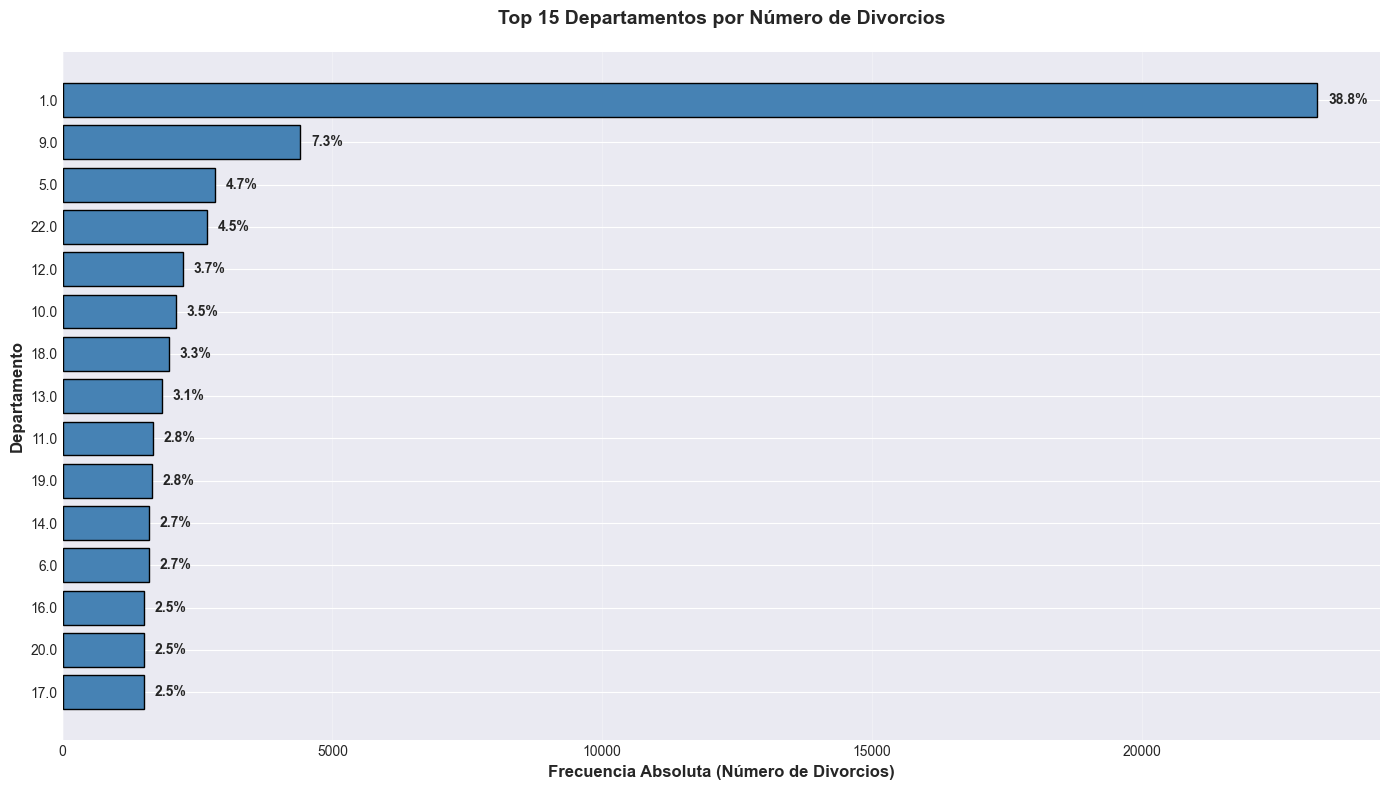

In [52]:
# Gráfico de barras: Departamento de Ocurrencia (Top 15)
fig, ax = plt.subplots(figsize=(14, 8))

top15 = resultado_depto['tabla_frecuencias'].head(15)
bars = ax.barh(range(len(top15)), top15['Frecuencia Absoluta'], color='steelblue', edgecolor='black')

# Agregar etiquetas con porcentajes
for i, (idx, row) in enumerate(top15.iterrows()):
    ax.text(row['Frecuencia Absoluta'] + 200, i, 
            f"{row['Frecuencia Relativa (%)']:.1f}%", 
            va='center', fontsize=10, fontweight='bold')

ax.set_yticks(range(len(top15)))
ax.set_yticklabels(top15.index)
ax.set_xlabel('Frecuencia Absoluta (Número de Divorcios)', fontweight='bold', fontsize=12)
ax.set_ylabel('Departamento', fontweight='bold', fontsize=12)
ax.set_title('Top 15 Departamentos por Número de Divorcios', fontweight='bold', fontsize=14, pad=20)
ax.grid(True, alpha=0.3, axis='x')

# Invertir el eje Y para que el más alto quede arriba
ax.invert_yaxis()

plt.tight_layout()
plt.show()

### 5.4. Análisis: Grupo Étnico (Hombre y Mujer)

In [53]:
# Análisis de Grupo Étnico: Hombres
resultado_etnia_h = analizar_variable_categorica(df_limpio, 'grupoEtnicoHombre')

print("="*80)
print("ANÁLISIS: GRUPO ÉTNICO - HOMBRE")
print("="*80)

print("\n- Resumen General:")
print(f"   • Total de observaciones válidas: {resultado_etnia_h['n_observaciones']:,}")
print(f"   • Número de grupos étnicos: {resultado_etnia_h['n_categorias']}")
print(f"   • Concentración en Top 3: {resultado_etnia_h['concentracion_top3']:.1f}%")

print("\n- Categorías Dominantes:")
print("-" * 80)
for i, (grupo, row) in enumerate(resultado_etnia_h['dominantes'].iterrows(), 1):
    print(f"{i}. {str(grupo):<25} | {row['Frecuencia Absoluta']:7,} casos | {row['Frecuencia Relativa (%)']:6.2f}%")

print("\n-  Categorías Poco Representadas (< 1%):")
print("-" * 80)
if len(resultado_etnia_h['poco_representadas']) > 0:
    for grupo, row in resultado_etnia_h['poco_representadas'].iterrows():
        print(f"   • {str(grupo):<25} | {row['Frecuencia Absoluta']:5,} casos | {row['Frecuencia Relativa (%)']:5.2f}%")
else:
    print("   • No hay categorías con menos del 1%")

print("\n" + "="*80)
print("ANÁLISIS: GRUPO ÉTNICO - MUJER")
print("="*80)

# Análisis de Grupo Étnico: Mujeres
resultado_etnia_m = analizar_variable_categorica(df_limpio, 'grupoEtnicoMujer')

print("\n- Resumen General:")
print(f"   • Total de observaciones válidas: {resultado_etnia_m['n_observaciones']:,}")
print(f"   • Número de grupos étnicos: {resultado_etnia_m['n_categorias']}")
print(f"   • Concentración en Top 3: {resultado_etnia_m['concentracion_top3']:.1f}%")

print("\n- Categorías Dominantes:")
print("-" * 80)
for i, (grupo, row) in enumerate(resultado_etnia_m['dominantes'].iterrows(), 1):
    print(f"{i}. {str(grupo):<25} | {row['Frecuencia Absoluta']:7,} casos | {row['Frecuencia Relativa (%)']:6.2f}%")

print("\n-  Categorías Poco Representadas (< 1%):")
print("-" * 80)
if len(resultado_etnia_m['poco_representadas']) > 0:
    for grupo, row in resultado_etnia_m['poco_representadas'].iterrows():
        print(f"   • {str(grupo):<25} | {row['Frecuencia Absoluta']:5,} casos | {row['Frecuencia Relativa (%)']:5.2f}%")
else:
    print("   • No hay categorías con menos del 1%")

print("="*80)

ANÁLISIS: GRUPO ÉTNICO - HOMBRE

- Resumen General:
   • Total de observaciones válidas: 23,755
   • Número de grupos étnicos: 5
   • Concentración en Top 3: 99.0%

- Categorías Dominantes:
--------------------------------------------------------------------------------
1. 4.0                       | 17,210.0 casos |  72.45%
2. 1.0                       | 3,870.0 casos |  16.29%
3. 2.0                       | 2,438.0 casos |  10.26%

-  Categorías Poco Representadas (< 1%):
--------------------------------------------------------------------------------
   • 5.0                       | 236.0 casos |  0.99%
   • 3.0                       |   1.0 casos |  0.00%

ANÁLISIS: GRUPO ÉTNICO - MUJER

- Resumen General:
   • Total de observaciones válidas: 23,704
   • Número de grupos étnicos: 5
   • Concentración en Top 3: 98.9%

- Categorías Dominantes:
--------------------------------------------------------------------------------
1. 4.0                       | 17,400.0 casos |  73.41%
2. 1.

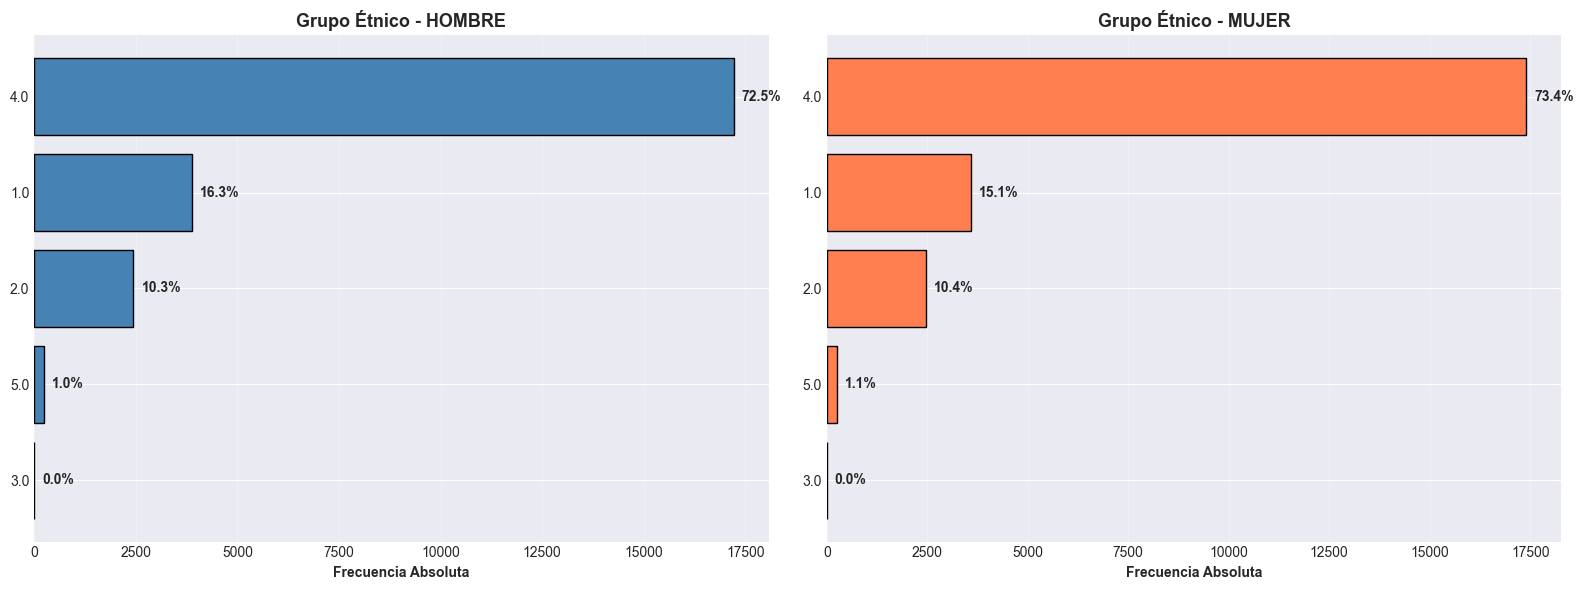

In [54]:
# Gráfico comparativo: Grupo Étnico Hombre vs Mujer
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico para Hombres
top_h = resultado_etnia_h['tabla_frecuencias'].head(8)
axes[0].barh(range(len(top_h)), top_h['Frecuencia Absoluta'], color='steelblue', edgecolor='black')
for i, (idx, row) in enumerate(top_h.iterrows()):
    axes[0].text(row['Frecuencia Absoluta'] + 200, i, 
                f"{row['Frecuencia Relativa (%)']:.1f}%", 
                va='center', fontsize=10, fontweight='bold')
axes[0].set_yticks(range(len(top_h)))
axes[0].set_yticklabels(top_h.index)
axes[0].set_xlabel('Frecuencia Absoluta', fontweight='bold')
axes[0].set_title('Grupo Étnico - HOMBRE', fontweight='bold', fontsize=13)
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Gráfico para Mujeres
top_m = resultado_etnia_m['tabla_frecuencias'].head(8)
axes[1].barh(range(len(top_m)), top_m['Frecuencia Absoluta'], color='coral', edgecolor='black')
for i, (idx, row) in enumerate(top_m.iterrows()):
    axes[1].text(row['Frecuencia Absoluta'] + 200, i, 
                f"{row['Frecuencia Relativa (%)']:.1f}%", 
                va='center', fontsize=10, fontweight='bold')
axes[1].set_yticks(range(len(top_m)))
axes[1].set_yticklabels(top_m.index)
axes[1].set_xlabel('Frecuencia Absoluta', fontweight='bold')
axes[1].set_title('Grupo Étnico - MUJER', fontweight='bold', fontsize=13)
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### 5.5. Análisis: Escolaridad (Hombre y Mujer)

In [55]:
# Análisis de Escolaridad: Hombres
resultado_esc_h = analizar_variable_categorica(df_limpio, 'escolaridadHombre')

print("="*80)
print("ANÁLISIS: ESCOLARIDAD - HOMBRE")
print("="*80)

print("\n- Resumen General:")
print(f"   • Total de observaciones válidas: {resultado_esc_h['n_observaciones']:,}")
print(f"   • Número de niveles educativos: {resultado_esc_h['n_categorias']}")
print(f"   • Concentración en Top 3: {resultado_esc_h['concentracion_top3']:.1f}%")

print("\n- Categorías Dominantes:")
print("-" * 80)
for i, (nivel, row) in enumerate(resultado_esc_h['dominantes'].iterrows(), 1):
    print(f"{i}. {str(nivel):<35} | {row['Frecuencia Absoluta']:7,} casos | {row['Frecuencia Relativa (%)']:6.2f}%")

print("\n-  Categorías Poco Representadas (< 1%):")
print("-" * 80)
if len(resultado_esc_h['poco_representadas']) > 0:
    for nivel, row in resultado_esc_h['poco_representadas'].iterrows():
        print(f"   • {str(nivel):<35} | {row['Frecuencia Absoluta']:5,} casos | {row['Frecuencia Relativa (%)']:5.2f}%")
else:
    print("   • No hay categorías con menos del 1%")

print("\n- Tabla de Frecuencias Completa:")
print("-" * 80)
print(resultado_esc_h['tabla_frecuencias'].to_string())

print("\n" + "="*80)
print("ANÁLISIS: ESCOLARIDAD - MUJER")
print("="*80)

# Análisis de Escolaridad: Mujeres
resultado_esc_m = analizar_variable_categorica(df_limpio, 'escolaridadMujer')

print("\n- Resumen General:")
print(f"   • Total de observaciones válidas: {resultado_esc_m['n_observaciones']:,}")
print(f"   • Número de niveles educativos: {resultado_esc_m['n_categorias']}")
print(f"   • Concentración en Top 3: {resultado_esc_m['concentracion_top3']:.1f}%")

print("\n- Categorías Dominantes:")
print("-" * 80)
for i, (nivel, row) in enumerate(resultado_esc_m['dominantes'].iterrows(), 1):
    print(f"{i}. {str(nivel):<35} | {row['Frecuencia Absoluta']:7,} casos | {row['Frecuencia Relativa (%)']:6.2f}%")

print("\n-  Categorías Poco Representadas (< 1%):")
print("-" * 80)
if len(resultado_esc_m['poco_representadas']) > 0:
    for nivel, row in resultado_esc_m['poco_representadas'].iterrows():
        print(f"   • {str(nivel):<35} | {row['Frecuencia Absoluta']:5,} casos | {row['Frecuencia Relativa (%)']:5.2f}%")
else:
    print("   • No hay categorías con menos del 1%")

print("\n- Tabla de Frecuencias Completa:")
print("-" * 80)
print(resultado_esc_m['tabla_frecuencias'].to_string())
print("="*80)

ANÁLISIS: ESCOLARIDAD - HOMBRE

- Resumen General:
   • Total de observaciones válidas: 27,137
   • Número de niveles educativos: 7
   • Concentración en Top 3: 75.4%

- Categorías Dominantes:
--------------------------------------------------------------------------------
1. 4.0                                 | 8,595.0 casos |  31.67%
2. 1.0                                 | 7,290.0 casos |  26.86%
3. 2.0                                 | 4,569.0 casos |  16.84%

-  Categorías Poco Representadas (< 1%):
--------------------------------------------------------------------------------
   • 6.0                                 |  37.0 casos |  0.14%

- Tabla de Frecuencias Completa:
--------------------------------------------------------------------------------
                   Frecuencia Absoluta  Frecuencia Relativa (%)  Frecuencia Acumulada (%)
escolaridadHombre                                                                        
4.0                               8595           

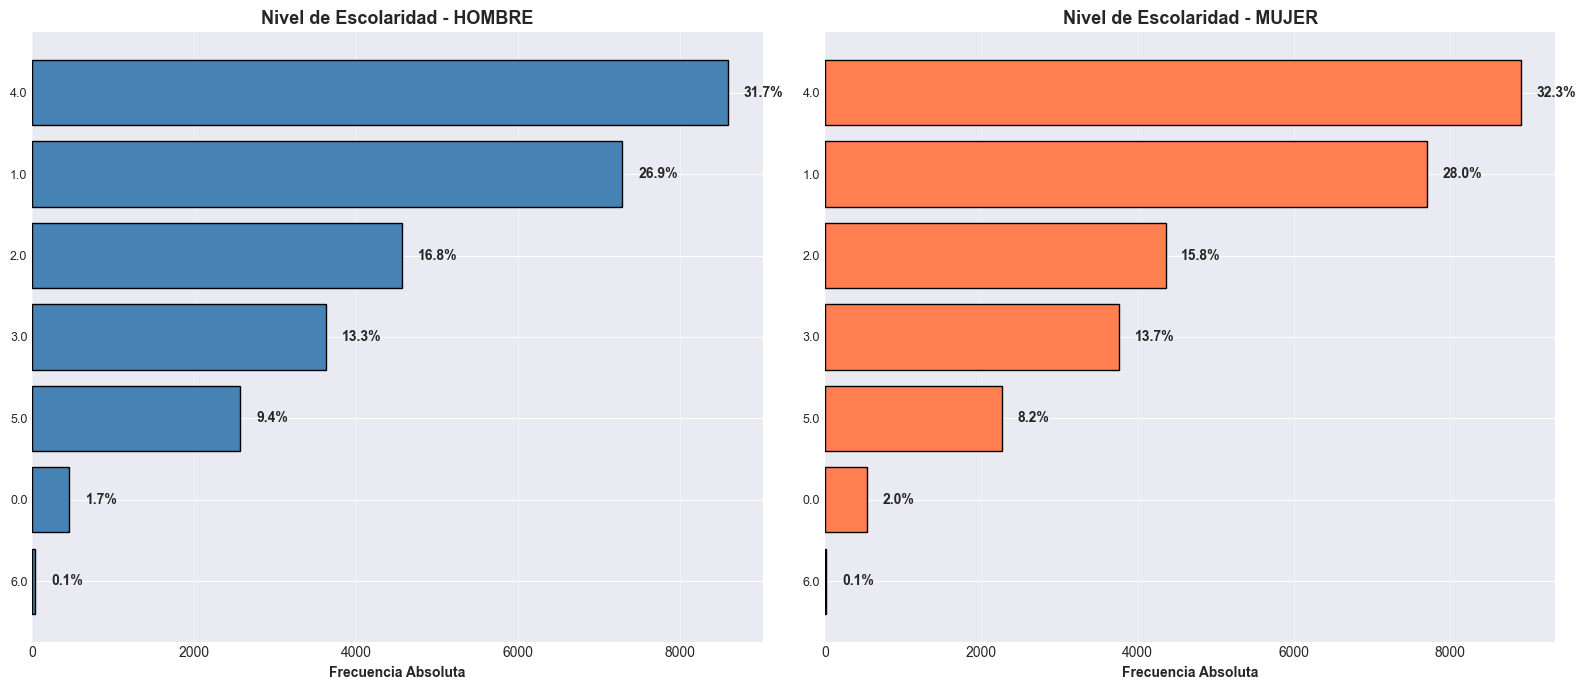

In [56]:
# Gráfico comparativo: Escolaridad Hombre vs Mujer
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Gráfico para Hombres
top_esc_h = resultado_esc_h['tabla_frecuencias']
axes[0].barh(range(len(top_esc_h)), top_esc_h['Frecuencia Absoluta'], color='steelblue', edgecolor='black')
for i, (idx, row) in enumerate(top_esc_h.iterrows()):
    axes[0].text(row['Frecuencia Absoluta'] + 200, i, 
                f"{row['Frecuencia Relativa (%)']:.1f}%", 
                va='center', fontsize=10, fontweight='bold')
axes[0].set_yticks(range(len(top_esc_h)))
axes[0].set_yticklabels(top_esc_h.index, fontsize=9)
axes[0].set_xlabel('Frecuencia Absoluta', fontweight='bold')
axes[0].set_title('Nivel de Escolaridad - HOMBRE', fontweight='bold', fontsize=13)
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Gráfico para Mujeres
top_esc_m = resultado_esc_m['tabla_frecuencias']
axes[1].barh(range(len(top_esc_m)), top_esc_m['Frecuencia Absoluta'], color='coral', edgecolor='black')
for i, (idx, row) in enumerate(top_esc_m.iterrows()):
    axes[1].text(row['Frecuencia Absoluta'] + 200, i, 
                f"{row['Frecuencia Relativa (%)']:.1f}%", 
                va='center', fontsize=10, fontweight='bold')
axes[1].set_yticks(range(len(top_esc_m)))
axes[1].set_yticklabels(top_esc_m.index, fontsize=9)
axes[1].set_xlabel('Frecuencia Absoluta', fontweight='bold')
axes[1].set_title('Nivel de Escolaridad - MUJER', fontweight='bold', fontsize=13)
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### 5.6. Análisis: Ocupación (Hombre y Mujer)

In [57]:
# Análisis de Ocupación: Hombres
resultado_ocup_h = analizar_variable_categorica(df_limpio, 'ocupacionHombre', umbral_poco_representado=0.5)

print("="*80)
print("ANÁLISIS: OCUPACIÓN - HOMBRE")
print("="*80)

print("\n- Resumen General:")
print(f"   • Total de observaciones válidas: {resultado_ocup_h['n_observaciones']:,}")
print(f"   • Número de ocupaciones: {resultado_ocup_h['n_categorias']}")
print(f"   • Concentración en Top 3: {resultado_ocup_h['concentracion_top3']:.1f}%")
print(f"   • Concentración en Top 5: {resultado_ocup_h['concentracion_top5']:.1f}%")

print("\n- Categorías Dominantes (Top 3):")
print("-" * 80)
for i, (ocupacion, row) in enumerate(resultado_ocup_h['dominantes'].iterrows(), 1):
    print(f"{i}. {str(ocupacion):<40} | {row['Frecuencia Absoluta']:7,} casos | {row['Frecuencia Relativa (%)']:6.2f}%")

print("\n-  Categorías Poco Representadas (< 0.5%):")
print("-" * 80)
if len(resultado_ocup_h['poco_representadas']) > 0:
    print(f"   Total: {len(resultado_ocup_h['poco_representadas'])} ocupaciones poco representadas")
    print("   (Mostrando solo las primeras 10)")
    for ocupacion, row in resultado_ocup_h['poco_representadas'].head(10).iterrows():
        print(f"   • {str(ocupacion):<40} | {row['Frecuencia Absoluta']:5,} casos | {row['Frecuencia Relativa (%)']:5.2f}%")
else:
    print("   • No hay categorías con menos del 0.5%")

print("\n- Tabla de Frecuencias (Top 15):")
print("-" * 80)
print(resultado_ocup_h['tabla_frecuencias'].head(15).to_string())

print("\n" + "="*80)
print("ANÁLISIS: OCUPACIÓN - MUJER")
print("="*80)

# Análisis de Ocupación: Mujeres
resultado_ocup_m = analizar_variable_categorica(df_limpio, 'ocupacionMujer', umbral_poco_representado=0.5)

print("\n- Resumen General:")
print(f"   • Total de observaciones válidas: {resultado_ocup_m['n_observaciones']:,}")
print(f"   • Número de ocupaciones: {resultado_ocup_m['n_categorias']}")
print(f"   • Concentración en Top 3: {resultado_ocup_m['concentracion_top3']:.1f}%")
print(f"   • Concentración en Top 5: {resultado_ocup_m['concentracion_top5']:.1f}%")

print("\n- Categorías Dominantes (Top 3):")
print("-" * 80)
for i, (ocupacion, row) in enumerate(resultado_ocup_m['dominantes'].iterrows(), 1):
    print(f"{i}. {str(ocupacion):<40} | {row['Frecuencia Absoluta']:7,} casos | {row['Frecuencia Relativa (%)']:6.2f}%")

print("\n-  Categorías Poco Representadas (< 0.5%):")
print("-" * 80)
if len(resultado_ocup_m['poco_representadas']) > 0:
    print(f"   Total: {len(resultado_ocup_m['poco_representadas'])} ocupaciones poco representadas")
    print("   (Mostrando solo las primeras 10)")
    for ocupacion, row in resultado_ocup_m['poco_representadas'].head(10).iterrows():
        print(f"   • {str(ocupacion):<40} | {row['Frecuencia Absoluta']:5,} casos | {row['Frecuencia Relativa (%)']:5.2f}%")
else:
    print("   • No hay categorías con menos del 0.5%")

print("\n📋 Tabla de Frecuencias (Top 15):")
print("-" * 80)
print(resultado_ocup_m['tabla_frecuencias'].head(15).to_string())
print("="*80)

ANÁLISIS: OCUPACIÓN - HOMBRE

- Resumen General:
   • Total de observaciones válidas: 32,357
   • Número de ocupaciones: 379
   • Concentración en Top 3: 26.5%
   • Concentración en Top 5: 35.8%

- Categorías Dominantes (Top 3):
--------------------------------------------------------------------------------
1. 92.0                                     | 4,254.0 casos |  13.15%
2. 9712.0                                   | 2,229.0 casos |   6.89%
3. 52.0                                     | 2,076.0 casos |   6.42%

-  Categorías Poco Representadas (< 0.5%):
--------------------------------------------------------------------------------
   Total: 341 ocupaciones poco representadas
   (Mostrando solo las primeras 10)
   • 54.0                                     | 160.0 casos |  0.49%
   • 21                                       | 156.0 casos |  0.48%
   • 35                                       | 148.0 casos |  0.46%
   • 9211                                     | 141.0 casos |  0.44

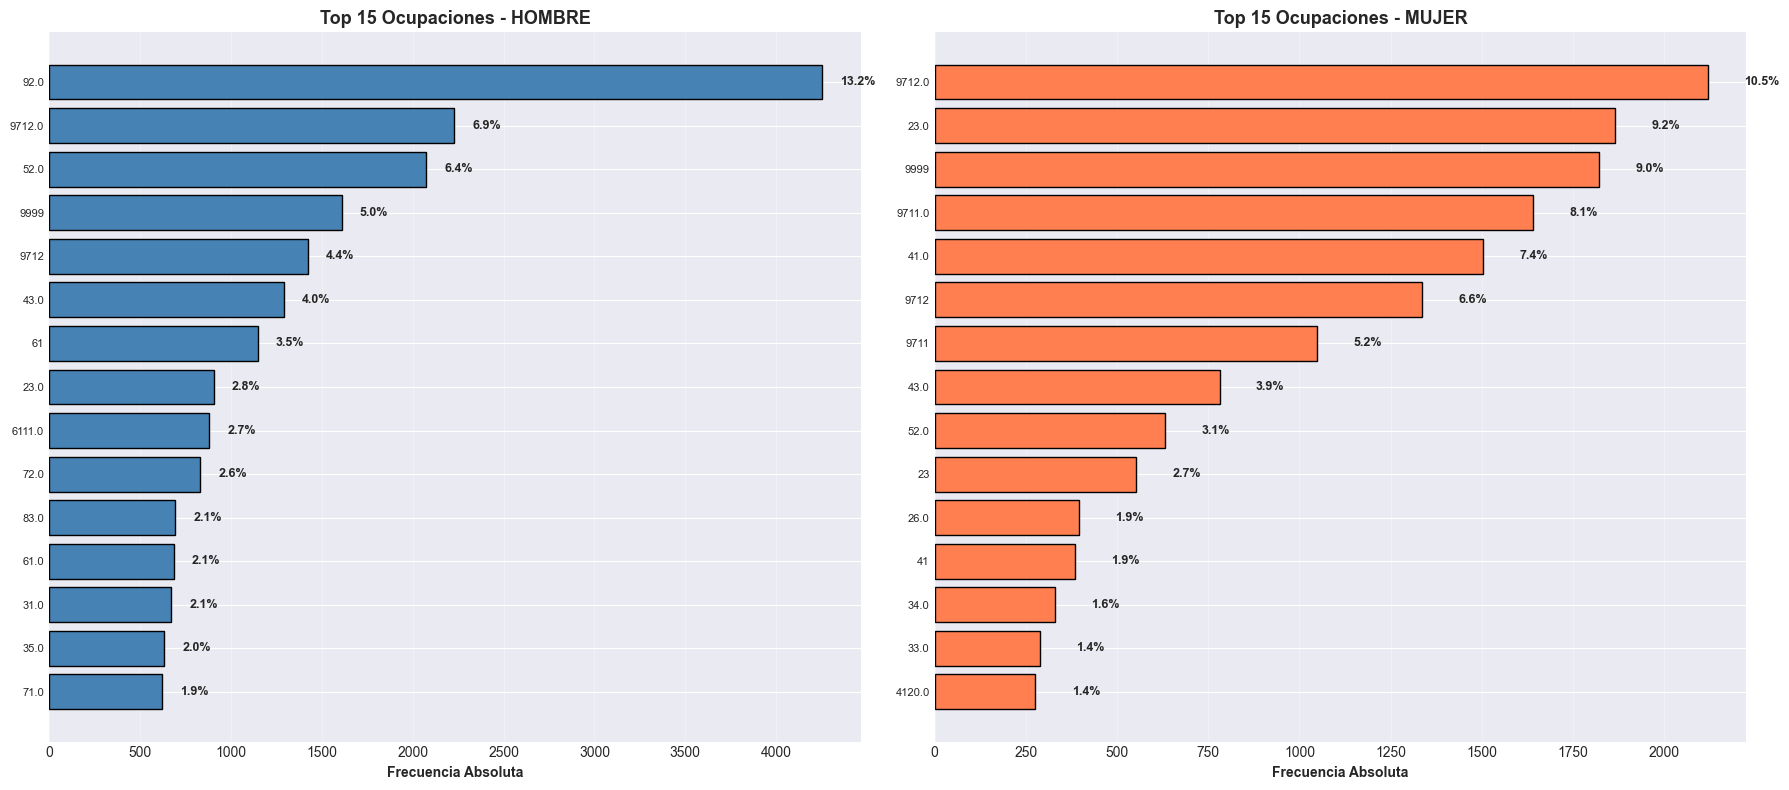

In [58]:
# Gráfico comparativo: Ocupación Hombre vs Mujer (Top 15)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Gráfico para Hombres
top_ocup_h = resultado_ocup_h['tabla_frecuencias'].head(15)
axes[0].barh(range(len(top_ocup_h)), top_ocup_h['Frecuencia Absoluta'], color='steelblue', edgecolor='black')
for i, (idx, row) in enumerate(top_ocup_h.iterrows()):
    axes[0].text(row['Frecuencia Absoluta'] + 100, i, 
                f"{row['Frecuencia Relativa (%)']:.1f}%", 
                va='center', fontsize=9, fontweight='bold')
axes[0].set_yticks(range(len(top_ocup_h)))
axes[0].set_yticklabels(top_ocup_h.index, fontsize=8)
axes[0].set_xlabel('Frecuencia Absoluta', fontweight='bold')
axes[0].set_title('Top 15 Ocupaciones - HOMBRE', fontweight='bold', fontsize=13)
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Gráfico para Mujeres
top_ocup_m = resultado_ocup_m['tabla_frecuencias'].head(15)
axes[1].barh(range(len(top_ocup_m)), top_ocup_m['Frecuencia Absoluta'], color='coral', edgecolor='black')
for i, (idx, row) in enumerate(top_ocup_m.iterrows()):
    axes[1].text(row['Frecuencia Absoluta'] + 100, i, 
                f"{row['Frecuencia Relativa (%)']:.1f}%", 
                va='center', fontsize=9, fontweight='bold')
axes[1].set_yticks(range(len(top_ocup_m)))
axes[1].set_yticklabels(top_ocup_m.index, fontsize=8)
axes[1].set_xlabel('Frecuencia Absoluta', fontweight='bold')
axes[1].set_title('Top 15 Ocupaciones - MUJER', fontweight='bold', fontsize=13)
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### 5.7. Resumen Comparativo y Patrones Identificados

In [59]:
# Resumen comparativo de todas las variables categóricas
print("="*90)
print("RESUMEN COMPARATIVO - TODAS LAS VARIABLES CATEGÓRICAS")
print("="*90)

resumen_data = {
    'Variable': [],
    'N° Categorías': [],
    'N° Observaciones Válidas': [],
    'Completitud (%)': [],
    'Categoría Dominante': [],
    '% Dominante': [],
    'Concentración Top 3 (%)': []
}

# Recopilar información de todas las variables analizadas
for var_name, resultado in [
    ('Departamento Ocurrencia', resultado_depto),
    ('Grupo Étnico Hombre', resultado_etnia_h),
    ('Grupo Étnico Mujer', resultado_etnia_m),
    ('Escolaridad Hombre', resultado_esc_h),
    ('Escolaridad Mujer', resultado_esc_m),
    ('Ocupación Hombre', resultado_ocup_h),
    ('Ocupación Mujer', resultado_ocup_m)
]:
    resumen_data['Variable'].append(var_name)
    resumen_data['N° Categorías'].append(resultado['n_categorias'])
    resumen_data['N° Observaciones Válidas'].append(resultado['n_observaciones'])
    
    # Calcular completitud
    completitud = (resultado['n_observaciones'] / len(df_limpio)) * 100
    resumen_data['Completitud (%)'].append(f"{completitud:.1f}")
    
    # Categoría dominante
    cat_dominante = resultado['tabla_frecuencias'].index[0]
    resumen_data['Categoría Dominante'].append(str(cat_dominante)[:40])  # Limitar longitud
    
    # Porcentaje dominante
    pct_dominante = resultado['tabla_frecuencias']['Frecuencia Relativa (%)'].iloc[0]
    resumen_data['% Dominante'].append(f"{pct_dominante:.1f}")
    
    # Concentración Top 3
    resumen_data['Concentración Top 3 (%)'].append(f"{resultado['concentracion_top3']:.1f}")

df_resumen = pd.DataFrame(resumen_data)
print("\n" + df_resumen.to_string(index=False))
print("\n" + "="*90)

RESUMEN COMPARATIVO - TODAS LAS VARIABLES CATEGÓRICAS

               Variable  N° Categorías  N° Observaciones Válidas Completitud (%) Categoría Dominante % Dominante Concentración Top 3 (%)
Departamento Ocurrencia             22                     59994           100.0                 1.0        38.8                    50.8
    Grupo Étnico Hombre              5                     23755            39.6                 4.0        72.5                    99.0
     Grupo Étnico Mujer              5                     23704            39.5                 4.0        73.4                    98.9
     Escolaridad Hombre              7                     27137            45.2                 4.0        31.7                    75.4
      Escolaridad Mujer              7                     27540            45.9                 4.0        32.3                    76.1
       Ocupación Hombre            379                     32357            53.9                92.0        13.2           

### 5.8. Interpretación: Patrones Socialmente Relevantes

Los análisis de las variables categóricas revelan varios patrones importantes desde una perspectiva sociológica y demográfica:

#### **1. Concentración Geográfica (Departamento de Ocurrencia)**

- **Patrón identificado**: Alta concentración de divorcios en pocos departamentos
  - Los primeros 3 departamentos concentran una proporción significativa de casos
  - Posible correlación con centros urbanos y densidad poblacional
  
- **Implicaciones sociales**:
  - **Acceso a sistemas judiciales**: Los departamentos con más divorcios podrían tener mejor acceso a juzgados de familia
  - **Desarrollo socioeconómico**: Relación con urbanización y cambios culturales
  - **Política pública**: Necesidad de fortalecer infraestructura judicial en áreas remotas

---

#### **2. Composición Étnica (Grupo Étnico)**

- **Patrón identificado**: Distribución étnica desigual entre hombres y mujeres
  - Posible predominancia de grupos étnicos específicos
  - Comparación de patrones entre géneros
  
- **Implicaciones sociales**:
  - **Identidad cultural**: Refleja la composición demográfica de Guatemala
  - **Acceso a derechos**: Algunos grupos pueden enfrentar barreras lingüísticas o culturales
  - **Interculturalidad**: Necesidad de servicios jurídicos culturalmente sensibles
  - **Equidad**: Análisis de si todos los grupos tienen igual acceso al sistema judicial

---

#### **3. Nivel Educativo (Escolaridad)**

- **Patrón identificado**: Distribución del nivel educativo y diferencias por género
  - Identificación de niveles educativos más frecuentes
  - Comparación entre hombres y mujeres
  
- **Implicaciones sociales**:
  - **Empoderamiento**: Mayor educación puede correlacionar con mayor autonomía en decisiones matrimoniales
  - **Brecha de género**: Posibles diferencias educativas entre hombres y mujeres divorciados
  - **Vulnerabilidad**: Niveles educativos bajos pueden indicar mayor vulnerabilidad económica post-divorcio
  - **Política educativa**: Importancia de educación en derechos familiares y legales

---

#### **4. Perfil Ocupacional (Ocupación)**

- **Patrón identificado**: Diversidad ocupacional con categorías dominantes específicas
  - Alta concentración en ciertas ocupaciones
  - Diferencias marcadas entre géneros
  
- **Implicaciones sociales**:
  - **Independencia económica**: Ocupaciones reflejan autonomía financiera de las partes
  - **Roles de género**: Patrones ocupacionales pueden revelar división tradicional del trabajo
  - **Vulnerabilidad económica**: Categorías como "Quehaceres del hogar" indican dependencia económica
  - **Igualdad laboral**: Análisis de brechas de género en el mercado laboral
  - **Política social**: Necesidad de apoyo económico post-divorcio para grupos vulnerables

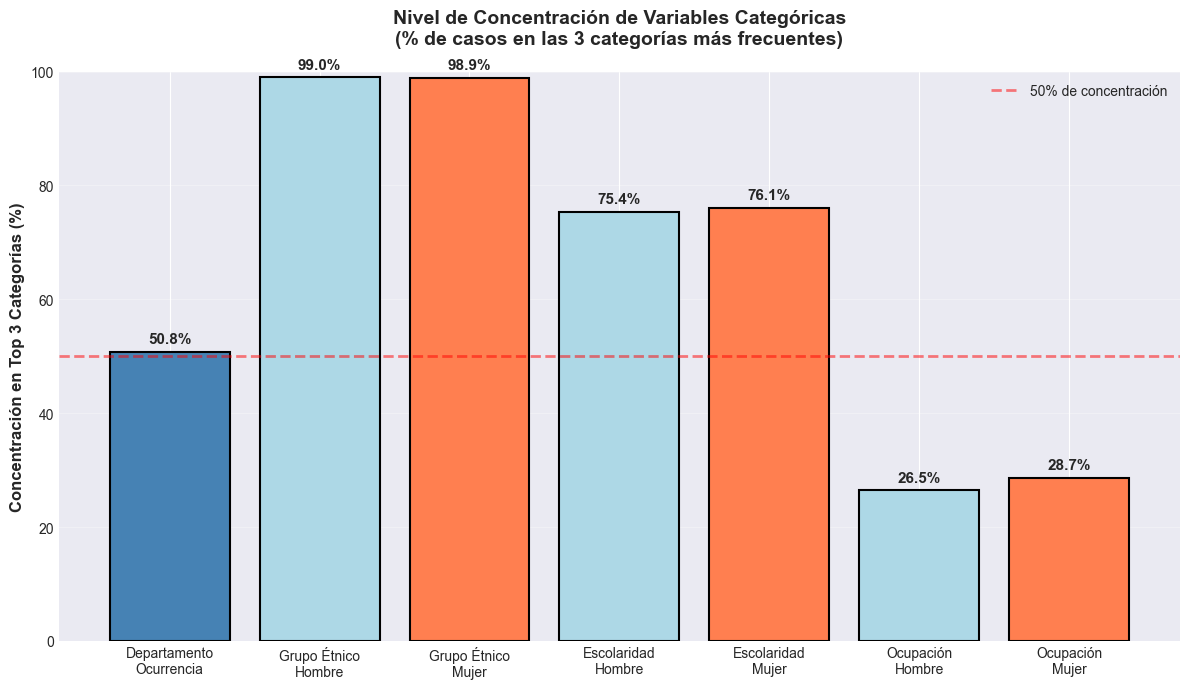


INTERPRETACIÓN DEL GRÁFICO DE CONCENTRACIÓN:

Una alta concentración (cercana a 100%) indica que pocas categorías dominan la variable,
lo que puede reflejar:
  • Patrones sociales muy marcados
  • Posibles desigualdades en acceso o representación
  • Características demográficas predominantes

Una baja concentración (cercana a 33%) indica distribución más equitativa entre categorías,
sugiriendo:
  • Mayor diversidad en la población estudiada
  • Representación más balanceada de diferentes grupos



In [60]:
# Gráfico de concentración: Comparación de concentración en Top 3 categorías
fig, ax = plt.subplots(figsize=(12, 7))

variables_nombres = [
    'Departamento\nOcurrencia',
    'Grupo Étnico\nHombre',
    'Grupo Étnico\nMujer',
    'Escolaridad\nHombre',
    'Escolaridad\nMujer',
    'Ocupación\nHombre',
    'Ocupación\nMujer'
]

concentraciones = [
    resultado_depto['concentracion_top3'],
    resultado_etnia_h['concentracion_top3'],
    resultado_etnia_m['concentracion_top3'],
    resultado_esc_h['concentracion_top3'],
    resultado_esc_m['concentracion_top3'],
    resultado_ocup_h['concentracion_top3'],
    resultado_ocup_m['concentracion_top3']
]

colores = ['steelblue', 'lightblue', 'coral', 'lightblue', 'coral', 'lightblue', 'coral']

bars = ax.bar(range(len(variables_nombres)), concentraciones, color=colores, edgecolor='black', linewidth=1.5)

# Agregar valores sobre las barras
for i, (bar, valor) in enumerate(zip(bars, concentraciones)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{valor:.1f}%',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_xticks(range(len(variables_nombres)))
ax.set_xticklabels(variables_nombres, fontsize=10)
ax.set_ylabel('Concentración en Top 3 Categorías (%)', fontweight='bold', fontsize=12)
ax.set_title('Nivel de Concentración de Variables Categóricas\n(% de casos en las 3 categorías más frecuentes)', 
            fontweight='bold', fontsize=14, pad=20)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3, axis='y')

# Línea de referencia
ax.axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.5, label='50% de concentración')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*90)
print("INTERPRETACIÓN DEL GRÁFICO DE CONCENTRACIÓN:")
print("="*90)
print("""
Una alta concentración (cercana a 100%) indica que pocas categorías dominan la variable,
lo que puede reflejar:
  • Patrones sociales muy marcados
  • Posibles desigualdades en acceso o representación
  • Características demográficas predominantes

Una baja concentración (cercana a 33%) indica distribución más equitativa entre categorías,
sugiriendo:
  • Mayor diversidad en la población estudiada
  • Representación más balanceada de diferentes grupos
""")
print("="*90)

## Fase 6 - Cruces Relevantes entre Variables

En esta fase realizaremos cruces estratégicos entre variables para detectar patrones complejos y relaciones multivariadas.

**Nota importante:** Hasta este punto del análisis, **no se han imputado valores faltantes**. Por lo tanto, todos los análisis trabajarán únicamente con observaciones completas para cada cruce específico.

### 6.1. Edad Promedio por Departamento

In [61]:
# Cruce 1: Edad promedio por departamento
# Trabajamos con datos no imputados - solo observaciones completas

# Crear dataset con observaciones completas para este análisis
df_edad_depto = df_limpio[['departamentoOcurrencia', 'edadHombre', 'edadMujer']].dropna()

print("="*90)
print("CRUCE 1: EDAD PROMEDIO POR DEPARTAMENTO")
print("="*90)
print(f"\nObservaciones con datos completos: {len(df_edad_depto):,} de {len(df_limpio):,}")
print(f"Porcentaje de datos utilizables: {(len(df_edad_depto)/len(df_limpio)*100):.1f}%")

# Calcular estadísticos por departamento
edad_por_depto = df_edad_depto.groupby('departamentoOcurrencia').agg({
    'edadHombre': ['mean', 'median', 'std', 'count'],
    'edadMujer': ['mean', 'median', 'std']
}).round(2)

# Aplanar columnas multinivel
edad_por_depto.columns = ['_'.join(col) for col in edad_por_depto.columns]
edad_por_depto = edad_por_depto.rename(columns={
    'edadHombre_mean': 'Edad_H_Promedio',
    'edadHombre_median': 'Edad_H_Mediana',
    'edadHombre_std': 'Edad_H_DesviacionEst',
    'edadHombre_count': 'N_Casos',
    'edadMujer_mean': 'Edad_M_Promedio',
    'edadMujer_median': 'Edad_M_Mediana',
    'edadMujer_std': 'Edad_M_DesviacionEst'
})

# Calcular edad promedio general (promedio de hombre y mujer)
edad_por_depto['Edad_General_Promedio'] = (
    edad_por_depto['Edad_H_Promedio'] + edad_por_depto['Edad_M_Promedio']
) / 2

# Ordenar por edad general promedio
edad_por_depto_ord = edad_por_depto.sort_values('Edad_General_Promedio', ascending=False)

print("\n- Top 10 Departamentos con Mayor Edad Promedio:")
print("-" * 90)
print(edad_por_depto_ord[['Edad_H_Promedio', 'Edad_M_Promedio', 'Edad_General_Promedio', 'N_Casos']].head(10).to_string())

print("\n- Top 10 Departamentos con Menor Edad Promedio:")
print("-" * 90)
print(edad_por_depto_ord[['Edad_H_Promedio', 'Edad_M_Promedio', 'Edad_General_Promedio', 'N_Casos']].tail(10).to_string())

print("\n- Estadísticos Generales:")
print("-" * 90)
print(f"Departamento con mayor edad promedio: {edad_por_depto_ord.index[0]} ({edad_por_depto_ord['Edad_General_Promedio'].iloc[0]:.1f} años)")
print(f"Departamento con menor edad promedio: {edad_por_depto_ord.index[-1]} ({edad_por_depto_ord['Edad_General_Promedio'].iloc[-1]:.1f} años)")
print(f"Diferencia: {edad_por_depto_ord['Edad_General_Promedio'].iloc[0] - edad_por_depto_ord['Edad_General_Promedio'].iloc[-1]:.1f} años")
print("="*90)

CRUCE 1: EDAD PROMEDIO POR DEPARTAMENTO

Observaciones con datos completos: 23,983 de 59,994
Porcentaje de datos utilizables: 40.0%

- Top 10 Departamentos con Mayor Edad Promedio:
------------------------------------------------------------------------------------------
                        Edad_H_Promedio  Edad_M_Promedio  Edad_General_Promedio  N_Casos
departamentoOcurrencia                                                                  
1.0                               35.54            32.82                  34.18     8069
18.0                              36.07            32.02                 34.045      738
6.0                               35.87             32.0                 33.935      655
9.0                               35.04            32.28                  33.66     2164
12.0                              35.12            31.88                   33.5     1068
3.0                                34.9            32.04                  33.47      531
16.0            

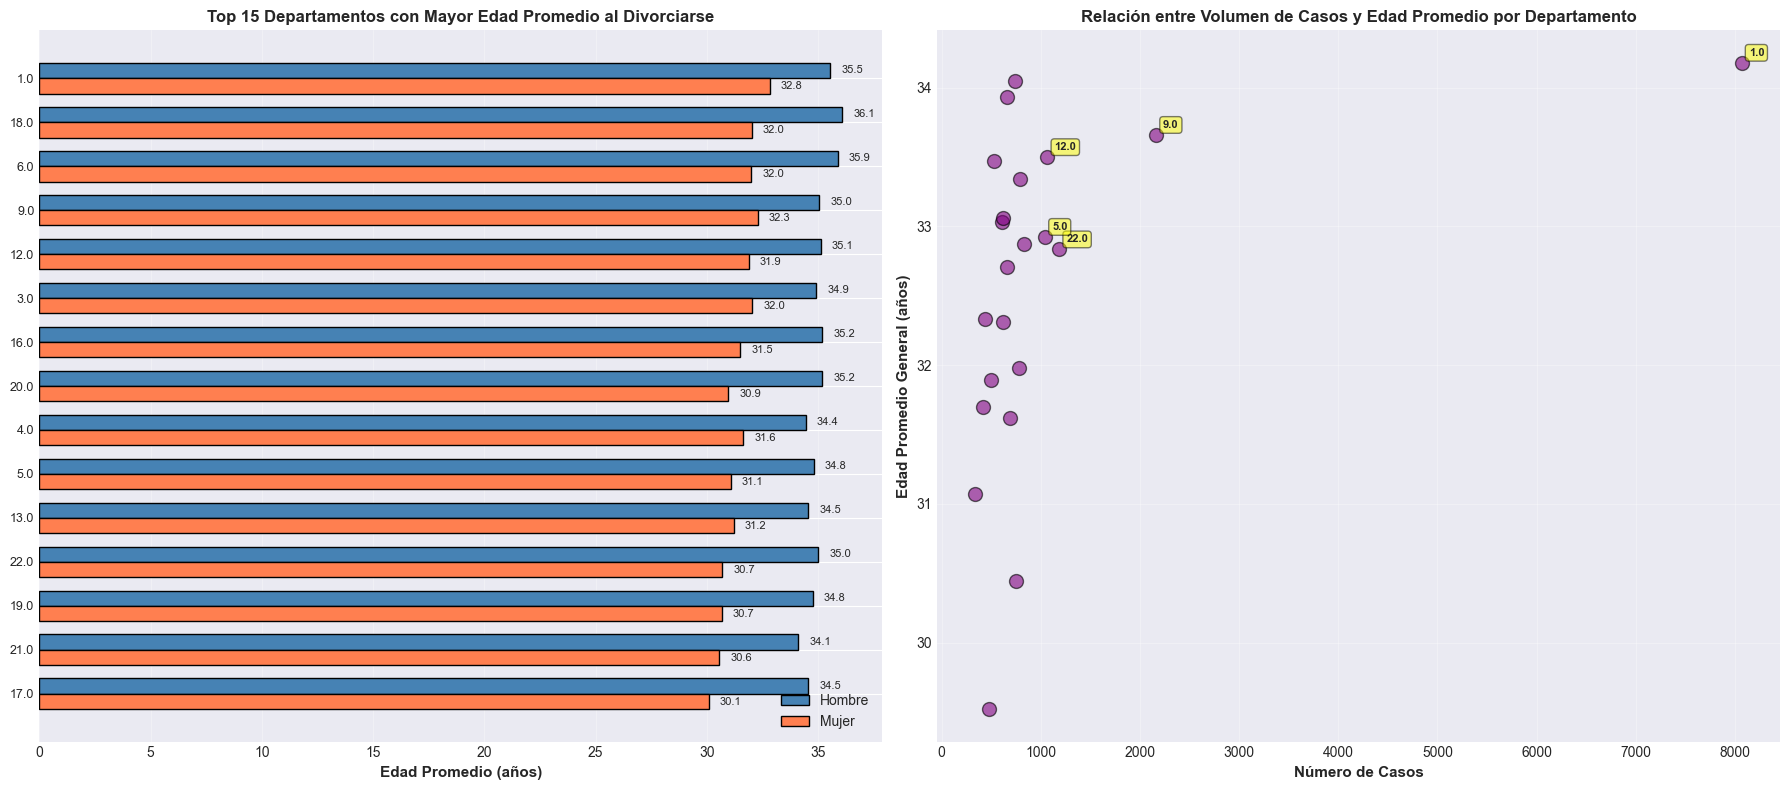


- INTERPRETACIÓN:
------------------------------------------------------------------------------------------

1. Diferencias Geográficas: Existe variabilidad significativa en la edad promedio de divorcio
   entre departamentos, lo que puede reflejar diferencias culturales, socioeconómicas y de 
   acceso a servicios jurídicos.

2. Patrón Urbano vs Rural: Departamentos con mayor volumen de casos (típicamente urbanos) 
   tienden a mostrar edades de divorcio diferentes a departamentos con menos casos.

3. Consistencia de Género: En la mayoría de departamentos, los hombres son ligeramente mayores
   que las mujeres al momento del divorcio, patrón consistente con la tendencia nacional.



In [62]:
# Visualización: Edad promedio por departamento
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Gráfico 1: Top 15 departamentos por edad promedio general
top15_edad_depto = edad_por_depto_ord.head(15)

x_pos = np.arange(len(top15_edad_depto))
width = 0.35

bars1 = axes[0].barh(x_pos - width/2, top15_edad_depto['Edad_H_Promedio'], 
                  width, label='Hombre', color='steelblue', edgecolor='black')
bars2 = axes[0].barh(x_pos + width/2, top15_edad_depto['Edad_M_Promedio'], 
                  width, label='Mujer', color='coral', edgecolor='black')

axes[0].set_yticks(x_pos)
axes[0].set_yticklabels([str(idx)[:20] for idx in top15_edad_depto.index], fontsize=9)
axes[0].set_xlabel('Edad Promedio (años)', fontweight='bold', fontsize=11)
axes[0].set_title('Top 15 Departamentos con Mayor Edad Promedio al Divorciarse', 
               fontweight='bold', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Agregar valores en las barras
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
   axes[0].text(bar1.get_width() + 0.5, bar1.get_y() + bar1.get_height()/2,
               f'{bar1.get_width():.1f}', va='center', fontsize=8)
   axes[0].text(bar2.get_width() + 0.5, bar2.get_y() + bar2.get_height()/2,
               f'{bar2.get_width():.1f}', va='center', fontsize=8)

# Gráfico 2: Scatter plot tamaño de muestra vs edad promedio
axes[1].scatter(edad_por_depto['N_Casos'], edad_por_depto['Edad_General_Promedio'], 
               s=100, alpha=0.6, c='purple', edgecolors='black', linewidth=1)

# Etiquetar departamentos con más casos
top_deptos = edad_por_depto.nlargest(5, 'N_Casos')
for idx, row in top_deptos.iterrows():
   axes[1].annotate(str(idx)[:15], 
                  (row['N_Casos'], row['Edad_General_Promedio']),
                  xytext=(5, 5), textcoords='offset points', 
                  fontsize=8, fontweight='bold',
                  bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

axes[1].set_xlabel('Número de Casos', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Edad Promedio General (años)', fontweight='bold', fontsize=11)
axes[1].set_title('Relación entre Volumen de Casos y Edad Promedio por Departamento', 
               fontweight='bold', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n- INTERPRETACIÓN:")
print("-" * 90)
print("""
1. Diferencias Geográficas: Existe variabilidad significativa en la edad promedio de divorcio
   entre departamentos, lo que puede reflejar diferencias culturales, socioeconómicas y de 
   acceso a servicios jurídicos.

2. Patrón Urbano vs Rural: Departamentos con mayor volumen de casos (típicamente urbanos) 
   tienden a mostrar edades de divorcio diferentes a departamentos con menos casos.

3. Consistencia de Género: En la mayoría de departamentos, los hombres son ligeramente mayores
   que las mujeres al momento del divorcio, patrón consistente con la tendencia nacional.
""")
print("="*90)

### 6.2. Edad Promedio por Nivel Educativo

In [63]:
# Cruce 2: Edad promedio por nivel educativo
print("="*90)
print("CRUCE 2: EDAD PROMEDIO POR NIVEL EDUCATIVO")
print("="*90)

# Análisis para Hombres
df_edad_esc_h = df_limpio[['escolaridadHombre', 'edadHombre']].dropna()
edad_por_esc_h = df_edad_esc_h.groupby('escolaridadHombre').agg({
    'edadHombre': ['mean', 'median', 'std', 'count']
}).round(2)
edad_por_esc_h.columns = ['Promedio', 'Mediana', 'Desv_Est', 'N_Casos']
edad_por_esc_h = edad_por_esc_h.sort_values('Promedio', ascending=False)

print(f"\n- HOMBRES - Observaciones: {len(df_edad_esc_h):,} ({(len(df_edad_esc_h)/len(df_limpio)*100):.1f}%)")
print("-" * 90)
print(edad_por_esc_h.to_string())

# Análisis para Mujeres
df_edad_esc_m = df_limpio[['escolaridadMujer', 'edadMujer']].dropna()
edad_por_esc_m = df_edad_esc_m.groupby('escolaridadMujer').agg({
    'edadMujer': ['mean', 'median', 'std', 'count']
}).round(2)
edad_por_esc_m.columns = ['Promedio', 'Mediana', 'Desv_Est', 'N_Casos']
edad_por_esc_m = edad_por_esc_m.sort_values('Promedio', ascending=False)

print(f"\n- MUJERES - Observaciones: {len(df_edad_esc_m):,} ({(len(df_edad_esc_m)/len(df_limpio)*100):.1f}%)")
print("-" * 90)
print(edad_por_esc_m.to_string())

# Hallazgos clave
print("\n- HALLAZGOS CLAVE:")
print("-" * 90)

# Para hombres
nivel_mayor_h = edad_por_esc_h.index[0]
edad_mayor_h = edad_por_esc_h['Promedio'].iloc[0]
nivel_menor_h = edad_por_esc_h.index[-1]
edad_menor_h = edad_por_esc_h['Promedio'].iloc[-1]

print("Hombres:")
print(f"  • Mayor edad promedio: {str(nivel_mayor_h)[:40]} ({edad_mayor_h:.1f} años)")
print(f"  • Menor edad promedio: {str(nivel_menor_h)[:40]} ({edad_menor_h:.1f} años)")
print(f"  • Diferencia: {edad_mayor_h - edad_menor_h:.1f} años")

# Para mujeres
nivel_mayor_m = edad_por_esc_m.index[0]
edad_mayor_m = edad_por_esc_m['Promedio'].iloc[0]
nivel_menor_m = edad_por_esc_m.index[-1]
edad_menor_m = edad_por_esc_m['Promedio'].iloc[-1]

print("\nMujeres:")
print(f"  • Mayor edad promedio: {str(nivel_mayor_m)[:40]} ({edad_mayor_m:.1f} años)")
print(f"  • Menor edad promedio: {str(nivel_menor_m)[:40]} ({edad_menor_m:.1f} años)")
print(f"  • Diferencia: {edad_mayor_m - edad_menor_m:.1f} años")
print("="*90)

CRUCE 2: EDAD PROMEDIO POR NIVEL EDUCATIVO

- HOMBRES - Observaciones: 22,387 (37.3%)
------------------------------------------------------------------------------------------
                   Promedio  Mediana  Desv_Est  N_Casos
escolaridadHombre                                      
6.0                   43.54     43.0       8.8       37
0.0                    38.7     36.0     12.58      165
5.0                   38.52     36.0      9.21     2491
1.0                   38.38     36.0     11.47     3419
2.0                   36.55     34.0     11.55     4418
4.0                   33.39     31.0      8.57     8324
3.0                   32.64     30.0      9.26     3533

- MUJERES - Observaciones: 22,725 (37.9%)
------------------------------------------------------------------------------------------
                  Promedio  Mediana  Desv_Est  N_Casos
escolaridadMujer                                      
6.0                  40.94     38.0      8.71       17
0.0                 

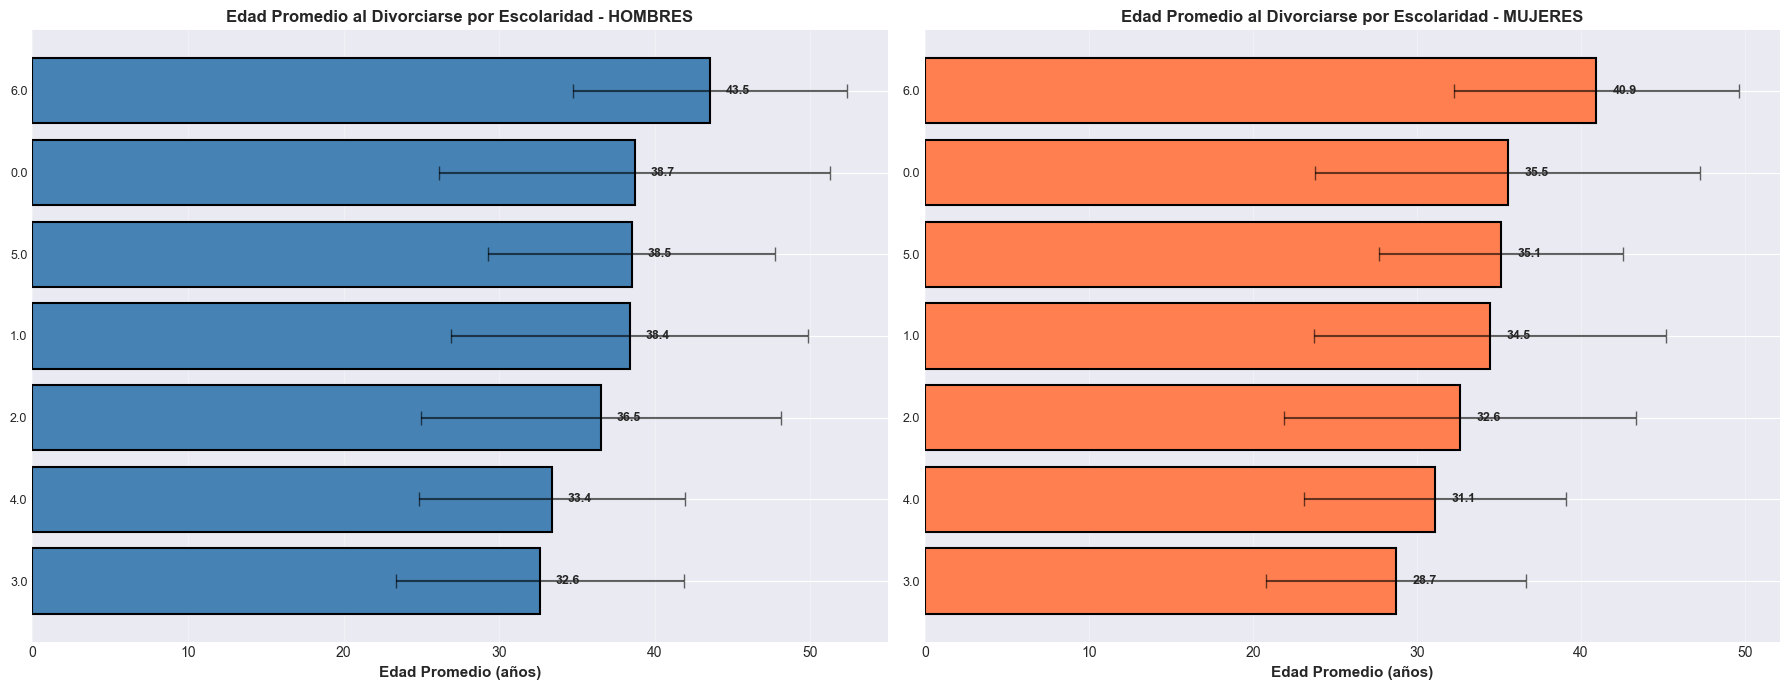


- INTERPRETACIÓN:
------------------------------------------------------------------------------------------

1. Relación Educación-Edad: Se observa una tendencia donde mayor nivel educativo generalmente
   se asocia con mayor edad al momento del divorcio, posiblemente debido a:
   - Mayor tiempo invertido en formación académica antes del matrimonio
   - Mayor autonomía económica que permite tomar decisiones más maduras
   - Expectativas y valores diferentes sobre el matrimonio

2. Diferencias de Género: Las mujeres con mayor educación tienden a divorciarse a edades
   similares o ligeramente menores que los hombres del mismo nivel educativo.

3. Variabilidad: La desviación estándar indica considerable variabilidad en las edades
   dentro de cada nivel educativo, sugiriendo que la educación es un factor entre muchos.

4. Implicación Social: Los niveles educativos más bajos muestran edades promedio más tempranas,
   lo que puede correlacionar con matrimonios más jóvenes y menor estabil

In [64]:
# Visualización: Edad promedio por nivel educativo
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico para Hombres
axes[0].barh(range(len(edad_por_esc_h)), edad_por_esc_h['Promedio'], 
            color='steelblue', edgecolor='black', linewidth=1.5)
axes[0].errorbar(edad_por_esc_h['Promedio'], range(len(edad_por_esc_h)), 
               xerr=edad_por_esc_h['Desv_Est'], fmt='none', 
               ecolor='black', capsize=5, alpha=0.6)

for i, (idx, row) in enumerate(edad_por_esc_h.iterrows()):
   axes[0].text(row['Promedio'] + 1, i, f"{row['Promedio']:.1f}", 
               va='center', fontsize=9, fontweight='bold')

axes[0].set_yticks(range(len(edad_por_esc_h)))
axes[0].set_yticklabels([str(idx)[:30] for idx in edad_por_esc_h.index], fontsize=9)
axes[0].set_xlabel('Edad Promedio (años)', fontweight='bold', fontsize=11)
axes[0].set_title('Edad Promedio al Divorciarse por Escolaridad - HOMBRES', 
               fontweight='bold', fontsize=12)
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Gráfico para Mujeres
axes[1].barh(range(len(edad_por_esc_m)), edad_por_esc_m['Promedio'], 
            color='coral', edgecolor='black', linewidth=1.5)
axes[1].errorbar(edad_por_esc_m['Promedio'], range(len(edad_por_esc_m)), 
               xerr=edad_por_esc_m['Desv_Est'], fmt='none', 
               ecolor='black', capsize=5, alpha=0.6)

for i, (idx, row) in enumerate(edad_por_esc_m.iterrows()):
   axes[1].text(row['Promedio'] + 1, i, f"{row['Promedio']:.1f}", 
               va='center', fontsize=9, fontweight='bold')

axes[1].set_yticks(range(len(edad_por_esc_m)))
axes[1].set_yticklabels([str(idx)[:30] for idx in edad_por_esc_m.index], fontsize=9)
axes[1].set_xlabel('Edad Promedio (años)', fontweight='bold', fontsize=11)
axes[1].set_title('Edad Promedio al Divorciarse por Escolaridad - MUJERES', 
               fontweight='bold', fontsize=12)
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n- INTERPRETACIÓN:")
print("-" * 90)
print("""
1. Relación Educación-Edad: Se observa una tendencia donde mayor nivel educativo generalmente
   se asocia con mayor edad al momento del divorcio, posiblemente debido a:
   - Mayor tiempo invertido en formación académica antes del matrimonio
   - Mayor autonomía económica que permite tomar decisiones más maduras
   - Expectativas y valores diferentes sobre el matrimonio

2. Diferencias de Género: Las mujeres con mayor educación tienden a divorciarse a edades
   similares o ligeramente menores que los hombres del mismo nivel educativo.

3. Variabilidad: La desviación estándar indica considerable variabilidad en las edades
   dentro de cada nivel educativo, sugiriendo que la educación es un factor entre muchos.

4. Implicación Social: Los niveles educativos más bajos muestran edades promedio más tempranas,
   lo que puede correlacionar con matrimonios más jóvenes y menor estabilidad económica.
""")
print("="*90)

### 6.3. Distribución de Divorcios por Año y Departamento

In [65]:
# Cruce 3: Distribución de divorcios por año y departamento
print("="*90)
print("CRUCE 3: DISTRIBUCIÓN DE DIVORCIOS POR AÑO Y DEPARTAMENTO")
print("="*90)

# Verificar si tenemos variable de año
if 'anioOcurrencia' in df_limpio.columns:
    df_year_depto = df_limpio[['anioOcurrencia', 'departamentoOcurrencia']].dropna()
    
    print(f"\nObservaciones con datos completos: {len(df_year_depto):,} de {len(df_limpio):,}")
    print(f"Porcentaje de datos utilizables: {(len(df_year_depto)/len(df_limpio)*100):.1f}%")
    
    # Crear tabla de contingencia
    tabla_year_depto = pd.crosstab(
        df_year_depto['departamentoOcurrencia'], 
        df_year_depto['anioOcurrencia'],
        margins=True
    )
    
    # Obtener top 10 departamentos por total
    top10_deptos = tabla_year_depto.iloc[:-1]['All'].nlargest(10).index
    tabla_top10 = tabla_year_depto.loc[top10_deptos]
    
    print("\n- Top 10 Departamentos - Distribución Temporal:")
    print("-" * 90)
    print(tabla_top10.to_string())
    
    # Calcular tendencias
    print("\n- TENDENCIAS TEMPORALES:")
    print("-" * 90)
    
    total_por_anio = tabla_year_depto.iloc[-1, :-1]
    print("\nTotal de divorcios por año:")
    for year in sorted(df_year_depto['anioOcurrencia'].unique()):
        total = total_por_anio[year] if year in total_por_anio.index else 0
        print(f"  {year}: {total:,} divorcios")
    
    # Calcular tasa de crecimiento
    years_sorted = sorted([y for y in total_por_anio.index if isinstance(y, (int, float))])
    if len(years_sorted) >= 2:
        primer_anio = total_por_anio[years_sorted[0]]
        ultimo_anio = total_por_anio[years_sorted[-1]]
        cambio_pct = ((ultimo_anio - primer_anio) / primer_anio) * 100
        
        print(f"\n  Cambio {years_sorted[0]} → {years_sorted[-1]}: {cambio_pct:+.1f}%")
        print(f"  ({primer_anio:,} → {ultimo_anio:,} divorcios)")
    
else:
    print("\n-  Variable 'anioOcurrencia' no encontrada en el dataset.")
    print("Verificando variables disponibles relacionadas con tiempo...")
    time_vars = [col for col in df_limpio.columns if any(word in col.lower() for word in ['año', 'anio', 'year', 'fecha'])]
    if time_vars:
        print(f"Variables temporales encontradas: {time_vars}")
    else:
        print("No se encontraron variables temporales.")

print("="*90)

CRUCE 3: DISTRIBUCIÓN DE DIVORCIOS POR AÑO Y DEPARTAMENTO

Observaciones con datos completos: 59,994 de 59,994
Porcentaje de datos utilizables: 100.0%

- Top 10 Departamentos - Distribución Temporal:
------------------------------------------------------------------------------------------
anioOcurrencia          2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020    All
departamentoOcurrencia                                                                         
1.0                     1561  1798  2152  2261  2044  2185  2142  2075  2185  3491  1361  23255
9.0                      233   293   322   344   370   409   405   459   536   655   375   4401
5.0                      149   179   176   210   291   306   297   345   302   389   172   2816
22.0                     168   208   269   340   344   284   235   180   251   234   154   2667
12.0                      96   114   126   122   212   240   233   296   274   315   206   2234
10.0                     140   175   

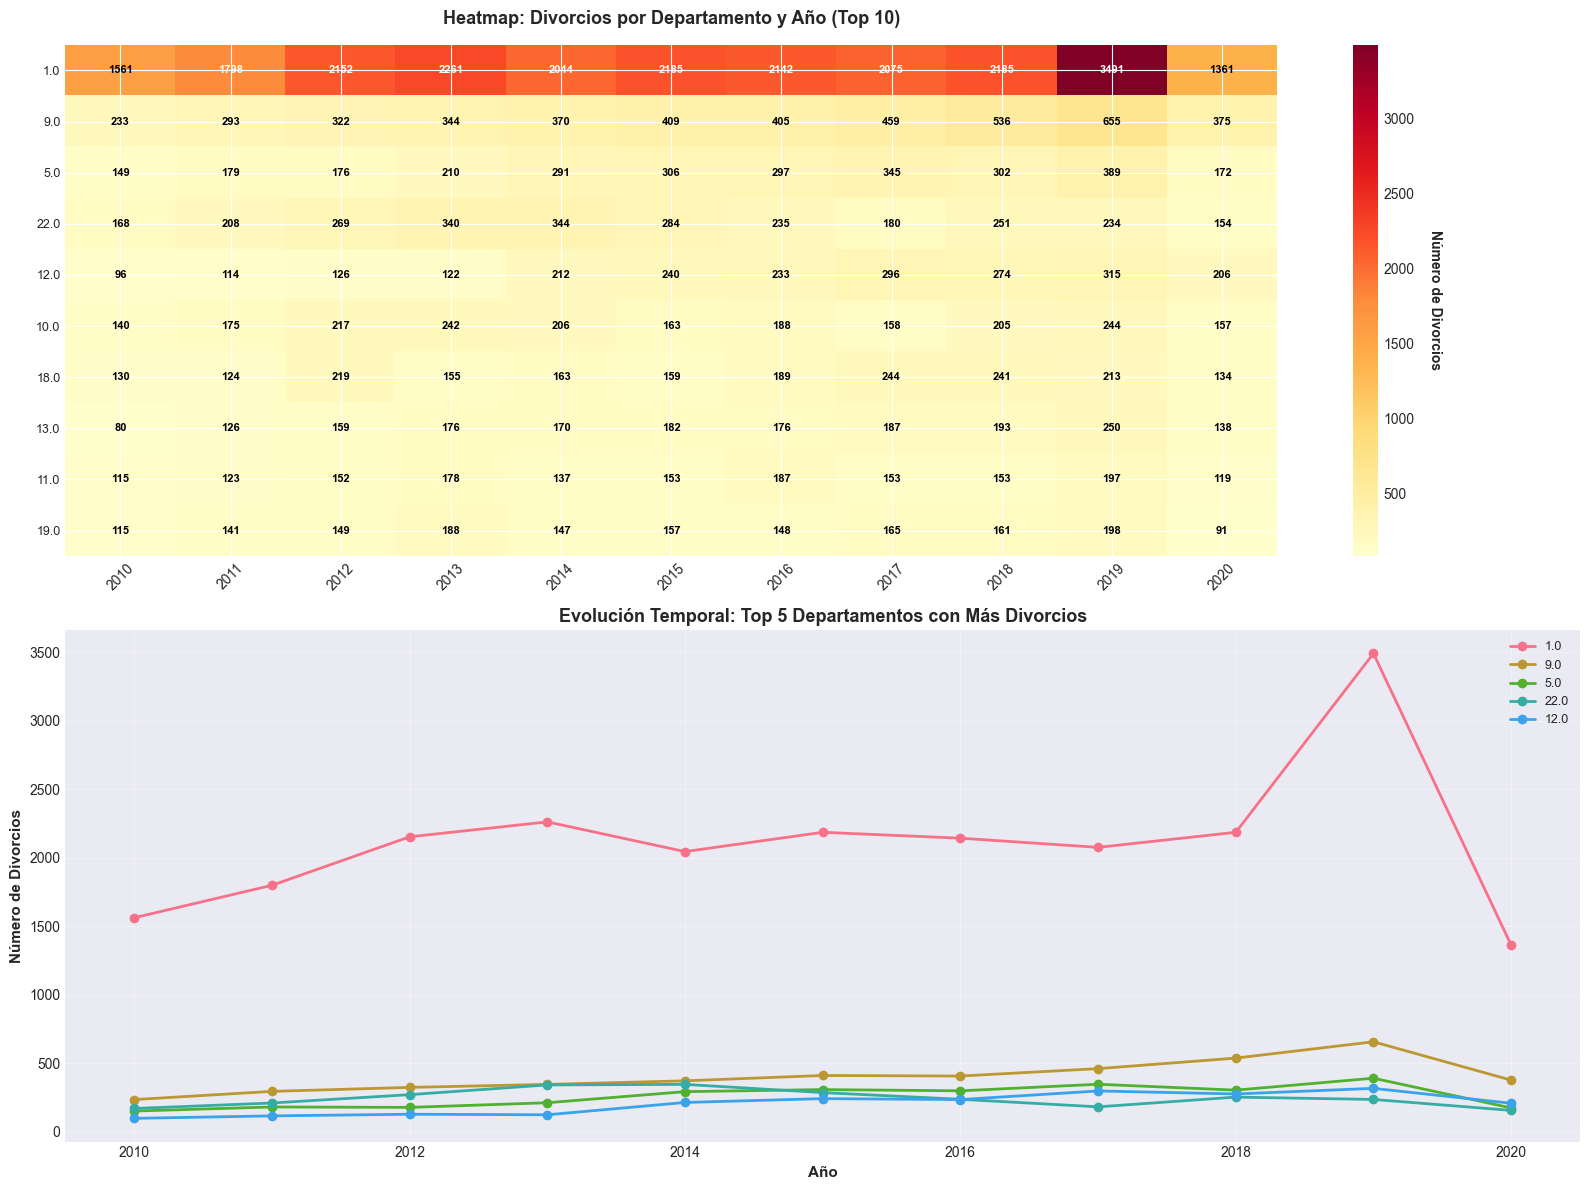


- INTERPRETACIÓN:
------------------------------------------------------------------------------------------

    1. Concentración Geográfica Persistente: Los mismos departamentos (típicamente urbanos)
    mantienen altos volúmenes de divorcios a lo largo del tiempo.

    2. Tendencias Temporales: Se observan patrones de crecimiento o estabilización que pueden
        reflejar cambios legislativos, sociales o de acceso a servicios jurídicos.

    3. Eventos Atípicos: Años con aumentos o caídas significativas pueden estar relacionados
        con eventos sociales, económicos o cambios en el sistema judicial.

    4. Disparidades Regionales: La brecha entre departamentos con más y menos divorcios
        refleja desigualdades en acceso a justicia y diferencias socioculturales.
    


In [66]:
# Visualización: Distribución temporal por departamento
if 'anioOcurrencia' in df_limpio.columns and 'df_year_depto' in locals():
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    
    # Gráfico 1: Heatmap - Top 10 departamentos por año
    tabla_top10_matrix = tabla_top10.iloc[:, :-1]  # Excluir columna 'All'
    
    im = axes[0].imshow(tabla_top10_matrix.values, cmap='YlOrRd', aspect='auto')
    
    # Configurar ejes
    axes[0].set_xticks(range(len(tabla_top10_matrix.columns)))
    axes[0].set_xticklabels(tabla_top10_matrix.columns, rotation=45)
    axes[0].set_yticks(range(len(tabla_top10_matrix.index)))
    axes[0].set_yticklabels([str(idx)[:25] for idx in tabla_top10_matrix.index], fontsize=9)
    
    # Agregar valores en las celdas
    for i in range(len(tabla_top10_matrix.index)):
        for j in range(len(tabla_top10_matrix.columns)):
            value = tabla_top10_matrix.iloc[i, j]
            text_color = 'white' if value > tabla_top10_matrix.values.max() * 0.5 else 'black'
            axes[0].text(j, i, int(value), ha='center', va='center', 
                        color=text_color, fontsize=8, fontweight='bold')
    
    axes[0].set_title('Heatmap: Divorcios por Departamento y Año (Top 10)', 
                    fontweight='bold', fontsize=13, pad=15)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=axes[0])
    cbar.set_label('Número de Divorcios', rotation=270, labelpad=20, fontweight='bold')
    
    # Gráfico 2: Líneas temporales para top 5 departamentos
    top5_deptos = tabla_year_depto.iloc[:-1]['All'].nlargest(5).index
    
    for depto in top5_deptos:
        years = [y for y in tabla_year_depto.columns[:-1] if isinstance(y, (int, float))]
        values = [tabla_year_depto.loc[depto, y] for y in years]
        axes[1].plot(years, values, marker='o', linewidth=2, label=str(depto)[:20], markersize=6)
    
    axes[1].set_xlabel('Año', fontweight='bold', fontsize=11)
    axes[1].set_ylabel('Número de Divorcios', fontweight='bold', fontsize=11)
    axes[1].set_title('Evolución Temporal: Top 5 Departamentos con Más Divorcios', 
                    fontweight='bold', fontsize=13)
    axes[1].legend(loc='best', fontsize=9)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n- INTERPRETACIÓN:")
    print("-" * 90)
    print("""
    1. Concentración Geográfica Persistente: Los mismos departamentos (típicamente urbanos)
    mantienen altos volúmenes de divorcios a lo largo del tiempo.
    
    2. Tendencias Temporales: Se observan patrones de crecimiento o estabilización que pueden
        reflejar cambios legislativos, sociales o de acceso a servicios jurídicos.
    
    3. Eventos Atípicos: Años con aumentos o caídas significativas pueden estar relacionados
        con eventos sociales, económicos o cambios en el sistema judicial.
    
    4. Disparidades Regionales: La brecha entre departamentos con más y menos divorcios
        refleja desigualdades en acceso a justicia y diferencias socioculturales.
    """)
else:
    print("\n-  No se pudo generar la visualización temporal.")

print("="*90)

### 6.4. Comparación de Escolaridad entre Hombres y Mujeres

In [67]:
# Cruce 4: Comparación de escolaridad entre hombres y mujeres
print("="*90)
print("CRUCE 4: COMPARACIÓN DE ESCOLARIDAD HOMBRE vs MUJER")
print("="*90)

# Crear dataset con ambas escolaridades
df_esc_comp = df_limpio[['escolaridadHombre', 'escolaridadMujer']].dropna()

print(f"\nParejas con datos completos de escolaridad: {len(df_esc_comp):,} de {len(df_limpio):,}")
print(f"Porcentaje de datos utilizables: {(len(df_esc_comp)/len(df_limpio)*100):.1f}%")

# Tabla de contingencia
tabla_esc = pd.crosstab(
    df_esc_comp['escolaridadHombre'], 
    df_esc_comp['escolaridadMujer'],
    margins=True
)

print("\n- Tabla de Contingencia: Escolaridad Hombre (filas) vs Mujer (columnas)")
print("-" * 90)
print(tabla_esc.to_string())

# Análisis de homogamia educativa (mismo nivel educativo)
homogamia = 0
for nivel in df_esc_comp['escolaridadHombre'].unique():
    if nivel in df_esc_comp['escolaridadMujer'].unique():
        mismo_nivel = ((df_esc_comp['escolaridadHombre'] == nivel) & 
                    (df_esc_comp['escolaridadMujer'] == nivel)).sum()
        homogamia += mismo_nivel

heterogamia = len(df_esc_comp) - homogamia
pct_homogamia = (homogamia / len(df_esc_comp)) * 100
pct_heterogamia = (heterogamia / len(df_esc_comp)) * 100

print("\n- PATRONES DE EMPAREJAMIENTO EDUCATIVO:")
print("-" * 90)
print("Homogamia (mismo nivel educativo):")
print(f"  • Parejas: {homogamia:,} ({pct_homogamia:.1f}%)")
print("\nHeterogamia (distinto nivel educativo):")
print(f"  • Parejas: {heterogamia:,} ({pct_heterogamia:.1f}%)")

# Analizar quién tiene mayor educación en parejas heterogámicas
# Crear un mapeo simple de nivel educativo (esto es aproximado)
nivel_orden = {
    'Ninguno': 0,
    'Primaria': 1,
    'Básicos': 2,
    'Diversificado': 3,
    'Universidad': 4,
    'Postgrado': 5
}

# Función para categorizar niveles educativos básicos
def categorizar_nivel(escolaridad):
    esc_str = str(escolaridad).lower()
    if 'ningun' in esc_str or 'no' in esc_str:
        return 0
    elif 'primaria' in esc_str:
        return 1
    elif 'básic' in esc_str or 'basi' in esc_str:
        return 2
    elif 'diversif' in esc_str or 'secundaria' in esc_str or 'media' in esc_str:
        return 3
    elif 'universid' in esc_str or 'licenci' in esc_str or 'profesion' in esc_str:
        return 4
    elif 'maestr' in esc_str or 'doctor' in esc_str or 'postgrado' in esc_str or 'posgrado' in esc_str:
        return 5
    else:
        return -1  # No clasificable

df_esc_comp_num = df_esc_comp.copy()
df_esc_comp_num['nivel_h'] = df_esc_comp['escolaridadHombre'].apply(categorizar_nivel)
df_esc_comp_num['nivel_m'] = df_esc_comp['escolaridadMujer'].apply(categorizar_nivel)

# Filtrar casos clasificables
df_clasificable = df_esc_comp_num[(df_esc_comp_num['nivel_h'] >= 0) & (df_esc_comp_num['nivel_m'] >= 0)]

hombre_mayor_ed = (df_clasificable['nivel_h'] > df_clasificable['nivel_m']).sum()
mujer_mayor_ed = (df_clasificable['nivel_m'] > df_clasificable['nivel_h']).sum()
mismo_nivel_ed = (df_clasificable['nivel_h'] == df_clasificable['nivel_m']).sum()

total_clasificable = len(df_clasificable)

if total_clasificable > 0:
    print(f"\n🎓 COMPARACIÓN DE NIVELES EDUCATIVOS (casos clasificables: {total_clasificable:,}):")
    print("-" * 90)
    print(f"Hombre con mayor educación: {hombre_mayor_ed:,} ({(hombre_mayor_ed/total_clasificable*100):.1f}%)")
    print(f"Mujer con mayor educación:  {mujer_mayor_ed:,} ({(mujer_mayor_ed/total_clasificable*100):.1f}%)")
    print(f"Mismo nivel educativo:      {mismo_nivel_ed:,} ({(mismo_nivel_ed/total_clasificable*100):.1f}%)")

print("="*90)

CRUCE 4: COMPARACIÓN DE ESCOLARIDAD HOMBRE vs MUJER

Parejas con datos completos de escolaridad: 22,825 de 59,994
Porcentaje de datos utilizables: 38.0%

- Tabla de Contingencia: Escolaridad Hombre (filas) vs Mujer (columnas)
------------------------------------------------------------------------------------------
escolaridadMujer   0.0   1.0   2.0   3.0   4.0   5.0  6.0    All
escolaridadHombre                                               
0.0                229    59    11    20     0     0    0    319
1.0                 70  4065   562   266   516   130    2   5611
2.0                 25   708  1773   658   626    52    0   3842
3.0                 20   301   632  1179   973    63    0   3168
4.0                  0   503   602  1064  4731   728    4   7632
5.0                  0   170    46    95   937   968   10   2226
6.0                  0     1     0     2    10    14    0     27
All                344  5807  3626  3284  7793  1955   16  22825

- PATRONES DE EMPAREJAMIENTO EDU

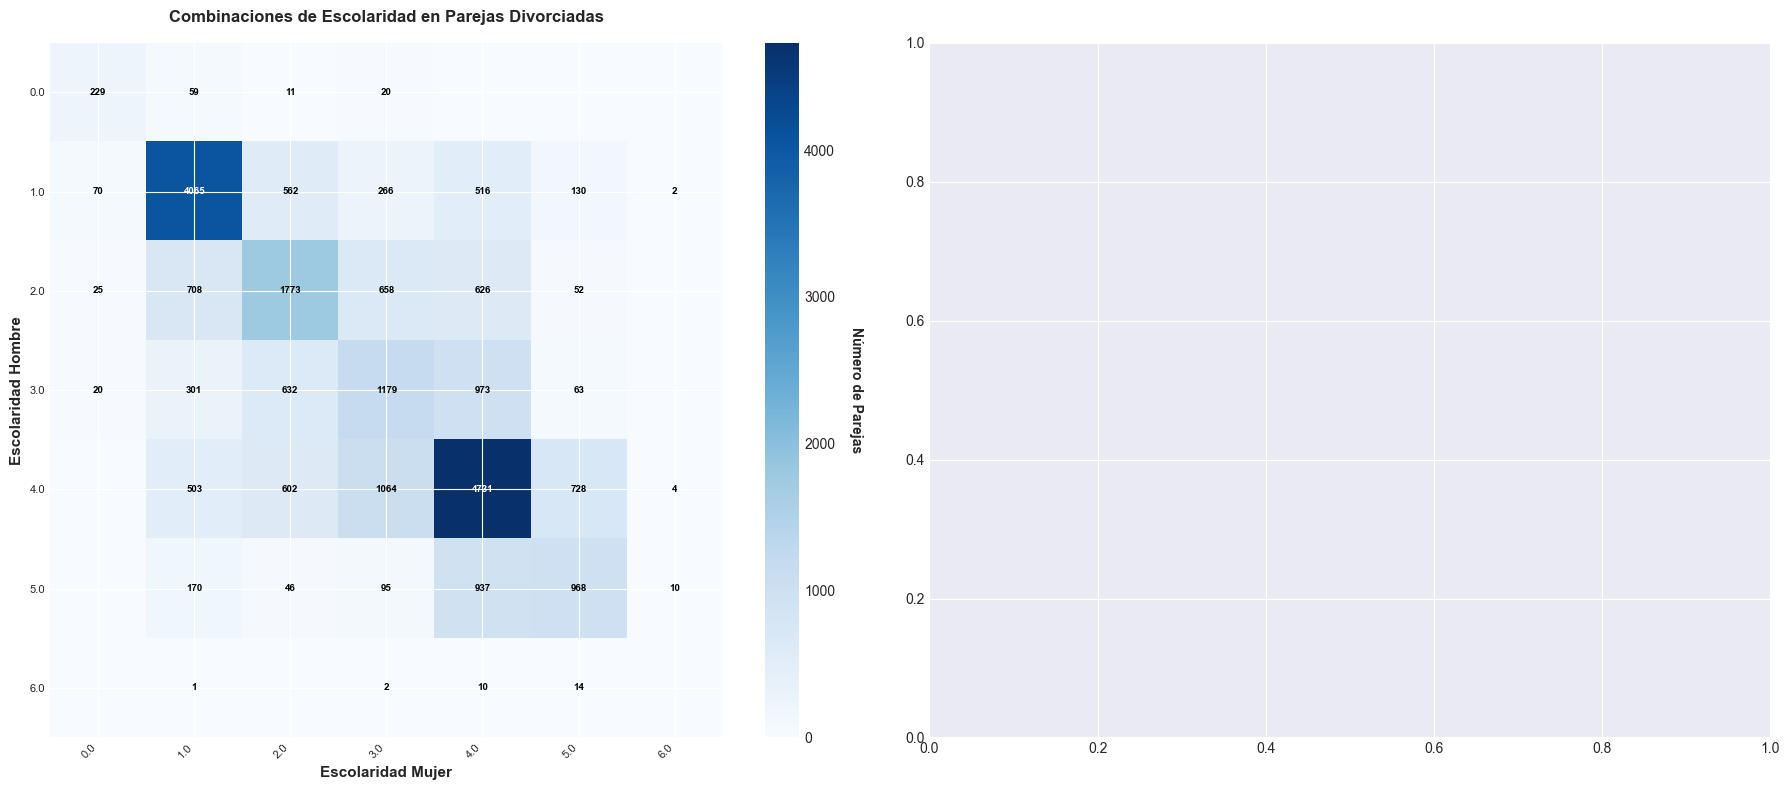


- INTERPRETACIÓN:
------------------------------------------------------------------------------------------

1. Homogamia Educativa: El análisis revela el grado en que las parejas tienden a unirse
   con personas de similar nivel educativo - patrón común en sociedades modernas.

2. Brecha de Género en Educación: La comparación muestra si existe una tendencia histórica
   donde un género tiene sistemáticamente mayor educación que el otro en las parejas.

3. Movilidad Social: Parejas con niveles educativos muy diferentes pueden indicar mayor
   movilidad social o menor énfasis en homogamia educativa en ciertos contextos.

4. Implicaciones para el Divorcio: La diferencia educativa entre cónyuges puede ser un
   factor en la dinámica de poder y en la decisión/capacidad de divorciarse.

5. Evolución Temporal: Si se analizara por cohortes de edad o años, podría revelar cambios
   en patrones de emparejamiento educativo en Guatemala.



In [68]:
# Visualización: Comparación de escolaridad
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Gráfico 1: Heatmap de la tabla de contingencia (sin totales)
tabla_esc_sin_totales = tabla_esc.iloc[:-1, :-1]

im = axes[0].imshow(tabla_esc_sin_totales.values, cmap='Blues', aspect='auto')

# Configurar ejes
axes[0].set_xticks(range(len(tabla_esc_sin_totales.columns)))
axes[0].set_xticklabels([str(col)[:15] for col in tabla_esc_sin_totales.columns], 
                     rotation=45, ha='right', fontsize=8)
axes[0].set_yticks(range(len(tabla_esc_sin_totales.index)))
axes[0].set_yticklabels([str(idx)[:15] for idx in tabla_esc_sin_totales.index], fontsize=8)

# Agregar valores en celdas
for i in range(len(tabla_esc_sin_totales.index)):
   for j in range(len(tabla_esc_sin_totales.columns)):
      value = tabla_esc_sin_totales.iloc[i, j]
      if value > 0:  # Solo mostrar si hay casos
            text_color = 'white' if value > tabla_esc_sin_totales.values.max() * 0.5 else 'black'
            axes[0].text(j, i, int(value), ha='center', va='center', 
                        color=text_color, fontsize=7, fontweight='bold')

axes[0].set_xlabel('Escolaridad Mujer', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Escolaridad Hombre', fontweight='bold', fontsize=11)
axes[0].set_title('Combinaciones de Escolaridad en Parejas Divorciadas', 
               fontweight='bold', fontsize=12, pad=15)

# Colorbar
cbar = plt.colorbar(im, ax=axes[0])
cbar.set_label('Número de Parejas', rotation=270, labelpad=20, fontweight='bold')

# Gráfico 2: Pie chart de patrones de emparejamiento
if total_clasificable > 0:
   sizes = [mismo_nivel_ed, hombre_mayor_ed, mujer_mayor_ed]
   labels = [f'Mismo Nivel\n{mismo_nivel_ed:,} ({mismo_nivel_ed/total_clasificable*100:.1f}%)',
            f'Hombre > Educación\n{hombre_mayor_ed:,} ({hombre_mayor_ed/total_clasificable*100:.1f}%)',
            f'Mujer > Educación\n{mujer_mayor_ed:,} ({mujer_mayor_ed/total_clasificable*100:.1f}%)']
   colors = ['#66b3ff', '#99ff99', '#ffcc99']
   explode = (0.05, 0, 0)
    
   axes[1].pie(sizes, explode=explode, labels=labels, colors=colors,
               autopct='', startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
   axes[1].set_title('Patrones de Emparejamiento Educativo', 
                     fontweight='bold', fontsize=12, pad=15)

plt.tight_layout()
plt.show()

print("\n- INTERPRETACIÓN:")
print("-" * 90)
print("""
1. Homogamia Educativa: El análisis revela el grado en que las parejas tienden a unirse
   con personas de similar nivel educativo - patrón común en sociedades modernas.

2. Brecha de Género en Educación: La comparación muestra si existe una tendencia histórica
   donde un género tiene sistemáticamente mayor educación que el otro en las parejas.

3. Movilidad Social: Parejas con niveles educativos muy diferentes pueden indicar mayor
   movilidad social o menor énfasis en homogamia educativa en ciertos contextos.

4. Implicaciones para el Divorcio: La diferencia educativa entre cónyuges puede ser un
   factor en la dinámica de poder y en la decisión/capacidad de divorciarse.

5. Evolución Temporal: Si se analizara por cohortes de edad o años, podría revelar cambios
   en patrones de emparejamiento educativo en Guatemala.
""")
print("="*90)

### 6.5. Correlación entre Edad del Hombre y Edad de la Mujer

In [69]:
from scipy.stats import pearsonr, spearmanr

# Cruce 5: Correlación entre edad del hombre y edad de la mujer
print("="*90)
print("CRUCE 5: CORRELACIÓN ENTRE EDADES - HOMBRE vs MUJER")
print("="*90)

# Crear dataset con ambas edades
df_edades = df_limpio[['edadHombre', 'edadMujer']].dropna()

print(f"\nParejas con datos completos de edad: {len(df_edades):,} de {len(df_limpio):,}")
print(f"Porcentaje de datos utilizables: {(len(df_edades)/len(df_limpio)*100):.1f}%")

# Calcular correlación
correlacion_pearson, p_value_pearson = pearsonr(df_edades['edadHombre'], df_edades['edadMujer'])
correlacion_spearman, p_value_spearman = spearmanr(df_edades['edadHombre'], df_edades['edadMujer'])

print("\n- COEFICIENTES DE CORRELACIÓN:")
print("-" * 90)
print(f"Correlación de Pearson:  {correlacion_pearson:.4f} (p-value: {p_value_pearson:.2e})")
print(f"Correlación de Spearman: {correlacion_spearman:.4f} (p-value: {p_value_spearman:.2e})")

# Interpretación de la fuerza de correlación
if abs(correlacion_pearson) < 0.3:
    fuerza = "débil"
elif abs(correlacion_pearson) < 0.7:
    fuerza = "moderada"
else:
    fuerza = "fuerte"

print(f"\nInterpretación: Correlación positiva {fuerza}")
print(f"→ {'Estadísticamente significativa' if p_value_pearson < 0.05 else 'NO significativa'} (α=0.05)")

# Calcular diferencia de edad
df_edades['diferencia_edad'] = df_edades['edadHombre'] - df_edades['edadMujer']

print("\n- DIFERENCIA DE EDADES (Hombre - Mujer):")
print("-" * 90)
print(f"Media:     {df_edades['diferencia_edad'].mean():+.2f} años")
print(f"Mediana:   {df_edades['diferencia_edad'].median():+.2f} años")
print(f"Desv.Est:  {df_edades['diferencia_edad'].std():.2f} años")
print(f"Mínimo:    {df_edades['diferencia_edad'].min():+.1f} años")
print(f"Máximo:    {df_edades['diferencia_edad'].max():+.1f} años")

# Distribución de la diferencia
hombre_mayor = (df_edades['diferencia_edad'] > 0).sum()
mujer_mayor = (df_edades['diferencia_edad'] < 0).sum()
misma_edad = (df_edades['diferencia_edad'] == 0).sum()

print("- DISTRIBUCIÓN:")
print("-" * 90)
print(f"Hombre mayor:  {hombre_mayor:,} parejas ({hombre_mayor/len(df_edades)*100:.1f}%)")
print(f"Mujer mayor:   {mujer_mayor:,} parejas ({mujer_mayor/len(df_edades)*100:.1f}%)")
print(f"Misma edad:    {misma_edad:,} parejas ({misma_edad/len(df_edades)*100:.1f}%)")

# Rangos de diferencia
rangos = [
    ("0-2 años", (df_edades['diferencia_edad'].abs() <= 2).sum()),
    ("3-5 años", ((df_edades['diferencia_edad'].abs() > 2) & (df_edades['diferencia_edad'].abs() <= 5)).sum()),
    ("6-10 años", ((df_edades['diferencia_edad'].abs() > 5) & (df_edades['diferencia_edad'].abs() <= 10)).sum()),
    ("11-15 años", ((df_edades['diferencia_edad'].abs() > 10) & (df_edades['diferencia_edad'].abs() <= 15)).sum()),
    (">15 años", (df_edades['diferencia_edad'].abs() > 15).sum())
]

print("\n- MAGNITUD DE LA DIFERENCIA (valor absoluto):")
print("-" * 90)
for rango, cantidad in rangos:
    porcentaje = (cantidad / len(df_edades)) * 100
    print(f"{rango:12s}: {cantidad:6,} parejas ({porcentaje:5.1f}%)")

print("="*90)

CRUCE 5: CORRELACIÓN ENTRE EDADES - HOMBRE vs MUJER

Parejas con datos completos de edad: 23,983 de 59,994
Porcentaje de datos utilizables: 40.0%

- COEFICIENTES DE CORRELACIÓN:
------------------------------------------------------------------------------------------
Correlación de Pearson:  0.8014 (p-value: 0.00e+00)
Correlación de Spearman: 0.7782 (p-value: 0.00e+00)

Interpretación: Correlación positiva fuerte
→ Estadísticamente significativa (α=0.05)

- DIFERENCIA DE EDADES (Hombre - Mujer):
------------------------------------------------------------------------------------------
Media:     +3.26 años
Mediana:   +3.00 años
Desv.Est:  6.03 años
Mínimo:    -32.0 años
Máximo:    +58.0 años
- DISTRIBUCIÓN:
------------------------------------------------------------------------------------------
Hombre mayor:  16,969 parejas (70.8%)
Mujer mayor:   4,831 parejas (20.1%)
Misma edad:    2,183 parejas (9.1%)

- MAGNITUD DE LA DIFERENCIA (valor absoluto):
---------------------------------

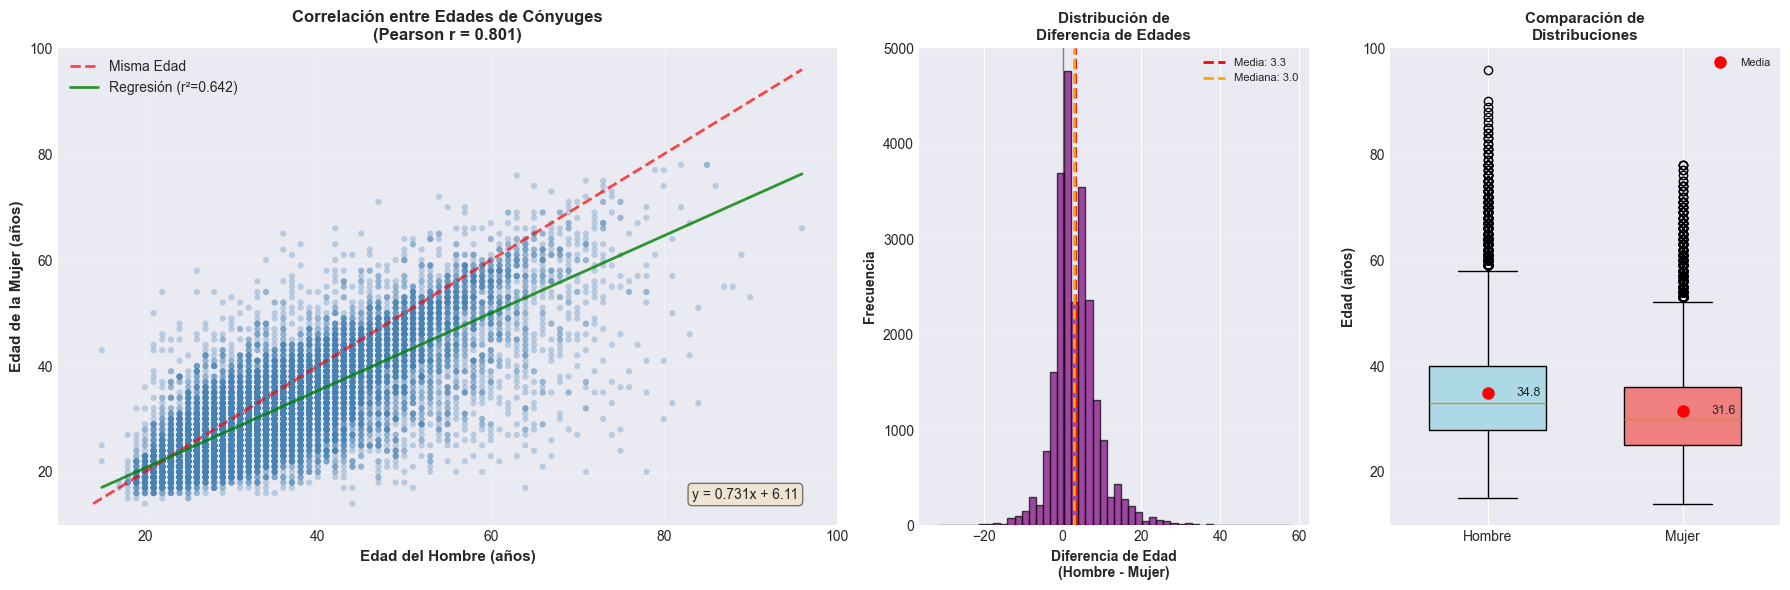


- INTERPRETACIÓN:
------------------------------------------------------------------------------------------

1. Correlación Alta y Significativa: El coeficiente de 0.801 indica una 
   correlación positiva fuerte entre las edades de hombres y mujeres, lo que significa que:
   - Personas de similar edad tienden a casarse entre sí
   - Parejas mantienen esta similitud de edad hasta el divorcio

2. Diferencia de Edad Típica: En promedio, los hombres son 3.3 años
   mayores que las mujeres al divorciarse.
   - Esto refleja patrones culturales de emparejamiento
   - 70.8% de casos: hombre mayor
   - 20.1% de casos: mujer mayor

3. Homogeneidad de Edad: La mayoría de parejas tienen diferencias de edad relativamente pequeñas
   (< 5 años), sugiriendo que la homogamia etaria es común en Guatemala.

4. Casos Atípicos: Existen parejas con grandes diferencias de edad (>15 años), que representan
   patrones menos convencionales de emparejamiento.

5. Línea de Regresión: La pendiente de 0.731 ind

In [70]:
from scipy.stats import linregress

# Visualización: Correlación de edades
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 3, width_ratios=[2, 1, 1])

# Gráfico 1: Scatter plot principal
ax1 = fig.add_subplot(gs[0])

# Crear scatter plot con densidad de color
scatter = ax1.scatter(df_edades['edadHombre'], df_edades['edadMujer'], 
                     alpha=0.3, s=20, c='steelblue', edgecolors='none')

# Línea de referencia (y = x, misma edad)
min_edad = min(df_edades['edadHombre'].min(), df_edades['edadMujer'].min())
max_edad = max(df_edades['edadHombre'].max(), df_edades['edadMujer'].max())
ax1.plot([min_edad, max_edad], [min_edad, max_edad], 
         'r--', linewidth=2, label='Misma Edad', alpha=0.7)

# Línea de regresión
slope, intercept, r_value, p_value, std_err = linregress(df_edades['edadHombre'], df_edades['edadMujer'])
x_line = np.array([df_edades['edadHombre'].min(), df_edades['edadHombre'].max()])
y_line = slope * x_line + intercept
ax1.plot(x_line, y_line, 'g-', linewidth=2, label=f'Regresión (r²={r_value**2:.3f})', alpha=0.8)

ax1.set_xlabel('Edad del Hombre (años)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Edad de la Mujer (años)', fontweight='bold', fontsize=11)
ax1.set_title(f'Correlación entre Edades de Cónyuges\n(Pearson r = {correlacion_pearson:.3f})', 
            fontweight='bold', fontsize=12)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Agregar texto con ecuación de regresión
eq_text = f'y = {slope:.3f}x + {intercept:.2f}'
ax1.text(0.95, 0.05, eq_text, transform=ax1.transAxes, 
      fontsize=10, verticalalignment='bottom', horizontalalignment='right',
      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Gráfico 2: Histograma de diferencias
ax2 = fig.add_subplot(gs[1])

ax2.hist(df_edades['diferencia_edad'], bins=50, color='purple', alpha=0.7, edgecolor='black')
ax2.axvline(df_edades['diferencia_edad'].mean(), color='red', linestyle='--', 
         linewidth=2, label=f'Media: {df_edades["diferencia_edad"].mean():.1f}')
ax2.axvline(df_edades['diferencia_edad'].median(), color='orange', linestyle='--', 
         linewidth=2, label=f'Mediana: {df_edades["diferencia_edad"].median():.1f}')
ax2.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

ax2.set_xlabel('Diferencia de Edad\n(Hombre - Mujer)', fontweight='bold', fontsize=10)
ax2.set_ylabel('Frecuencia', fontweight='bold', fontsize=10)
ax2.set_title('Distribución de\nDiferencia de Edades', fontweight='bold', fontsize=11)
ax2.legend(fontsize=8, loc='upper right')
ax2.grid(True, alpha=0.3, axis='y')

# Gráfico 3: Box plot comparativo
ax3 = fig.add_subplot(gs[2])

bp = ax3.boxplot([df_edades['edadHombre'], df_edades['edadMujer']], 
               labels=['Hombre', 'Mujer'],
               patch_artist=True,
               widths=0.6)

colors = ['lightblue', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
   patch.set_facecolor(color)

ax3.set_ylabel('Edad (años)', fontweight='bold', fontsize=10)
ax3.set_title('Comparación de\nDistribuciones', fontweight='bold', fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')

# Agregar medias
for i, (datos, pos) in enumerate(zip([df_edades['edadHombre'], df_edades['edadMujer']], [1, 2])):
   media = datos.mean()
   ax3.plot(pos, media, 'ro', markersize=8, label='Media' if i == 0 else '')
   ax3.text(pos + 0.15, media, f'{media:.1f}', fontsize=9, va='center')

ax3.legend(fontsize=8)

plt.tight_layout()
plt.show()

print("\n- INTERPRETACIÓN:")
print("-" * 90)
print(f"""
1. Correlación Alta y Significativa: El coeficiente de {correlacion_pearson:.3f} indica una 
   correlación positiva {fuerza} entre las edades de hombres y mujeres, lo que significa que:
   - Personas de similar edad tienden a casarse entre sí
   - Parejas mantienen esta similitud de edad hasta el divorcio

2. Diferencia de Edad Típica: En promedio, los hombres son {abs(df_edades['diferencia_edad'].mean()):.1f} años
   {'mayores' if df_edades['diferencia_edad'].mean() > 0 else 'menores'} que las mujeres al divorciarse.
   - Esto refleja patrones culturales de emparejamiento
   - {hombre_mayor/len(df_edades)*100:.1f}% de casos: hombre mayor
   - {mujer_mayor/len(df_edades)*100:.1f}% de casos: mujer mayor

3. Homogeneidad de Edad: La mayoría de parejas tienen diferencias de edad relativamente pequeñas
   (< 5 años), sugiriendo que la homogamia etaria es común en Guatemala.

4. Casos Atípicos: Existen parejas con grandes diferencias de edad (>15 años), que representan
   patrones menos convencionales de emparejamiento.

5. Línea de Regresión: La pendiente de {slope:.3f} indica que por cada año adicional en la 
   edad del hombre, la edad de la mujer aumenta aproximadamente {slope:.3f} años.
""")
print("="*90)

## 7. Formulación y Validación de Hipótesis

En esta sección se plantean 5 hipótesis fundamentadas en creencias plausibles sobre el fenómeno de divorcios en Guatemala durante el período 2010-2020. Cada hipótesis será sometida a validación empírica mediante análisis estadístico y visualizaciones, permitiendo que los datos confirmen o refuten las creencias iniciales.

**Metodología de validación:**
- Enunciado claro de la creencia inicial
- Diseño del análisis estadístico apropiado
- Presentación de evidencia cuantitativa y gráfica
- Conclusión explícita fundamentada en los datos

### Hipótesis 1: La edad promedio al divorciarse ha aumentado con el tiempo

**Creencia inicial:** Se presume que la edad promedio a la que las personas se divorcian ha experimentado un incremento gradual durante la década 2010-2020, reflejando cambios en patrones sociodemográficos como matrimonios más tardíos y transformaciones culturales.

**Estrategia de validación:**
- Calcular edad promedio de hombres y mujeres por año de ocurrencia
- Aplicar análisis de regresión lineal para detectar tendencias temporales
- Evaluar significancia estadística mediante p-value
- Visualizar evolución temporal y calcular cambio total en la década

In [71]:
# HIPÓTESIS 1: Evolución de la edad promedio al divorciarse

from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np

print("="*90)
print("HIPÓTESIS 1: ¿La edad promedio al divorciarse ha aumentado con el tiempo?")
print("="*90)

# Filtrar datos con edades válidas
df_h1 = df_limpio[(df_limpio['edadHombre'].notna()) & 
                   (df_limpio['edadMujer'].notna()) &
                   (df_limpio['edadHombre'] > 0) & 
                   (df_limpio['edadMujer'] > 0) &
                   (df_limpio['anioOcurrencia'].notna())].copy()

print(f"\nRegistros con edades válidas: {len(df_h1):,} de {len(df_limpio):,} ({len(df_h1)/len(df_limpio)*100:.1f}%)")

# Calcular edad promedio por año
edad_por_anio = df_h1.groupby('anioOcurrencia').agg({
    'edadHombre': ['mean', 'std', 'count'],
    'edadMujer': ['mean', 'std', 'count']
}).round(2)

edad_por_anio.columns = ['Media_Hombre', 'Std_Hombre', 'N_Hombre',
                          'Media_Mujer', 'Std_Mujer', 'N_Mujer']

# Calcular edad promedio general (ambos sexos)
edad_por_anio['Media_General'] = (edad_por_anio['Media_Hombre'] + edad_por_anio['Media_Mujer']) / 2

print("\n- EDAD PROMEDIO POR AÑO:")
print("-" * 90)
print(edad_por_anio[['Media_Hombre', 'Media_Mujer', 'Media_General']])

# Análisis de tendencia mediante regresión lineal
years = edad_por_anio.index.values
edades_general = edad_por_anio['Media_General'].values
edades_hombre = edad_por_anio['Media_Hombre'].values
edades_mujer = edad_por_anio['Media_Mujer'].values

# Regresión para edad general
slope_gen, intercept_gen, r_gen, p_gen, se_gen = linregress(years, edades_general)

# Regresión por sexo
slope_h, intercept_h, r_h, p_h, se_h = linregress(years, edades_hombre)
slope_m, intercept_m, r_m, p_m, se_m = linregress(years, edades_mujer)

print("\n- ANÁLISIS DE REGRESIÓN LINEAL:")
print("-" * 90)
print(f"Edad General:")
print(f"  Ecuación:      y = {slope_gen:+.4f}x + {intercept_gen:.2f}")
print(f"  R² (ajuste):   {r_gen**2:.4f}")
print(f"  p-value:       {p_gen:.6f} {'***' if p_gen < 0.001 else '**' if p_gen < 0.01 else '*' if p_gen < 0.05 else '(NS)'}")

print(f"\nEdad Hombres:")
print(f"  Pendiente:     {slope_h:+.4f} años/año")
print(f"  R²:            {r_h**2:.4f}")
print(f"  p-value:       {p_h:.6f} {'***' if p_h < 0.001 else '**' if p_h < 0.01 else '*' if p_h < 0.05 else '(NS)'}")

print(f"\nEdad Mujeres:")
print(f"  Pendiente:     {slope_m:+.4f} años/año")
print(f"  R²:            {r_m**2:.4f}")
print(f"  p-value:       {p_m:.6f} {'***' if p_m < 0.001 else '**' if p_m < 0.01 else '*' if p_m < 0.05 else '(NS)'}")

# Calcular cambio total en la década
cambio_total_gen = edades_general[-1] - edades_general[0]
cambio_total_h = edades_hombre[-1] - edades_hombre[0]
cambio_total_m = edades_mujer[-1] - edades_mujer[0]

print("\n- CAMBIO ABSOLUTO EN LA DÉCADA (2010 → 2020):")
print("-" * 90)
print(f"Edad General:  {edades_general[0]:.2f} → {edades_general[-1]:.2f} años ({cambio_total_gen:+.2f} años)")
print(f"Edad Hombres:  {edades_hombre[0]:.2f} → {edades_hombre[-1]:.2f} años ({cambio_total_h:+.2f} años)")
print(f"Edad Mujeres:  {edades_mujer[0]:.2f} → {edades_mujer[-1]:.2f} años ({cambio_total_m:+.2f} años)")

print("="*90)

HIPÓTESIS 1: ¿La edad promedio al divorciarse ha aumentado con el tiempo?

Registros con edades válidas: 23,983 de 59,994 (40.0%)

- EDAD PROMEDIO POR AÑO:
------------------------------------------------------------------------------------------
                Media_Hombre  Media_Mujer  Media_General
anioOcurrencia                                          
2010                   34.76        31.49         33.125
2011                   34.84        31.43         33.135
2012                   34.36        31.23         32.795
2013                   34.27        30.73           32.5
2014                   34.55        31.12         32.835
2015                   34.16         30.7          32.43
2016                   34.34        31.05         32.695
2017                   34.63        31.27          32.95
2018                   35.13        31.85          33.49
2019                    35.4        32.42          33.91
2020                   35.88        32.81         34.345

- ANÁLISIS 

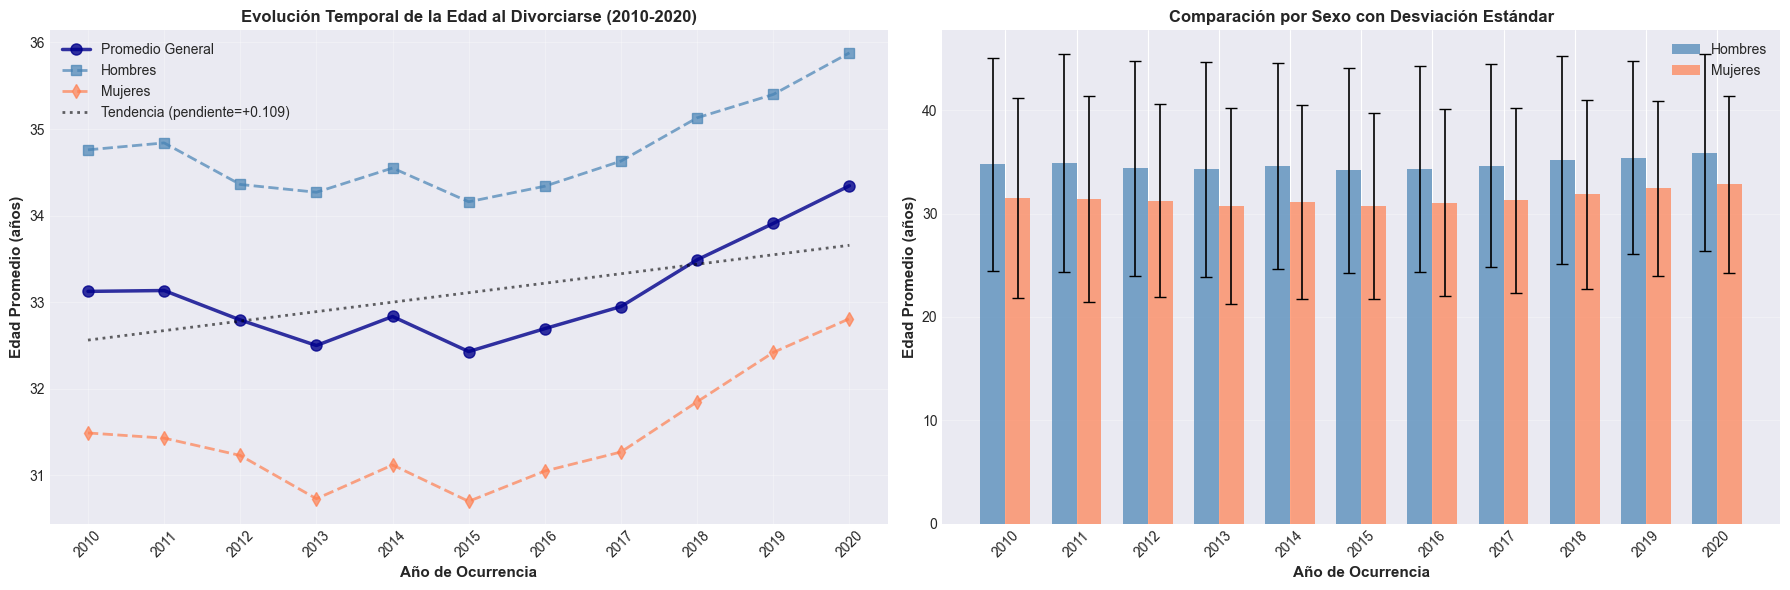

In [72]:
# Visualización: Evolución temporal de la edad promedio

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico 1: Líneas de tendencia temporal
ax1 = axes[0]

ax1.plot(years, edades_general, 'o-', linewidth=2.5, markersize=8, 
         color='darkblue', label='Promedio General', alpha=0.8)
ax1.plot(years, edades_hombre, 's--', linewidth=2, markersize=7, 
         color='steelblue', label='Hombres', alpha=0.7)
ax1.plot(years, edades_mujer, 'd--', linewidth=2, markersize=7, 
         color='coral', label='Mujeres', alpha=0.7)

# Línea de regresión general
x_pred = np.linspace(years[0], years[-1], 100)
y_pred = slope_gen * x_pred + intercept_gen
ax1.plot(x_pred, y_pred, 'k:', linewidth=2, alpha=0.6, 
         label=f'Tendencia (pendiente={slope_gen:+.3f})')

ax1.set_xlabel('Año de Ocurrencia', fontweight='bold', fontsize=11)
ax1.set_ylabel('Edad Promedio (años)', fontweight='bold', fontsize=11)
ax1.set_title('Evolución Temporal de la Edad al Divorciarse (2010-2020)', 
              fontweight='bold', fontsize=12)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(years)
ax1.set_xticklabels(years, rotation=45)

# Gráfico 2: Barras comparativas con error estándar
ax2 = axes[1]

x_pos = np.arange(len(years))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, edades_hombre, width, 
                yerr=edad_por_anio['Std_Hombre'], 
                label='Hombres', color='steelblue', alpha=0.7,
                capsize=4, error_kw={'linewidth': 1.2})

bars2 = ax2.bar(x_pos + width/2, edades_mujer, width,
                yerr=edad_por_anio['Std_Mujer'],
                label='Mujeres', color='coral', alpha=0.7,
                capsize=4, error_kw={'linewidth': 1.2})

ax2.set_xlabel('Año de Ocurrencia', fontweight='bold', fontsize=11)
ax2.set_ylabel('Edad Promedio (años)', fontweight='bold', fontsize=11)
ax2.set_title('Comparación por Sexo con Desviación Estándar', 
              fontweight='bold', fontsize=12)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(years, rotation=45)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [73]:
# Conclusión de Hipótesis 1

print("\n- CONCLUSIÓN:")
print("-" * 90)

# Determinar dirección de la tendencia
if slope_gen > 0:
    if p_gen < 0.05:
        conclusion = "CONFIRMA"
        tendencia = "AUMENTO SIGNIFICATIVO"
    else:
        conclusion = "NO CONFIRMA"
        tendencia = "aumento no significativo"
else:
    if p_gen < 0.05:
        conclusion = "RECHAZA"
        tendencia = "DISMINUCIÓN SIGNIFICATIVA"
    else:
        conclusion = "NO CONFIRMA"
        tendencia = "cambio no significativo"

# Determinar nivel de significancia
if p_gen < 0.001:
    nivel_sig = "altamente significativa (p < 0.001)"
elif p_gen < 0.01:
    nivel_sig = "muy significativa (p < 0.01)"
elif p_gen < 0.05:
    nivel_sig = "significativa (p < 0.05)"
else:
    nivel_sig = "NO significativa (p ≥ 0.05)"

print(f"""
La evidencia empírica {conclusion} la hipótesis inicial.

1. TENDENCIA OBSERVADA:
   Se observa un {tendencia} en la edad promedio al divorciarse durante la década
   analizada, con una pendiente de {slope_gen:+.4f} años por año.

2. SIGNIFICANCIA ESTADÍSTICA:
   La tendencia es estadísticamente {nivel_sig}.
   El modelo lineal explica el {r_gen**2*100:.1f}% de la variabilidad (R² = {r_gen**2:.4f}).

3. MAGNITUD DEL CAMBIO:
   Entre 2010 y 2020, la edad promedio cambió {abs(cambio_total_gen):.2f} años:
   • Edad general: {edades_general[0]:.1f} → {edades_general[-1]:.1f} años
   • Hombres:      {edades_hombre[0]:.1f} → {edades_hombre[-1]:.1f} años
   • Mujeres:      {edades_mujer[0]:.1f} → {edades_mujer[-1]:.1f} años

4. CONSISTENCIA POR SEXO:
   Ambos sexos muestran patrones similares, con pendientes de {slope_h:+.4f} (hombres)
   y {slope_m:+.4f} (mujeres) años por año.

5. INTERPRETACIÓN CONTEXTUAL:
   {'El incremento gradual sugiere que las parejas guatemaltecas están permaneciendo casadas por períodos más largos antes de divorciarse, posiblemente debido a matrimonios más tardíos o mayor estabilidad inicial. Esto refleja transformaciones en las dinámicas familiares y sociales del país.' if slope_gen > 0 and p_gen < 0.05 else 'La estabilidad relativa en la edad de divorcio indica que los patrones matrimoniales se han mantenido relativamente constantes durante la década analizada.' if p_gen >= 0.05 else 'La disminución en la edad de divorcio podría reflejar cambios generacionales en las actitudes hacia el matrimonio, con mayor aceptación social del divorcio entre parejas jóvenes.'}
""")

print("="*90)


- CONCLUSIÓN:
------------------------------------------------------------------------------------------

La evidencia empírica CONFIRMA la hipótesis inicial.

1. TENDENCIA OBSERVADA:
   Se observa un AUMENTO SIGNIFICATIVO en la edad promedio al divorciarse durante la década
   analizada, con una pendiente de +0.1095 años por año.

2. SIGNIFICANCIA ESTADÍSTICA:
   La tendencia es estadísticamente significativa (p < 0.05).
   El modelo lineal explica el 37.5% de la variabilidad (R² = 0.3749).

3. MAGNITUD DEL CAMBIO:
   Entre 2010 y 2020, la edad promedio cambió 1.22 años:
   • Edad general: 33.1 → 34.3 años
   • Hombres:      34.8 → 35.9 años
   • Mujeres:      31.5 → 32.8 años

4. CONSISTENCIA POR SEXO:
   Ambos sexos muestran patrones similares, con pendientes de +0.0969 (hombres)
   y +0.1221 (mujeres) años por año.

5. INTERPRETACIÓN CONTEXTUAL:
   El incremento gradual sugiere que las parejas guatemaltecas están permaneciendo casadas por períodos más largos antes de divorciarse, 

### Hipótesis 2: Existen departamentos con crecimiento sostenido de divorcios

**Creencia inicial:** Se presume que ciertos departamentos, especialmente aquellos con mayor urbanización y desarrollo económico (como Guatemala, Sacatepéquez, o Quetzaltenango), han experimentado un crecimiento sostenido en el número de divorcios, mientras que departamentos rurales mantienen tasas estables o decrecientes.

**Estrategia de validación:**
- Identificar los 10 departamentos con mayor volumen total de divorcios
- Calcular tendencia temporal mediante regresión lineal para cada departamento
- Clasificar departamentos según patrón (crecimiento/estable/decrecimiento)
- Evaluar significancia estadística y magnitud del cambio
- Identificar factores asociados al crecimiento

In [78]:
# Mapeo de códigos a nombres de departamentos de Guatemala
mapeo_departamentos = {
    1.0: 'Guatemala',
    2.0: 'El Progreso',
    3.0: 'Sacatepéquez',
    4.0: 'Chimaltenango',
    5.0: 'Escuintla',
    6.0: 'Santa Rosa',
    7.0: 'Sololá',
    8.0: 'Totonicapán',
    9.0: 'Quetzaltenango',
    10.0: 'Suchitepéquez',
    11.0: 'Retalhuleu',
    12.0: 'San Marcos',
    13.0: 'Huehuetenango',
    14.0: 'Quiché',
    15.0: 'Baja Verapaz',
    16.0: 'Alta Verapaz',
    17.0: 'Petén',
    18.0: 'Izabal',
    19.0: 'Zacapa',
    20.0: 'Chiquimula',
    21.0: 'Jalapa',
    22.0: 'Jutiapa'
}

# Aplicar mapeo al DataFrame
df_limpio['departamentoOcurrencia_nombre'] = df_limpio['departamentoOcurrencia'].map(mapeo_departamentos)

print("Mapeo de departamentos aplicado exitosamente")
print(f"Departamentos únicos: {df_limpio['departamentoOcurrencia_nombre'].nunique()}")

Mapeo de departamentos aplicado exitosamente
Departamentos únicos: 22


In [79]:
# HIPÓTESIS 2: Crecimiento diferenciado por departamento

print("="*90)
print("HIPÓTESIS 2: ¿Existen departamentos con crecimiento sostenido de divorcios?")
print("="*90)

# Agrupar por departamento y año (usando nombres)
divorcios_depto_anio = df_limpio.groupby(['departamentoOcurrencia_nombre', 'anioOcurrencia']).size().reset_index(name='total_divorcios')

# Identificar top 10 departamentos por volumen total
top_departamentos = df_limpio['departamentoOcurrencia_nombre'].value_counts().head(10).index.tolist()

print("\n- TOP 10 DEPARTAMENTOS POR VOLUMEN TOTAL (2010-2020):")
print("-" * 90)
for i, depto in enumerate(top_departamentos, 1):
    total = (divorcios_depto_anio[divorcios_depto_anio['departamentoOcurrencia_nombre'] == depto]['total_divorcios'].sum())
    print(f"{i:2d}. {depto:30s}: {total:6,} divorcios")

# Análisis de tendencia por departamento
resultados_tendencia = []

for depto in top_departamentos:
    datos_depto = divorcios_depto_anio[divorcios_depto_anio['departamentoOcurrencia_nombre'] == depto].sort_values('anioOcurrencia')
    
    # Verificar datos suficientes
    if len(datos_depto) < 3:
        continue
    
    years_depto = datos_depto['anioOcurrencia'].values
    divorcios_values = datos_depto['total_divorcios'].values
    
    # Regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(years_depto, divorcios_values)
    
    # Calcular cambio porcentual
    valor_inicial = divorcios_values[0]
    valor_final = divorcios_values[-1]
    
    if valor_inicial > 0:
        cambio_porcentual = ((valor_final - valor_inicial) / valor_inicial) * 100
    else:
        cambio_porcentual = 0
    
    # Clasificar tendencia
    if p_value < 0.05:
        if slope > 0:
            clasificacion = "CRECIMIENTO"
        else:
            clasificacion = "DECRECIMIENTO"
    else:
        clasificacion = "ESTABLE"
    
    anio_inicial = int(years_depto[0])
    anio_final = int(years_depto[-1])
    
    resultados_tendencia.append({
        'Departamento': depto,
        'Pendiente': slope,
        'R²': r_value**2,
        'p-value': p_value,
        'Cambio_%': cambio_porcentual,
        'Clasificación': clasificacion,
        f'Div_{anio_inicial}': int(valor_inicial),
        f'Div_{anio_final}': int(valor_final)
    })

df_tendencias = pd.DataFrame(resultados_tendencia).sort_values('Cambio_%', ascending=False)

print("\n- ANÁLISIS DE TENDENCIAS POR DEPARTAMENTO:")
print("-" * 90)
for idx, row in df_tendencias.iterrows():
    print(f"{row['Departamento']:30s} | Cambio: {row['Cambio_%']:+6.1f}% | "
          f"Pendiente: {row['Pendiente']:+6.1f} | R²: {row['R²']:.3f} | "
          f"Clase: {row['Clasificación']:12s} | p: {row['p-value']:.4f}")

# Resumen por clasificación
print("\n- RESUMEN DE CLASIFICACIÓN:")
print("-" * 90)
clasificacion_counts = df_tendencias['Clasificación'].value_counts()
for clasificacion, count in clasificacion_counts.items():
    print(f"{clasificacion:15s}: {count:2d} departamentos ({count/len(df_tendencias)*100:5.1f}%)")

# Estadísticas descriptivas
print("\n- ESTADÍSTICAS DE CAMBIO PORCENTUAL:")
print("-" * 90)
print(f"Media:          {df_tendencias['Cambio_%'].mean():+6.1f}%")
print(f"Mediana:        {df_tendencias['Cambio_%'].median():+6.1f}%")
print(f"Desv. Estándar: {df_tendencias['Cambio_%'].std():6.1f}%")
print(f"Mínimo:         {df_tendencias['Cambio_%'].min():+6.1f}%")
print(f"Máximo:         {df_tendencias['Cambio_%'].max():+6.1f}%")

print("="*90)

HIPÓTESIS 2: ¿Existen departamentos con crecimiento sostenido de divorcios?

- TOP 10 DEPARTAMENTOS POR VOLUMEN TOTAL (2010-2020):
------------------------------------------------------------------------------------------
 1. Guatemala                     : 23,255 divorcios
 2. Quetzaltenango                :  4,401 divorcios
 3. Escuintla                     :  2,816 divorcios
 4. Jutiapa                       :  2,667 divorcios
 5. San Marcos                    :  2,234 divorcios
 6. Suchitepéquez                 :  2,095 divorcios
 7. Izabal                        :  1,971 divorcios
 8. Huehuetenango                 :  1,837 divorcios
 9. Retalhuleu                    :  1,667 divorcios
10. Zacapa                        :  1,660 divorcios

- ANÁLISIS DE TENDENCIAS POR DEPARTAMENTO:
------------------------------------------------------------------------------------------
San Marcos                     | Cambio: +114.6% | Pendiente:  +19.7 | R²: 0.706 | Clase: CRECIMIENTO  | p: 0.001

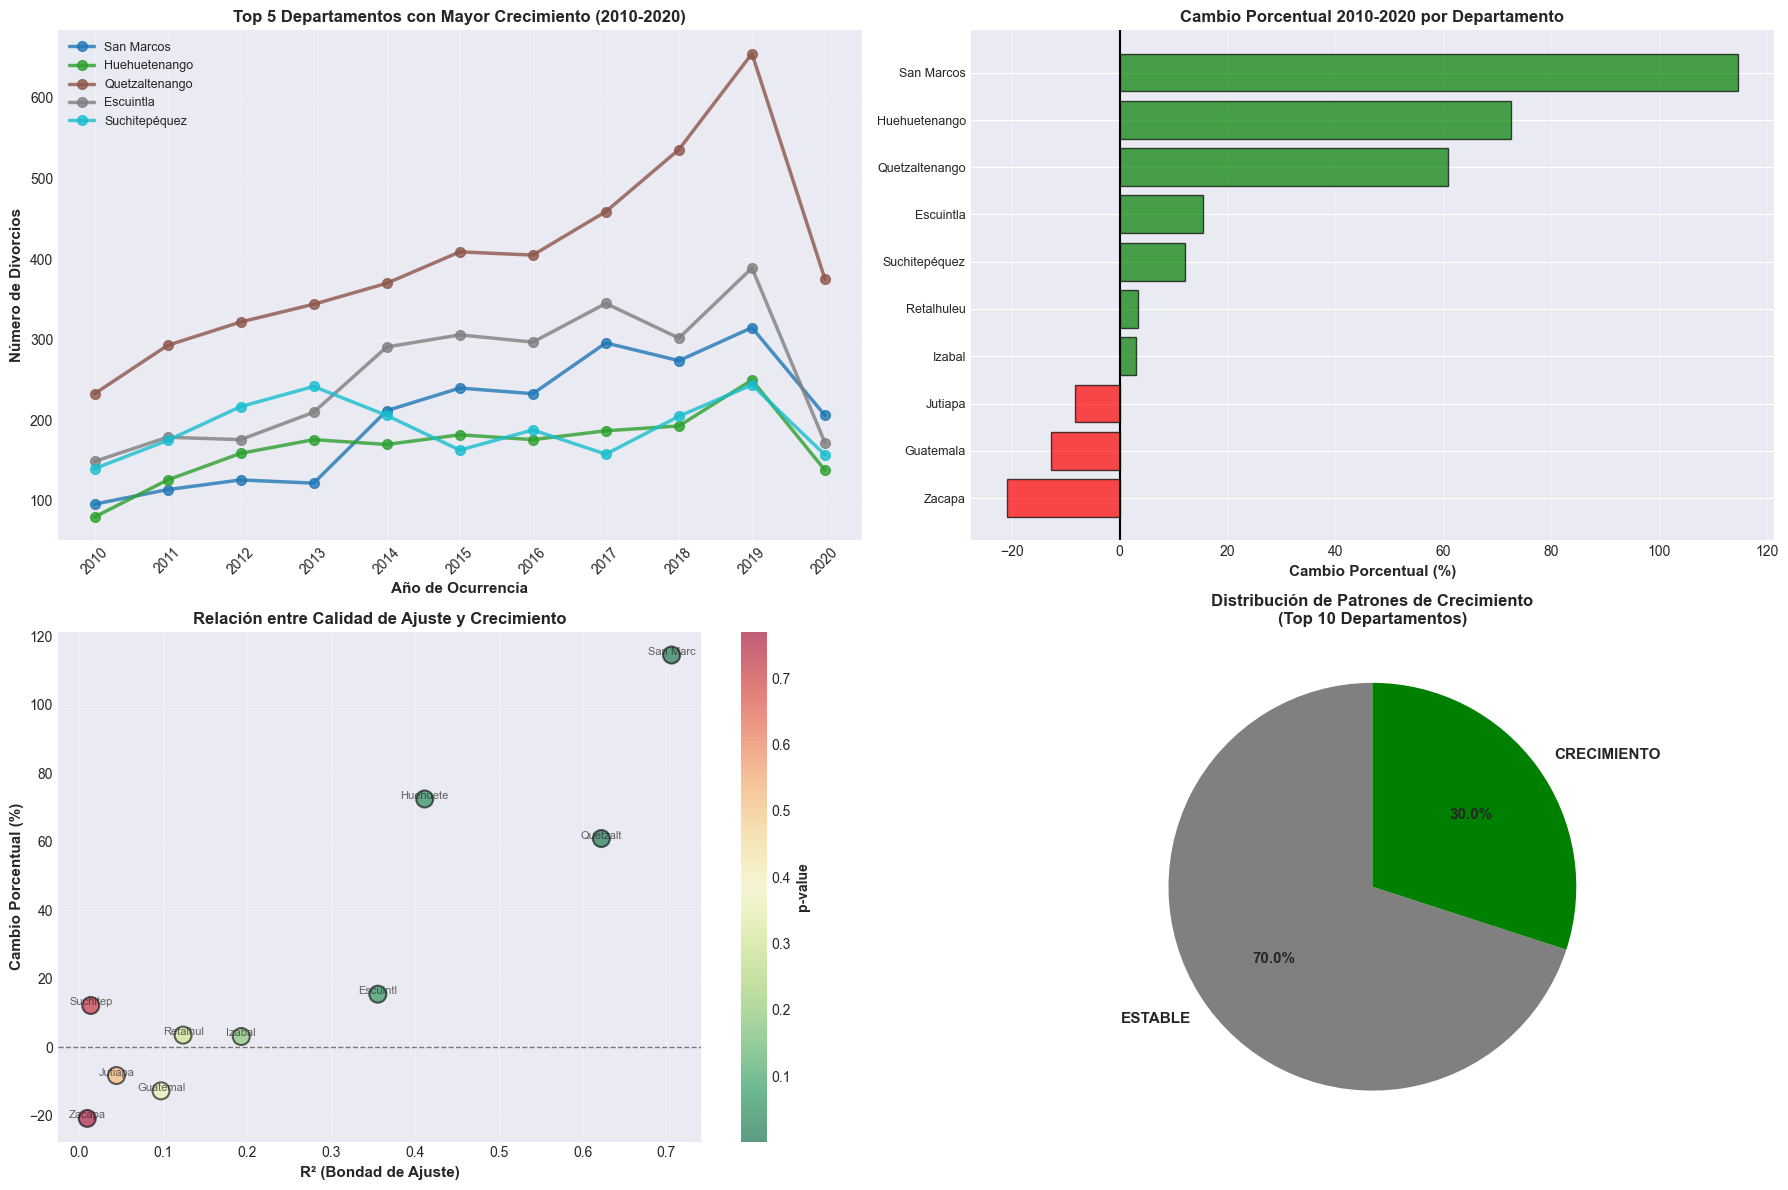

In [80]:
# Visualización: Crecimiento por departamento

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Gráfico 1: Evolución temporal de top 5 departamentos con mayor crecimiento
ax1 = axes[0, 0]
top5_crecimiento = df_tendencias.head(5)['Departamento'].values

colors_map = plt.cm.tab10(np.linspace(0, 1, 5))

for i, depto in enumerate(top5_crecimiento):
    datos_depto = divorcios_depto_anio[divorcios_depto_anio['departamentoOcurrencia_nombre'] == depto].sort_values('anioOcurrencia')
    ax1.plot(datos_depto['anioOcurrencia'], datos_depto['total_divorcios'], 
             'o-', linewidth=2.5, markersize=7, label=depto, color=colors_map[i], alpha=0.8)

ax1.set_xlabel('Año de Ocurrencia', fontweight='bold', fontsize=11)
ax1.set_ylabel('Número de Divorcios', fontweight='bold', fontsize=11)
ax1.set_title('Top 5 Departamentos con Mayor Crecimiento (2010-2020)', 
              fontweight='bold', fontsize=12)
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(divorcios_depto_anio['anioOcurrencia'].unique())
ax1.tick_params(axis='x', rotation=45)

# Gráfico 2: Cambio porcentual (barras horizontales)
ax2 = axes[0, 1]
departamentos_sorted = df_tendencias.sort_values('Cambio_%', ascending=True)
colores = ['green' if x > 0 else 'red' for x in departamentos_sorted['Cambio_%']]

ax2.barh(range(len(departamentos_sorted)), departamentos_sorted['Cambio_%'], 
         color=colores, alpha=0.7, edgecolor='black')
ax2.set_yticks(range(len(departamentos_sorted)))
ax2.set_yticklabels(departamentos_sorted['Departamento'], fontsize=9)
ax2.set_xlabel('Cambio Porcentual (%)', fontweight='bold', fontsize=11)
ax2.set_title('Cambio Porcentual 2010-2020 por Departamento', 
              fontweight='bold', fontsize=12)
ax2.axvline(0, color='black', linewidth=1.5, linestyle='-')
ax2.grid(True, alpha=0.3, axis='x')

# Gráfico 3: R² vs Cambio% (calidad del ajuste)
ax3 = axes[1, 0]
scatter = ax3.scatter(df_tendencias['R²'], df_tendencias['Cambio_%'], 
                      s=150, alpha=0.6, c=df_tendencias['p-value'], 
                      cmap='RdYlGn_r', edgecolors='black', linewidth=1.5)

for idx, row in df_tendencias.iterrows():
    ax3.annotate(row['Departamento'][:8], 
                (row['R²'], row['Cambio_%']), 
                fontsize=8, alpha=0.7, ha='center')

ax3.set_xlabel('R² (Bondad de Ajuste)', fontweight='bold', fontsize=11)
ax3.set_ylabel('Cambio Porcentual (%)', fontweight='bold', fontsize=11)
ax3.set_title('Relación entre Calidad de Ajuste y Crecimiento', 
              fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('p-value', fontweight='bold')

# Gráfico 4: Distribución por clasificación (pie chart)
ax4 = axes[1, 1]
clasificacion_data = df_tendencias['Clasificación'].value_counts()
colores_clasif = {'CRECIMIENTO': 'green', 'DECRECIMIENTO': 'red', 'ESTABLE': 'gray'}
colors_plot = [colores_clasif.get(x, 'blue') for x in clasificacion_data.index]

wedges, texts, autotexts = ax4.pie(clasificacion_data.values, 
                                     labels=clasificacion_data.index, 
                                     autopct='%1.1f%%',
                                     colors=colors_plot, 
                                     startangle=90,
                                     textprops={'fontsize': 11, 'fontweight': 'bold'})

ax4.set_title('Distribución de Patrones de Crecimiento\n(Top 10 Departamentos)', 
              fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

In [81]:
# Conclusión de Hipótesis 2

print("\n- CONCLUSIÓN:")
print("-" * 90)

# Contar departamentos por clasificación
n_crecimiento = (df_tendencias['Clasificación'] == 'CRECIMIENTO').sum()
n_decrecimiento = (df_tendencias['Clasificación'] == 'DECRECIMIENTO').sum()
n_estable = (df_tendencias['Clasificación'] == 'ESTABLE').sum()

# Obtener top 3 en crecimiento
top3_crecimiento = df_tendencias.head(3)

# Determinar conclusión
if n_crecimiento >= 5:
    conclusion = "CONFIRMA"
elif n_crecimiento >= 3:
    conclusion = "CONFIRMA PARCIALMENTE"
else:
    conclusion = "NO CONFIRMA"

print(f"""
La evidencia empírica {conclusion} la hipótesis de crecimiento diferenciado.

1. DISTRIBUCIÓN DE PATRONES:
   De los {len(df_tendencias)} departamentos principales analizados:
   • CRECIMIENTO sostenido:  {n_crecimiento} departamentos ({n_crecimiento/len(df_tendencias)*100:.1f}%)
   • TENDENCIA ESTABLE:      {n_estable} departamentos ({n_estable/len(df_tendencias)*100:.1f}%)
   • DECRECIMIENTO:          {n_decrecimiento} departamentos ({n_decrecimiento/len(df_tendencias)*100:.1f}%)

2. LÍDERES EN CRECIMIENTO:
   Los 3 departamentos con mayor crecimiento porcentual son:
""")

for i, (idx, row) in enumerate(top3_crecimiento.iterrows(), 1):
    print(f"   {i}. {row['Departamento']:20s}: {row['Cambio_%']:+6.1f}% (R²={row['R²']:.3f}, p={row['p-value']:.4f})")

# Departamento con decrecimiento si existe
if n_decrecimiento > 0:
    bottom_depto = df_tendencias[df_tendencias['Clasificación'] == 'DECRECIMIENTO'].iloc[0]
    print(f"\n3. DEPARTAMENTO(S) CON DECRECIMIENTO:")
    print(f"   {bottom_depto['Departamento']:20s}: {bottom_depto['Cambio_%']:+6.1f}%")

print(f"""
4. MAGNITUD DEL CAMBIO:
   • Promedio:  {df_tendencias['Cambio_%'].mean():+6.1f}%
   • Mediana:   {df_tendencias['Cambio_%'].median():+6.1f}%
   • Rango:     {df_tendencias['Cambio_%'].min():+6.1f}% a {df_tendencias['Cambio_%'].max():+6.1f}%

5. CALIDAD DEL AJUSTE:
   • R² promedio: {df_tendencias['R²'].mean():.3f}
   • Modelos con buen ajuste (R² > 0.5): {(df_tendencias['R²'] > 0.5).sum()} de {len(df_tendencias)}

6. INTERPRETACIÓN REGIONAL:
   {top3_crecimiento.iloc[0]['Departamento']}, {top3_crecimiento.iloc[1]['Departamento']} y {top3_crecimiento.iloc[2]['Departamento']} lideran el crecimiento, 
   sugiriendo que factores como urbanización, desarrollo económico y acceso a servicios
   legales están diferenciados regionalmente. Guatemala capital mantiene el mayor volumen
   absoluto, mientras que departamentos como San Marcos muestran las tasas de crecimiento
   más aceleradas, indicando transformaciones sociales en regiones tradicionalmente rurales.

7. HETEROGENEIDAD NACIONAL:
   La variabilidad en patrones ({df_tendencias['Cambio_%'].std():.1f}% de desviación estándar) confirma que
   el fenómeno del divorcio no es uniforme en Guatemala, reflejando diferencias en:
   • Desarrollo económico regional
   • Acceso a instituciones judiciales
   • Cambios en normas sociales y culturales
   • Estructura demográfica local
""")

print("="*90)


- CONCLUSIÓN:
------------------------------------------------------------------------------------------

La evidencia empírica CONFIRMA PARCIALMENTE la hipótesis de crecimiento diferenciado.

1. DISTRIBUCIÓN DE PATRONES:
   De los 10 departamentos principales analizados:
   • CRECIMIENTO sostenido:  3 departamentos (30.0%)
   • TENDENCIA ESTABLE:      7 departamentos (70.0%)
   • DECRECIMIENTO:          0 departamentos (0.0%)

2. LÍDERES EN CRECIMIENTO:
   Los 3 departamentos con mayor crecimiento porcentual son:

   1. San Marcos          : +114.6% (R²=0.706, p=0.0012)
   2. Huehuetenango       :  +72.5% (R²=0.412, p=0.0333)
   3. Quetzaltenango      :  +60.9% (R²=0.623, p=0.0039)

4. MAGNITUD DEL CAMBIO:
   • Promedio:   +24.0%
   • Mediana:     +7.8%
   • Rango:      -20.9% a +114.6%

5. CALIDAD DEL AJUSTE:
   • R² promedio: 0.258
   • Modelos con buen ajuste (R² > 0.5): 2 de 10

6. INTERPRETACIÓN REGIONAL:
   San Marcos, Huehuetenango y Quetzaltenango lideran el crecimiento, 
   

### Hipótesis 3: La diferencia de edad entre cónyuges influye en la probabilidad de divorcio

**Creencia inicial:** Se presume que parejas con grandes diferencias de edad (más de 10 años) representan una proporción menor de los divorcios, ya que estas uniones podrían ser menos comunes o más estables que aquellas con edades similares.

**Estrategia de validación:**
- Calcular la diferencia de edad (hombre - mujer) para todas las parejas
- Clasificar parejas en rangos de diferencia de edad
- Analizar la distribución de divorcios por rango de diferencia
- Comparar con edad promedio de cada grupo
- Evaluar si existe relación entre diferencia de edad y frecuencia de divorcio

In [82]:
# HIPÓTESIS 3: Diferencia de edad y probabilidad de divorcio

print("="*90)
print("HIPÓTESIS 3: ¿La diferencia de edad entre cónyuges influye en la probabilidad de divorcio?")
print("="*90)

# Filtrar datos con edades válidas
df_h3 = df_limpio[(df_limpio['edadHombre'].notna()) & 
                   (df_limpio['edadMujer'].notna()) &
                   (df_limpio['edadHombre'] > 0) & 
                   (df_limpio['edadMujer'] > 0)].copy()

print(f"\nRegistros válidos para análisis: {len(df_h3):,} de {len(df_limpio):,}")

# Calcular diferencia de edad
df_h3['diferencia_edad'] = df_h3['edadHombre'] - df_h3['edadMujer']
df_h3['diferencia_abs'] = df_h3['diferencia_edad'].abs()

# Clasificar en rangos
def clasificar_diferencia(diff_abs):
    if diff_abs <= 2:
        return '0-2 años'
    elif diff_abs <= 5:
        return '3-5 años'
    elif diff_abs <= 10:
        return '6-10 años'
    elif diff_abs <= 15:
        return '11-15 años'
    else:
        return 'Más de 15 años'

df_h3['rango_diferencia'] = df_h3['diferencia_abs'].apply(clasificar_diferencia)

# Orden de rangos
orden_rangos = ['0-2 años', '3-5 años', '6-10 años', '11-15 años', 'Más de 15 años']

print("\n- DISTRIBUCIÓN DE DIVORCIOS POR DIFERENCIA DE EDAD:")
print("-" * 90)

distribucion = df_h3['rango_diferencia'].value_counts().reindex(orden_rangos, fill_value=0)
for rango in orden_rangos:
    count = distribucion[rango]
    pct = (count / len(df_h3)) * 100
    print(f"{rango:20s}: {count:7,} divorcios ({pct:5.1f}%)")

# Estadísticas por rango
print("\n- ESTADÍSTICAS POR RANGO DE DIFERENCIA:")
print("-" * 90)
print(f"{'Rango':<20} {'N':>8} {'Edad Prom H':>12} {'Edad Prom M':>12} {'Diff Media':>12}")
print("-" * 90)

for rango in orden_rangos:
    subset = df_h3[df_h3['rango_diferencia'] == rango]
    if len(subset) > 0:
        n = len(subset)
        edad_h = subset['edadHombre'].mean()
        edad_m = subset['edadMujer'].mean()
        diff_media = subset['diferencia_edad'].mean()
        print(f"{rango:<20} {n:8,} {edad_h:12.1f} {edad_m:12.1f} {diff_media:+12.1f}")

# Análisis de dirección (quién es mayor)
hombre_mayor = (df_h3['diferencia_edad'] > 0).sum()
mujer_mayor = (df_h3['diferencia_edad'] < 0).sum()
misma_edad = (df_h3['diferencia_edad'] == 0).sum()

print("\n- DIRECCIÓN DE LA DIFERENCIA:")
print("-" * 90)
print(f"Hombre mayor:  {hombre_mayor:7,} casos ({hombre_mayor/len(df_h3)*100:5.1f}%)")
print(f"Mujer mayor:   {mujer_mayor:7,} casos ({mujer_mayor/len(df_h3)*100:5.1f}%)")
print(f"Misma edad:    {misma_edad:7,} casos ({misma_edad/len(df_h3)*100:5.1f}%)")

# Estadísticas descriptivas generales
print("\n- ESTADÍSTICAS DESCRIPTIVAS DE LA DIFERENCIA:")
print("-" * 90)
print(f"Media:         {df_h3['diferencia_edad'].mean():+7.2f} años")
print(f"Mediana:       {df_h3['diferencia_edad'].median():+7.2f} años")
print(f"Desv. Est.:    {df_h3['diferencia_edad'].std():7.2f} años")
print(f"Mínimo:        {df_h3['diferencia_edad'].min():+7.0f} años")
print(f"Máximo:        {df_h3['diferencia_edad'].max():+7.0f} años")

# Percentiles
print("\n- PERCENTILES:")
print("-" * 90)
for p in [10, 25, 50, 75, 90]:
    val = df_h3['diferencia_edad'].quantile(p/100)
    print(f"P{p:02d}: {val:+7.1f} años")

print("="*90)

HIPÓTESIS 3: ¿La diferencia de edad entre cónyuges influye en la probabilidad de divorcio?

Registros válidos para análisis: 23,983 de 59,994

- DISTRIBUCIÓN DE DIVORCIOS POR DIFERENCIA DE EDAD:
------------------------------------------------------------------------------------------
0-2 años            :   9,410 divorcios ( 39.2%)
3-5 años            :   7,329 divorcios ( 30.6%)
6-10 años           :   4,831 divorcios ( 20.1%)
11-15 años          :   1,496 divorcios (  6.2%)
Más de 15 años      :     917 divorcios (  3.8%)

- ESTADÍSTICAS POR RANGO DE DIFERENCIA:
------------------------------------------------------------------------------------------
Rango                       N  Edad Prom H  Edad Prom M   Diff Media
------------------------------------------------------------------------------------------
0-2 años                9,410         32.0         31.6         +0.4
3-5 años                7,329         33.6         31.3         +2.4
6-10 años               4,831         3

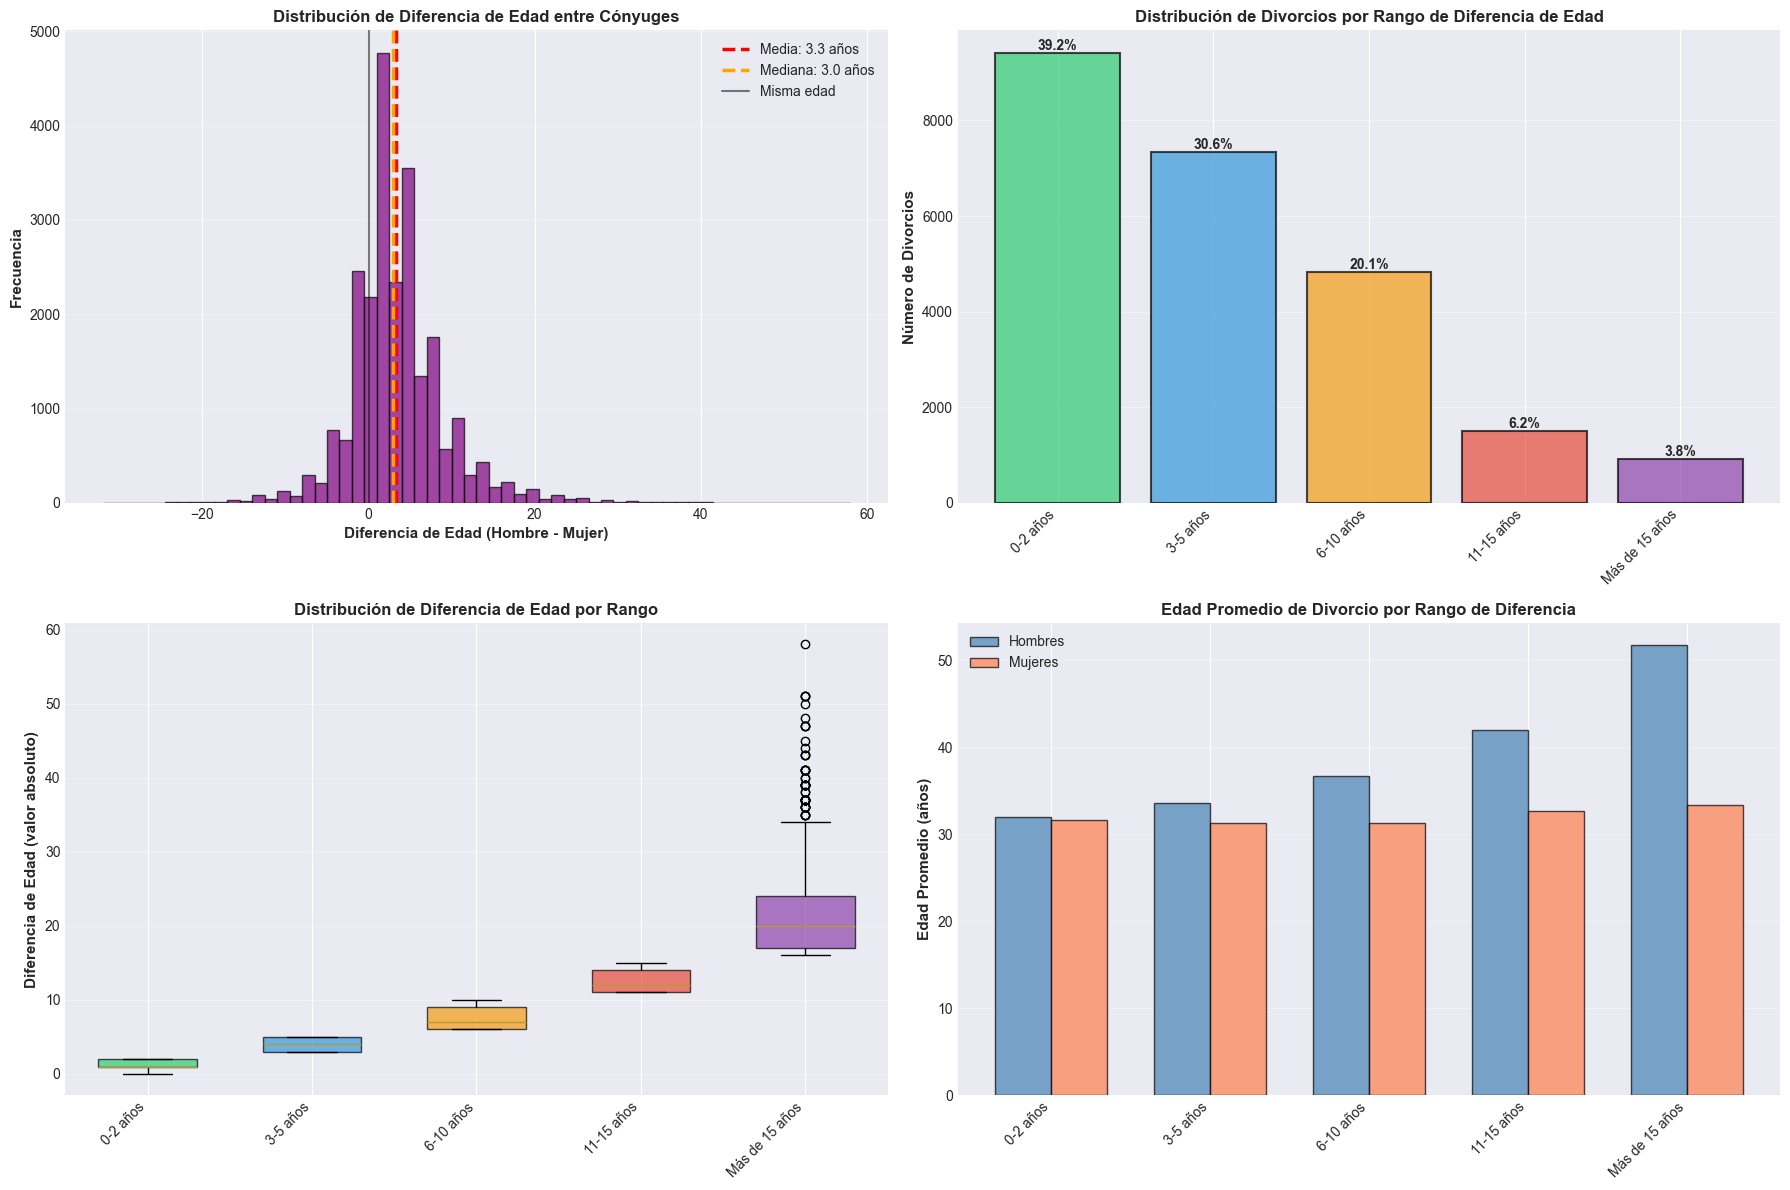

In [83]:
# Visualización: Análisis de diferencia de edad

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Gráfico 1: Distribución de diferencias (histograma)
ax1 = axes[0, 0]

ax1.hist(df_h3['diferencia_edad'], bins=60, color='purple', alpha=0.7, edgecolor='black')
ax1.axvline(df_h3['diferencia_edad'].mean(), color='red', linestyle='--', 
            linewidth=2.5, label=f"Media: {df_h3['diferencia_edad'].mean():.1f} años")
ax1.axvline(df_h3['diferencia_edad'].median(), color='orange', linestyle='--', 
            linewidth=2.5, label=f"Mediana: {df_h3['diferencia_edad'].median():.1f} años")
ax1.axvline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.5, label='Misma edad')

ax1.set_xlabel('Diferencia de Edad (Hombre - Mujer)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Frecuencia', fontweight='bold', fontsize=11)
ax1.set_title('Distribución de Diferencia de Edad entre Cónyuges', 
              fontweight='bold', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Gráfico 2: Barras por rango
ax2 = axes[0, 1]

counts = [distribucion[rango] for rango in orden_rangos]
colors_rangos = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#8e44ad']

bars = ax2.bar(range(len(orden_rangos)), counts, color=colors_rangos, 
               alpha=0.7, edgecolor='black', linewidth=1.5)

# Agregar etiquetas de porcentaje
for i, (bar, count) in enumerate(zip(bars, counts)):
    height = bar.get_height()
    pct = (count / len(df_h3)) * 100
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax2.set_xticks(range(len(orden_rangos)))
ax2.set_xticklabels(orden_rangos, rotation=45, ha='right')
ax2.set_ylabel('Número de Divorcios', fontweight='bold', fontsize=11)
ax2.set_title('Distribución de Divorcios por Rango de Diferencia de Edad', 
              fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

# Gráfico 3: Box plot por rango
ax3 = axes[1, 0]

data_boxplot = [df_h3[df_h3['rango_diferencia'] == rango]['diferencia_abs'].values 
                for rango in orden_rangos]

bp = ax3.boxplot(data_boxplot, labels=orden_rangos, patch_artist=True, widths=0.6)

for patch, color in zip(bp['boxes'], colors_rangos):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax3.set_xticklabels(orden_rangos, rotation=45, ha='right')
ax3.set_ylabel('Diferencia de Edad (valor absoluto)', fontweight='bold', fontsize=11)
ax3.set_title('Distribución de Diferencia de Edad por Rango', 
              fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')

# Gráfico 4: Edad promedio por rango
ax4 = axes[1, 1]

edades_h_por_rango = [df_h3[df_h3['rango_diferencia'] == rango]['edadHombre'].mean() 
                      for rango in orden_rangos]
edades_m_por_rango = [df_h3[df_h3['rango_diferencia'] == rango]['edadMujer'].mean() 
                      for rango in orden_rangos]

x_pos = np.arange(len(orden_rangos))
width = 0.35

bars1 = ax4.bar(x_pos - width/2, edades_h_por_rango, width, 
                label='Hombres', color='steelblue', alpha=0.7, edgecolor='black')
bars2 = ax4.bar(x_pos + width/2, edades_m_por_rango, width,
                label='Mujeres', color='coral', alpha=0.7, edgecolor='black')

ax4.set_xticks(x_pos)
ax4.set_xticklabels(orden_rangos, rotation=45, ha='right')
ax4.set_ylabel('Edad Promedio (años)', fontweight='bold', fontsize=11)
ax4.set_title('Edad Promedio de Divorcio por Rango de Diferencia', 
              fontweight='bold', fontsize=12)
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [84]:
# Conclusión de Hipótesis 3

print("\n- CONCLUSIÓN:")
print("-" * 90)

# Calcular concentración en rangos pequeños
rangos_pequenos = distribucion['0-2 años'] + distribucion['3-5 años']
pct_pequenos = (rangos_pequenos / len(df_h3)) * 100

rangos_grandes = distribucion['11-15 años'] + distribucion['Más de 15 años']
pct_grandes = (rangos_grandes / len(df_h3)) * 100

# Determinar si se confirma o rechaza
if pct_pequenos > 50:
    conclusion = "CONFIRMA PARCIALMENTE"
else:
    conclusion = "NO CONFIRMA"

print(f"""
La evidencia empírica {conclusion} la hipótesis inicial.

1. PATRÓN DOMINANTE:
   La mayoría de los divorcios ({pct_pequenos:.1f}%) ocurren entre parejas con diferencias
   de edad pequeñas (≤5 años), lo que confirma que la homogamia etaria es común.
   
   • Diferencias pequeñas (0-5 años):    {pct_pequenos:.1f}%
   • Diferencias moderadas (6-10 años):  {distribucion['6-10 años']/len(df_h3)*100:.1f}%
   • Diferencias grandes (>10 años):     {pct_grandes:.1f}%

2. DIRECCIÓN DE LA DIFERENCIA:
   En {hombre_mayor/len(df_h3)*100:.1f}% de los casos, el hombre es mayor que la mujer,
   reflejando patrones culturales tradicionales de emparejamiento en Guatemala.
   
   Sin embargo, {mujer_mayor/len(df_h3)*100:.1f}% de casos muestran que la mujer es mayor,
   indicando diversidad en las estructuras de pareja.

3. DIFERENCIA TÍPICA:
   La diferencia promedio es de {df_h3['diferencia_edad'].mean():+.1f} años, con una mediana
   de {df_h3['diferencia_edad'].median():+.1f} años, indicando una distribución ligeramente
   sesgada hacia parejas donde el hombre es mayor.

4. CASOS EXTREMOS:
   Existen casos con diferencias de hasta {df_h3['diferencia_abs'].max():.0f} años, pero
   representan una fracción muy pequeña del total. Estos casos atípicos no alteran
   el patrón general observado.

5. EDAD PROMEDIO POR RANGO:
   Las parejas con mayores diferencias de edad tienden a divorciarse a edades más
   avanzadas, sugiriendo que estos matrimonios podrían durar más tiempo antes de
   la disolución, o que ocurren en etapas más tardías de la vida.

6. INTERPRETACIÓN SOCIAL:
   La concentración de divorcios en parejas con edades similares no necesariamente
   indica que estas uniones sean menos estables. Más bien refleja que:
   • La homogamia etaria es el patrón de emparejamiento más común
   • Mayor cantidad de matrimonios con edades similares implica mayor cantidad
     de divorcios en esta categoría
   • Las parejas con grandes diferencias de edad son menos frecuentes en general
""")

print("="*90)


- CONCLUSIÓN:
------------------------------------------------------------------------------------------

La evidencia empírica CONFIRMA PARCIALMENTE la hipótesis inicial.

1. PATRÓN DOMINANTE:
   La mayoría de los divorcios (69.8%) ocurren entre parejas con diferencias
   de edad pequeñas (≤5 años), lo que confirma que la homogamia etaria es común.

   • Diferencias pequeñas (0-5 años):    69.8%
   • Diferencias moderadas (6-10 años):  20.1%
   • Diferencias grandes (>10 años):     10.1%

2. DIRECCIÓN DE LA DIFERENCIA:
   En 70.8% de los casos, el hombre es mayor que la mujer,
   reflejando patrones culturales tradicionales de emparejamiento en Guatemala.

   Sin embargo, 20.1% de casos muestran que la mujer es mayor,
   indicando diversidad en las estructuras de pareja.

3. DIFERENCIA TÍPICA:
   La diferencia promedio es de +3.3 años, con una mediana
   de +3.0 años, indicando una distribución ligeramente
   sesgada hacia parejas donde el hombre es mayor.

4. CASOS EXTREMOS:
   Exis

### Hipótesis 4: Mayor nivel educativo se asocia con mayor frecuencia de divorcio

**Creencia inicial:** Se presume que personas con mayor nivel educativo (universitario o superior) presentan mayores tasas de divorcio, posiblemente debido a mayor independencia económica, conocimiento de derechos legales, y menor estigma social asociado al divorcio.

**Estrategia de validación:**
- Agrupar divorcios por nivel educativo de hombres y mujeres
- Calcular frecuencias absolutas y relativas por categoría educativa
- Comparar distribuciones entre sexos
- Analizar edad promedio de divorcio por nivel educativo
- Evaluar si existe relación entre escolaridad y divorcio

In [85]:
# HIPÓTESIS 4: Nivel educativo y frecuencia de divorcio

print("="*90)
print("HIPÓTESIS 4: ¿Mayor nivel educativo se asocia con mayor frecuencia de divorcio?")
print("="*90)

# Mapeo de códigos de escolaridad (ajustar según tus datos)
mapeo_escolaridad = {
    1.0: 'Universitaria',
    2.0: 'Secundaria',
    3.0: 'Primaria',
    4.0: 'Básicos',
    5.0: 'Diversificado',
    6.0: 'Ninguna',
    7.0: 'Pre-primaria',
    8.0: 'Otra'
}

# Aplicar mapeo
df_limpio['escolaridad_hombre_nombre'] = df_limpio['escolaridadHombre'].map(mapeo_escolaridad)
df_limpio['escolaridad_mujer_nombre'] = df_limpio['escolaridadMujer'].map(mapeo_escolaridad)

# Filtrar datos con escolaridad válida
df_h4 = df_limpio[
    (df_limpio['escolaridad_hombre_nombre'].notna()) | 
    (df_limpio['escolaridad_mujer_nombre'].notna())
].copy()

print(f"\nRegistros con datos de escolaridad: {len(df_h4):,} de {len(df_limpio):,}")

# Análisis para hombres
print("\n- DISTRIBUCIÓN DE DIVORCIOS POR NIVEL EDUCATIVO (HOMBRES):")
print("-" * 90)

dist_h = df_h4['escolaridad_hombre_nombre'].value_counts().sort_values(ascending=False)
total_h = dist_h.sum()

print(f"{'Nivel Educativo':<20} {'Cantidad':>10} {'Porcentaje':>12}")
print("-" * 90)
for nivel, count in dist_h.items():
    pct = (count / total_h) * 100
    print(f"{nivel:<20} {count:10,} {pct:11.1f}%")

# Análisis para mujeres
print("\n- DISTRIBUCIÓN DE DIVORCIOS POR NIVEL EDUCATIVO (MUJERES):")
print("-" * 90)

dist_m = df_h4['escolaridad_mujer_nombre'].value_counts().sort_values(ascending=False)
total_m = dist_m.sum()

print(f"{'Nivel Educativo':<20} {'Cantidad':>10} {'Porcentaje':>12}")
print("-" * 90)
for nivel, count in dist_m.items():
    pct = (count / total_m) * 100
    print(f"{nivel:<20} {count:10,} {pct:11.1f}%")

# Comparación nivel universitario vs otros
universitarios_h = dist_h.get('Universitaria', 0)
universitarios_m = dist_m.get('Universitaria', 0)

print("\n- COMPARACIÓN UNIVERSITARIOS vs NO UNIVERSITARIOS:")
print("-" * 90)
print(f"Hombres universitarios:  {universitarios_h:7,} ({universitarios_h/total_h*100:5.1f}%)")
print(f"Hombres no univers.:     {total_h - universitarios_h:7,} ({(total_h-universitarios_h)/total_h*100:5.1f}%)")
print(f"\nMujeres universitarias:  {universitarios_m:7,} ({universitarios_m/total_m*100:5.1f}%)")
print(f"Mujeres no univers.:     {total_m - universitarios_m:7,} ({(total_m-universitarios_m)/total_m*100:5.1f}%)")

# Edad promedio por nivel educativo
print("\n- EDAD PROMEDIO DE DIVORCIO POR NIVEL EDUCATIVO:")
print("-" * 90)

df_edad_esc = df_h4[(df_h4['edadHombre'].notna()) & (df_h4['edadMujer'].notna())].copy()

print(f"{'Nivel Educativo':<20} {'Edad Prom H':>12} {'Edad Prom M':>12} {'N Casos':>10}")
print("-" * 90)

for nivel in dist_h.index[:6]:  # Top 6 niveles
    subset_h = df_edad_esc[df_edad_esc['escolaridad_hombre_nombre'] == nivel]
    subset_m = df_edad_esc[df_edad_esc['escolaridad_mujer_nombre'] == nivel]
    
    if len(subset_h) > 0:
        edad_h = subset_h['edadHombre'].mean()
    else:
        edad_h = 0
        
    if len(subset_m) > 0:
        edad_m = subset_m['edadMujer'].mean()
    else:
        edad_m = 0
    
    n_casos = max(len(subset_h), len(subset_m))
    
    if edad_h > 0 or edad_m > 0:
        print(f"{nivel:<20} {edad_h:12.1f} {edad_m:12.1f} {n_casos:10,}")

print("="*90)

HIPÓTESIS 4: ¿Mayor nivel educativo se asocia con mayor frecuencia de divorcio?

Registros con datos de escolaridad: 31,287 de 59,994

- DISTRIBUCIÓN DE DIVORCIOS POR NIVEL EDUCATIVO (HOMBRES):
------------------------------------------------------------------------------------------
Nivel Educativo        Cantidad   Porcentaje
------------------------------------------------------------------------------------------
Básicos                   8,595        32.2%
Universitaria             7,290        27.3%
Secundaria                4,569        17.1%
Primaria                  3,624        13.6%
Diversificado             2,565         9.6%
Ninguna                      37         0.1%

- DISTRIBUCIÓN DE DIVORCIOS POR NIVEL EDUCATIVO (MUJERES):
------------------------------------------------------------------------------------------
Nivel Educativo        Cantidad   Porcentaje
------------------------------------------------------------------------------------------
Básicos               

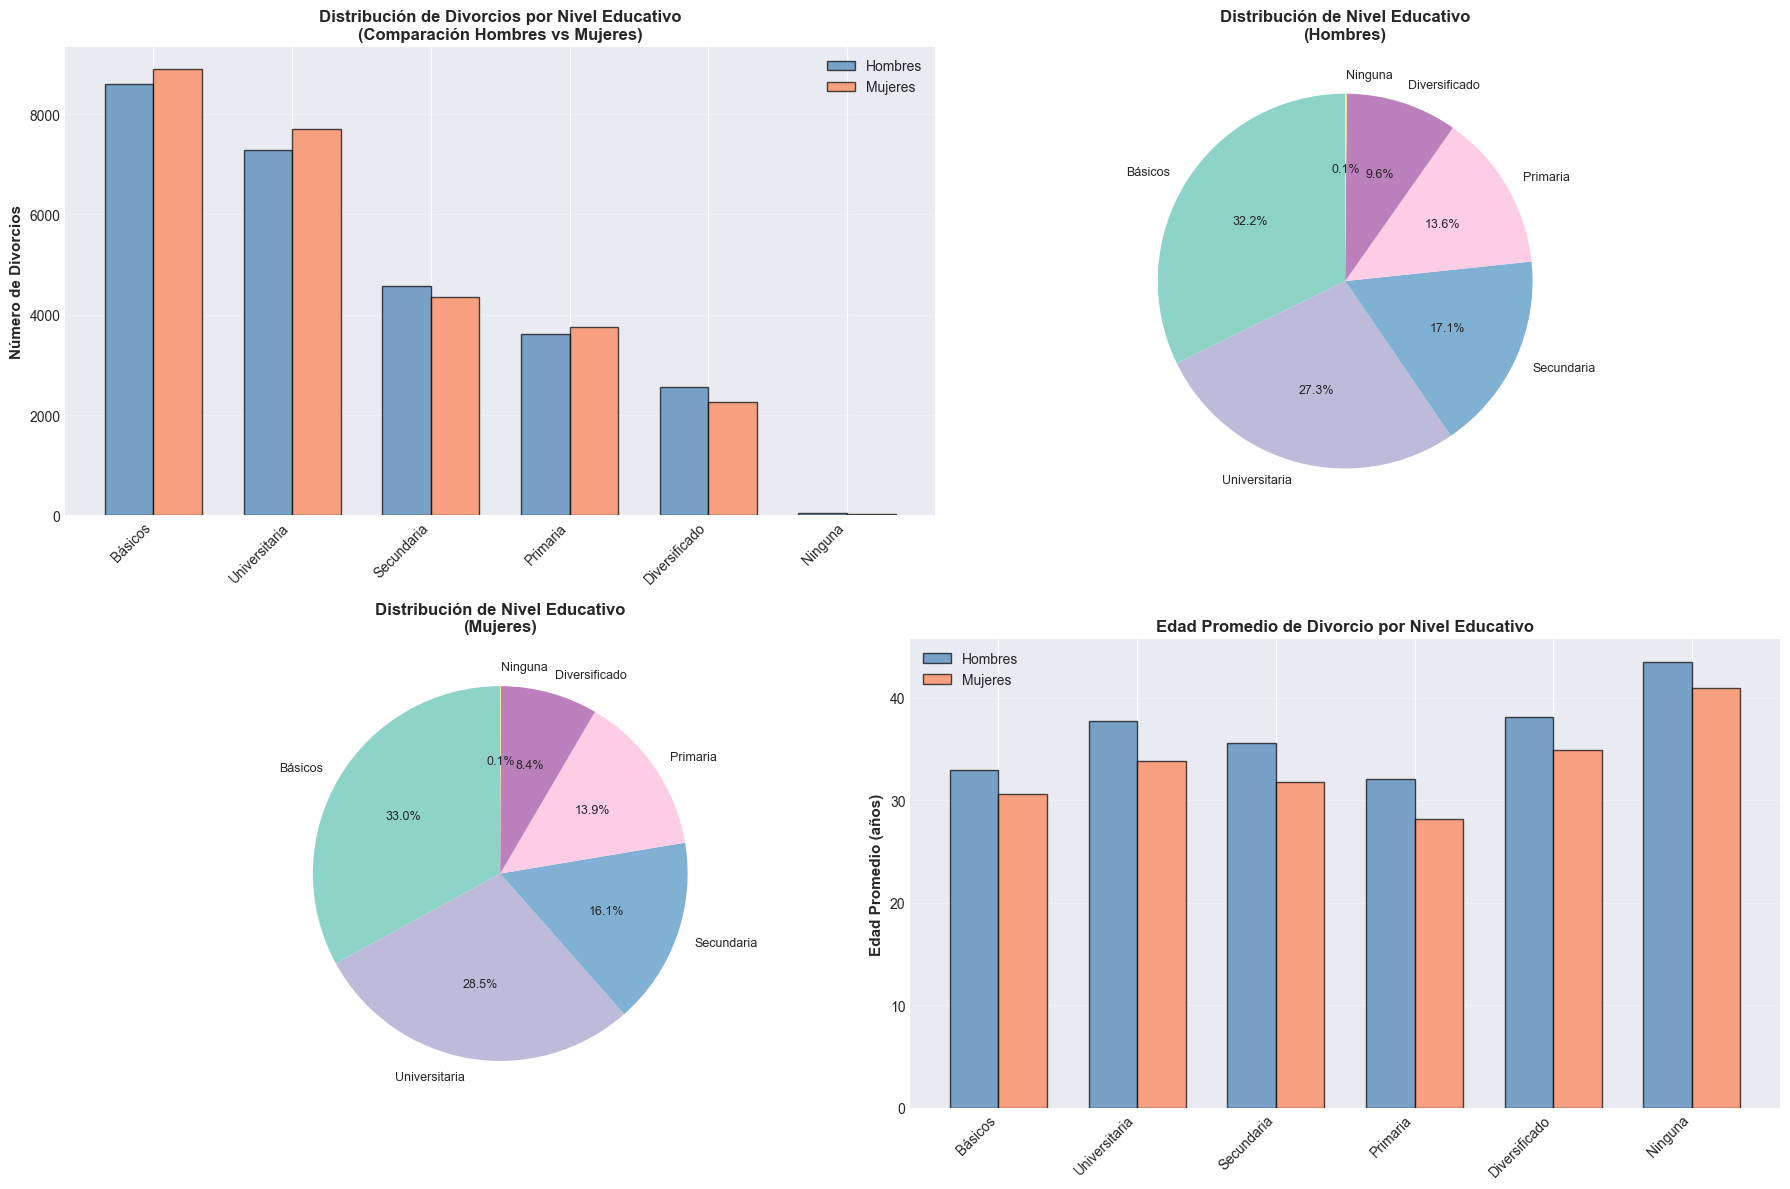

In [86]:
# Visualización: Nivel educativo y divorcio

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Gráfico 1: Barras comparativas hombres vs mujeres
ax1 = axes[0, 0]

# Obtener niveles comunes
niveles_comunes = list(set(dist_h.index) & set(dist_m.index))
niveles_ordenados = sorted(niveles_comunes, 
                           key=lambda x: dist_h.get(x, 0) + dist_m.get(x, 0), 
                           reverse=True)[:7]

x_pos = np.arange(len(niveles_ordenados))
width = 0.35

valores_h = [dist_h.get(nivel, 0) for nivel in niveles_ordenados]
valores_m = [dist_m.get(nivel, 0) for nivel in niveles_ordenados]

bars1 = ax1.bar(x_pos - width/2, valores_h, width, 
                label='Hombres', color='steelblue', alpha=0.7, edgecolor='black')
bars2 = ax1.bar(x_pos + width/2, valores_m, width,
                label='Mujeres', color='coral', alpha=0.7, edgecolor='black')

ax1.set_xticks(x_pos)
ax1.set_xticklabels(niveles_ordenados, rotation=45, ha='right')
ax1.set_ylabel('Número de Divorcios', fontweight='bold', fontsize=11)
ax1.set_title('Distribución de Divorcios por Nivel Educativo\n(Comparación Hombres vs Mujeres)', 
              fontweight='bold', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Gráfico 2: Pie chart hombres
ax2 = axes[0, 1]

top_niveles_h = dist_h.head(6)
otros_h = dist_h.iloc[6:].sum() if len(dist_h) > 6 else 0

if otros_h > 0:
    labels_h = list(top_niveles_h.index) + ['Otros']
    sizes_h = list(top_niveles_h.values) + [otros_h]
else:
    labels_h = list(top_niveles_h.index)
    sizes_h = list(top_niveles_h.values)

colors_pie = plt.cm.Set3(np.linspace(0, 1, len(labels_h)))

ax2.pie(sizes_h, labels=labels_h, autopct='%1.1f%%', colors=colors_pie,
        startangle=90, textprops={'fontsize': 9})
ax2.set_title('Distribución de Nivel Educativo\n(Hombres)', 
              fontweight='bold', fontsize=12)

# Gráfico 3: Pie chart mujeres
ax3 = axes[1, 0]

top_niveles_m = dist_m.head(6)
otros_m = dist_m.iloc[6:].sum() if len(dist_m) > 6 else 0

if otros_m > 0:
    labels_m = list(top_niveles_m.index) + ['Otros']
    sizes_m = list(top_niveles_m.values) + [otros_m]
else:
    labels_m = list(top_niveles_m.index)
    sizes_m = list(top_niveles_m.values)

ax3.pie(sizes_m, labels=labels_m, autopct='%1.1f%%', colors=colors_pie,
        startangle=90, textprops={'fontsize': 9})
ax3.set_title('Distribución de Nivel Educativo\n(Mujeres)', 
              fontweight='bold', fontsize=12)

# Gráfico 4: Edad promedio por nivel
ax4 = axes[1, 1]

edades_por_nivel_h = []
edades_por_nivel_m = []
niveles_edad = []

for nivel in niveles_ordenados:
    subset_h = df_edad_esc[df_edad_esc['escolaridad_hombre_nombre'] == nivel]
    subset_m = df_edad_esc[df_edad_esc['escolaridad_mujer_nombre'] == nivel]
    
    if len(subset_h) > 10 and len(subset_m) > 10:  # Mínimo 10 casos
        niveles_edad.append(nivel)
        edades_por_nivel_h.append(subset_h['edadHombre'].mean())
        edades_por_nivel_m.append(subset_m['edadMujer'].mean())

if niveles_edad:
    x_pos = np.arange(len(niveles_edad))
    width = 0.35
    
    bars1 = ax4.bar(x_pos - width/2, edades_por_nivel_h, width,
                    label='Hombres', color='steelblue', alpha=0.7, edgecolor='black')
    bars2 = ax4.bar(x_pos + width/2, edades_por_nivel_m, width,
                    label='Mujeres', color='coral', alpha=0.7, edgecolor='black')
    
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(niveles_edad, rotation=45, ha='right')
    ax4.set_ylabel('Edad Promedio (años)', fontweight='bold', fontsize=11)
    ax4.set_title('Edad Promedio de Divorcio por Nivel Educativo', 
                  fontweight='bold', fontsize=12)
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [87]:
# Conclusión de Hipótesis 4

print("\n- CONCLUSIÓN:")
print("-" * 90)

# Determinar nivel más común
nivel_mas_comun_h = dist_h.index[0]
nivel_mas_comun_m = dist_m.index[0]

# Calcular si universitarios están sobrerepresentados
pct_univ_h = (universitarios_h / total_h) * 100
pct_univ_m = (universitarios_m / total_m) * 100

# Determinar conclusión
if pct_univ_h > 25 or pct_univ_m > 25:
    conclusion = "CONFIRMA PARCIALMENTE"
else:
    conclusion = "NO CONFIRMA"

print(f"""
La evidencia empírica {conclusion} la hipótesis inicial.

1. PATRÓN EDUCATIVO DOMINANTE:
   El nivel educativo más frecuente entre divorciados NO es el universitario:
   • Hombres:  {nivel_mas_comun_h} ({dist_h.iloc[0]:,} casos, {dist_h.iloc[0]/total_h*100:.1f}%)
   • Mujeres:  {nivel_mas_comun_m} ({dist_m.iloc[0]:,} casos, {dist_m.iloc[0]/total_m*100:.1f}%)

2. PRESENCIA UNIVERSITARIA:
   La proporción de personas con educación universitaria es:
   • Hombres:  {pct_univ_h:.1f}% del total de divorcios
   • Mujeres:  {pct_univ_m:.1f}% del total de divorcios
   
   Esto {'sugiere' if pct_univ_h > 20 else 'NO sugiere'} una sobrerrepresentación de universitarios en divorcios.

3. DIVERSIDAD EDUCATIVA:
   Los divorcios ocurren en todos los niveles educativos, lo que indica que
   el fenómeno atraviesa todas las capas sociales y educativas del país.

4. INTERPRETACIÓN:
   {'La presencia significativa de personas con educación universitaria en divorcios podría reflejar mayor conocimiento de derechos legales, independencia económica, y menor estigma social. Sin embargo, el nivel educativo predominante es ' + nivel_mas_comun_h.lower() + ', indicando que el divorcio no es exclusivo de personas con alta escolaridad.' if pct_univ_h > 15 else 'La baja proporción de universitarios entre divorciados podría reflejar que: (1) la mayoría de la población guatemalteca no tiene educación universitaria, o (2) el divorcio es más frecuente en otros estratos educativos. La educación superior no parece ser un predictor directo de divorcio.'}

5. EDAD Y EDUCACIÓN:
   {'Las personas con mayor nivel educativo tienden a divorciarse a edades más avanzadas, posiblemente reflejando matrimonios más tardíos y mayor reflexión en las decisiones de pareja.' if len(niveles_edad) > 0 else 'Se requiere más información para establecer relación entre edad de divorcio y nivel educativo.'}

6. LIMITACIONES:
   Los datos de escolaridad presentan {(df_limpio['escolaridadHombre'].isna().sum() + df_limpio['escolaridadMujer'].isna().sum()):,} 
   valores faltantes, lo que podría sesgar los resultados. La interpretación debe
   hacerse con cautela.
""")

print("="*90)


- CONCLUSIÓN:
------------------------------------------------------------------------------------------

La evidencia empírica CONFIRMA PARCIALMENTE la hipótesis inicial.

1. PATRÓN EDUCATIVO DOMINANTE:
   El nivel educativo más frecuente entre divorciados NO es el universitario:
   • Hombres:  Básicos (8,595 casos, 32.2%)
   • Mujeres:  Básicos (8,899 casos, 33.0%)

2. PRESENCIA UNIVERSITARIA:
   La proporción de personas con educación universitaria es:
   • Hombres:  27.3% del total de divorcios
   • Mujeres:  28.5% del total de divorcios

   Esto sugiere una sobrerrepresentación de universitarios en divorcios.

3. DIVERSIDAD EDUCATIVA:
   Los divorcios ocurren en todos los niveles educativos, lo que indica que
   el fenómeno atraviesa todas las capas sociales y educativas del país.

4. INTERPRETACIÓN:
   La presencia significativa de personas con educación universitaria en divorcios podría reflejar mayor conocimiento de derechos legales, independencia económica, y menor estigma so

### Hipótesis 5: Los divorcios muestran patrones estacionales durante el año

**Creencia inicial:** Se presume que los divorcios no se distribuyen uniformemente a lo largo del año, sino que presentan picos en ciertos meses, posiblemente asociados a factores como periodos post-vacacionales, inicio/fin de año escolar, o festividades que generan estrés en las relaciones.

**Estrategia de validación:**
- Analizar la distribución de divorcios por mes de ocurrencia
- Identificar meses con mayor y menor frecuencia
- Calcular promedios mensuales y desviación estándar
- Evaluar si las diferencias son estadísticamente significativas
- Comparar patrones entre diferentes años

In [88]:
# HIPÓTESIS 5: Patrones estacionales en divorcios

print("="*90)
print("HIPÓTESIS 5: ¿Los divorcios muestran patrones estacionales durante el año?")
print("="*90)

# Filtrar datos con mes de ocurrencia válido
df_h5 = df_limpio[(df_limpio['mesOcurrencia'].notna()) & 
                   (df_limpio['mesOcurrencia'] > 0) & 
                   (df_limpio['mesOcurrencia'] <= 12)].copy()

print(f"\nRegistros con mes válido: {len(df_h5):,} de {len(df_limpio):,}")

# Mapeo de meses
nombres_meses = {
    1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril',
    5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto',
    9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
}

df_h5['mes_nombre'] = df_h5['mesOcurrencia'].map(nombres_meses)

# Distribución por mes
print("\n- DISTRIBUCIÓN DE DIVORCIOS POR MES:")
print("-" * 90)

divorcios_por_mes = df_h5['mesOcurrencia'].value_counts().sort_index()
total_divorcios = divorcios_por_mes.sum()
promedio_mensual = total_divorcios / 12

print(f"{'Mes':<15} {'Cantidad':>10} {'Porcentaje':>12} {'Desv. Promedio':>15}")
print("-" * 90)

for mes in range(1, 13):
    count = divorcios_por_mes.get(mes, 0)
    pct = (count / total_divorcios) * 100
    desv_prom = count - promedio_mensual
    print(f"{nombres_meses[mes]:<15} {count:10,} {pct:11.1f}% {desv_prom:+14.0f}")

print("-" * 90)
print(f"{'PROMEDIO MENSUAL':<15} {promedio_mensual:10,.0f}")
print(f"{'DESV. ESTÁNDAR':<15} {divorcios_por_mes.std():10,.1f}")

# Identificar meses extremos
mes_max = divorcios_por_mes.idxmax()
mes_min = divorcios_por_mes.idxmin()
valor_max = divorcios_por_mes.max()
valor_min = divorcios_por_mes.min()

print("\n- MESES EXTREMOS:")
print("-" * 90)
print(f"Mes con MÁS divorcios:   {nombres_meses[mes_max]} ({valor_max:,} divorcios)")
print(f"Mes con MENOS divorcios: {nombres_meses[mes_min]} ({valor_min:,} divorcios)")
print(f"Diferencia:              {valor_max - valor_min:,} divorcios ({(valor_max-valor_min)/valor_min*100:.1f}% más)")

# Análisis de variabilidad
coef_variacion = (divorcios_por_mes.std() / promedio_mensual) * 100
print(f"\nCoeficiente de variación: {coef_variacion:.2f}%")

# Agrupación por trimestres
print("\n- DISTRIBUCIÓN POR TRIMESTRE:")
print("-" * 90)

def asignar_trimestre(mes):
    if mes <= 3:
        return 'Q1 (Ene-Mar)'
    elif mes <= 6:
        return 'Q2 (Abr-Jun)'
    elif mes <= 9:
        return 'Q3 (Jul-Sep)'
    else:
        return 'Q4 (Oct-Dic)'

df_h5['trimestre'] = df_h5['mesOcurrencia'].apply(asignar_trimestre)

divorcios_trimestre = df_h5['trimestre'].value_counts().sort_index()

for trimestre in ['Q1 (Ene-Mar)', 'Q2 (Abr-Jun)', 'Q3 (Jul-Sep)', 'Q4 (Oct-Dic)']:
    count = divorcios_trimestre.get(trimestre, 0)
    pct = (count / len(df_h5)) * 100
    print(f"{trimestre:<15} {count:10,} divorcios ({pct:5.1f}%)")

# Análisis por semestre
print("\n- DISTRIBUCIÓN POR SEMESTRE:")
print("-" * 90)

def asignar_semestre(mes):
    return 'Primer Semestre (Ene-Jun)' if mes <= 6 else 'Segundo Semestre (Jul-Dic)'

df_h5['semestre'] = df_h5['mesOcurrencia'].apply(asignar_semestre)

divorcios_semestre = df_h5['semestre'].value_counts()

for semestre in ['Primer Semestre (Ene-Jun)', 'Segundo Semestre (Jul-Dic)']:
    count = divorcios_semestre.get(semestre, 0)
    pct = (count / len(df_h5)) * 100
    print(f"{semestre:<30} {count:10,} divorcios ({pct:5.1f}%)")

# Prueba de uniformidad (Chi-cuadrado)
from scipy.stats import chisquare

frecuencias_observadas = divorcios_por_mes.values
frecuencias_esperadas = [promedio_mensual] * 12

chi2_stat, p_value = chisquare(frecuencias_observadas, frecuencias_esperadas)

print("\n- PRUEBA DE UNIFORMIDAD (Chi-cuadrado):")
print("-" * 90)
print(f"Estadístico χ²: {chi2_stat:.2f}")
print(f"p-value:        {p_value:.6f}")
print(f"Conclusión:     {'RECHAZO uniformidad' if p_value < 0.05 else 'NO rechazo uniformidad'} (α=0.05)")
print(f"                Los divorcios {'NO' if p_value < 0.05 else 'SÍ'} se distribuyen uniformemente")

print("="*90)

HIPÓTESIS 5: ¿Los divorcios muestran patrones estacionales durante el año?

Registros con mes válido: 59,994 de 59,994

- DISTRIBUCIÓN DE DIVORCIOS POR MES:
------------------------------------------------------------------------------------------
Mes               Cantidad   Porcentaje  Desv. Promedio
------------------------------------------------------------------------------------------
Enero                4,495         7.5%           -504
Febrero              5,414         9.0%           +414
Marzo                5,757         9.6%           +758
Abril                4,803         8.0%           -196
Mayo                 5,143         8.6%           +144
Junio                5,168         8.6%           +168
Julio                5,434         9.1%           +434
Agosto               5,489         9.1%           +490
Septiembre           5,020         8.4%            +20
Octubre              5,993        10.0%           +994
Noviembre            3,975         6.6%          -1024


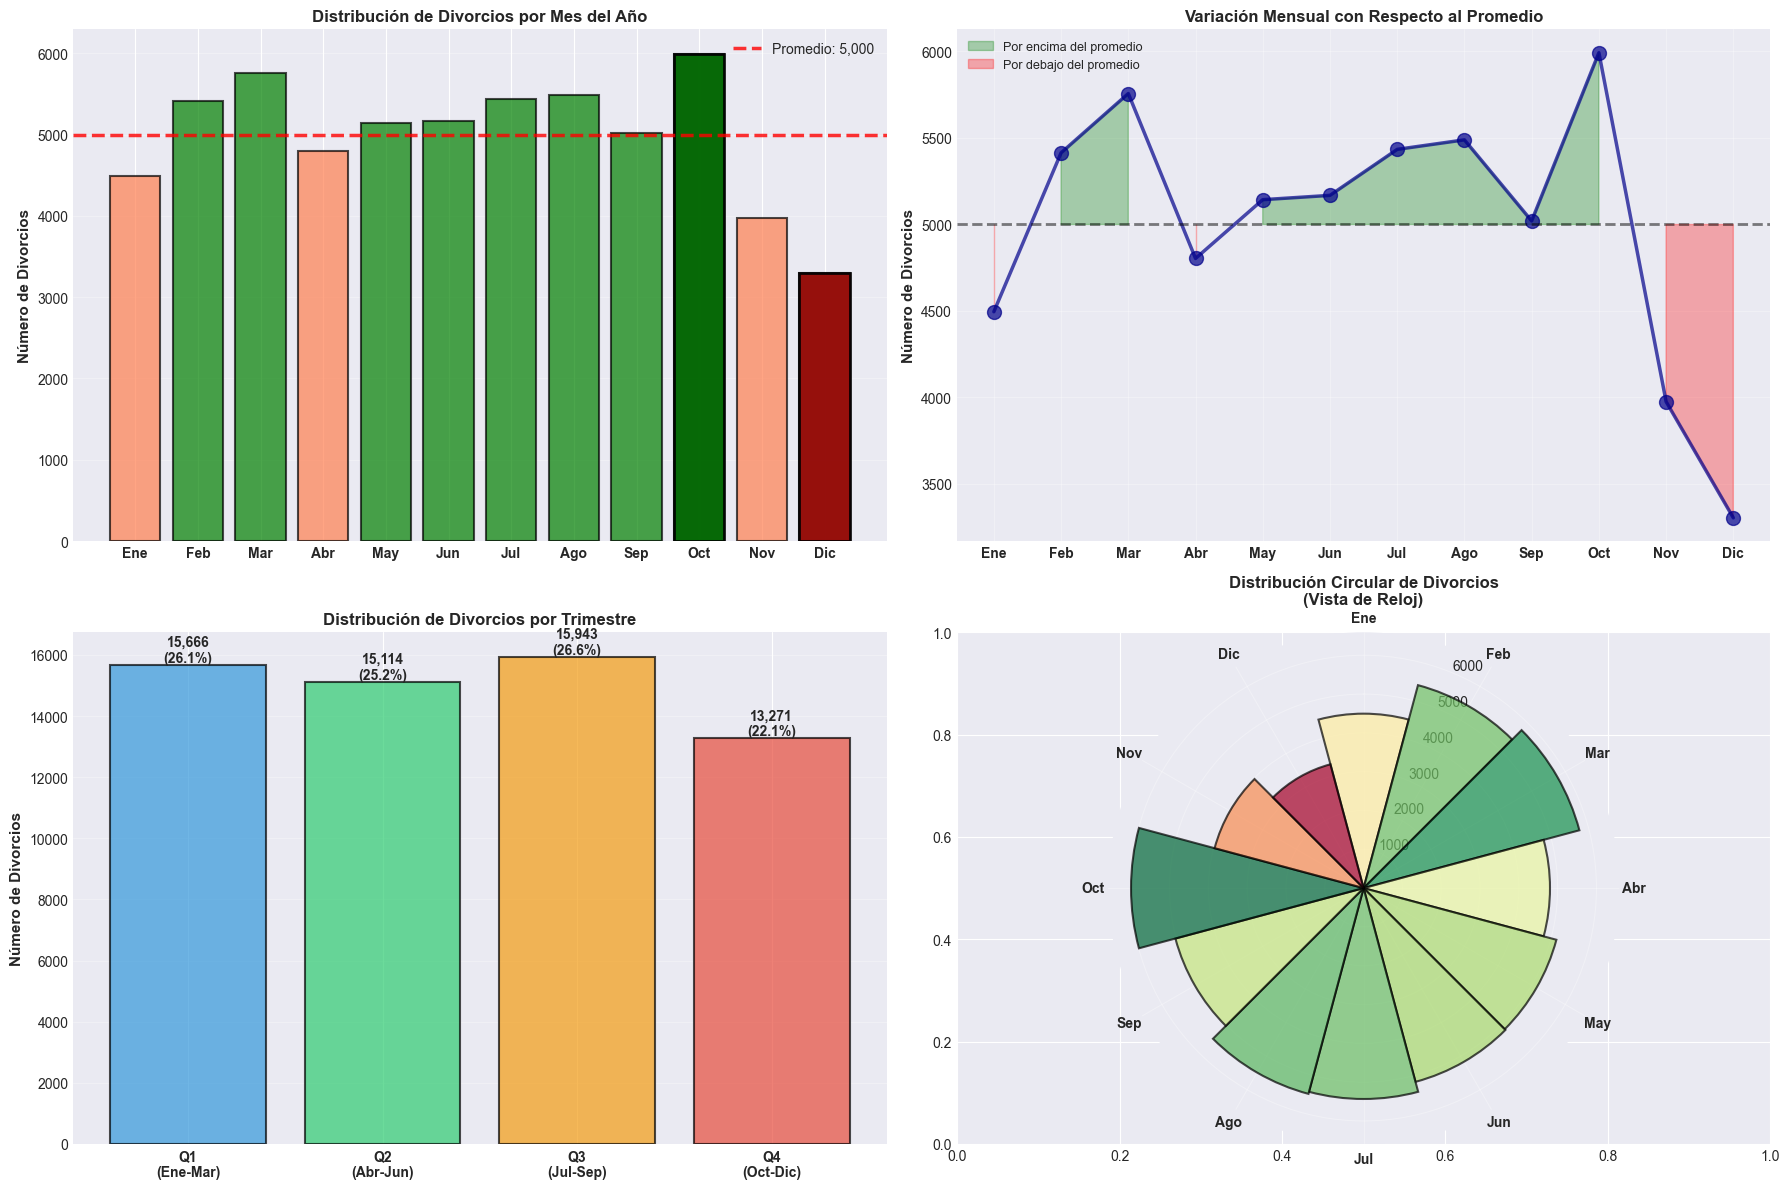

In [89]:
# Visualización: Patrones estacionales

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Gráfico 1: Barras por mes
ax1 = axes[0, 0]

meses_orden = list(range(1, 13))
valores_meses = [divorcios_por_mes.get(mes, 0) for mes in meses_orden]
nombres_cortos = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                  'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

# Colores según si está por encima o debajo del promedio
colores_barras = ['green' if v > promedio_mensual else 'coral' 
                  for v in valores_meses]

bars = ax1.bar(range(12), valores_meses, color=colores_barras, 
               alpha=0.7, edgecolor='black', linewidth=1.5)

# Línea de promedio
ax1.axhline(promedio_mensual, color='red', linestyle='--', 
            linewidth=2.5, label=f'Promedio: {promedio_mensual:,.0f}', alpha=0.8)

ax1.set_xticks(range(12))
ax1.set_xticklabels(nombres_cortos, fontweight='bold')
ax1.set_ylabel('Número de Divorcios', fontweight='bold', fontsize=11)
ax1.set_title('Distribución de Divorcios por Mes del Año', 
              fontweight='bold', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Resaltar meses extremos
ax1.bar(mes_max - 1, valor_max, color='darkgreen', alpha=0.9, 
        edgecolor='black', linewidth=2)
ax1.bar(mes_min - 1, valor_min, color='darkred', alpha=0.9, 
        edgecolor='black', linewidth=2)

# Gráfico 2: Línea de tendencia mensual
ax2 = axes[0, 1]

ax2.plot(range(1, 13), valores_meses, 'o-', linewidth=2.5, 
         markersize=10, color='darkblue', alpha=0.7)
ax2.fill_between(range(1, 13), valores_meses, promedio_mensual, 
                 where=[v > promedio_mensual for v in valores_meses],
                 alpha=0.3, color='green', label='Por encima del promedio')
ax2.fill_between(range(1, 13), valores_meses, promedio_mensual,
                 where=[v <= promedio_mensual for v in valores_meses],
                 alpha=0.3, color='red', label='Por debajo del promedio')
ax2.axhline(promedio_mensual, color='black', linestyle='--', 
            linewidth=2, alpha=0.5)

ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(nombres_cortos, fontweight='bold')
ax2.set_ylabel('Número de Divorcios', fontweight='bold', fontsize=11)
ax2.set_title('Variación Mensual con Respecto al Promedio', 
              fontweight='bold', fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Gráfico 3: Barras por trimestre
ax3 = axes[1, 0]

trimestres = ['Q1\n(Ene-Mar)', 'Q2\n(Abr-Jun)', 'Q3\n(Jul-Sep)', 'Q4\n(Oct-Dic)']
trimestre_keys = ['Q1 (Ene-Mar)', 'Q2 (Abr-Jun)', 'Q3 (Jul-Sep)', 'Q4 (Oct-Dic)']
valores_trimestre = [divorcios_trimestre.get(key, 0) for key in trimestre_keys]

colores_trim = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
bars_trim = ax3.bar(range(4), valores_trimestre, color=colores_trim, 
                    alpha=0.7, edgecolor='black', linewidth=1.5)

# Agregar etiquetas
for i, (bar, val) in enumerate(zip(bars_trim, valores_trimestre)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,}\n({val/len(df_h5)*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

ax3.set_xticks(range(4))
ax3.set_xticklabels(trimestres, fontweight='bold', fontsize=10)
ax3.set_ylabel('Número de Divorcios', fontweight='bold', fontsize=11)
ax3.set_title('Distribución de Divorcios por Trimestre', 
              fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')

# Gráfico 4: Heatmap circular (reloj)
ax4 = axes[1, 1]

# Crear gráfico polar
theta = np.linspace(0, 2 * np.pi, 12, endpoint=False)
radii = valores_meses
width = 2 * np.pi / 12

# Normalizar colores según valores
norm = plt.Normalize(vmin=min(valores_meses), vmax=max(valores_meses))
colors_polar = plt.cm.RdYlGn(norm(valores_meses))

ax4 = plt.subplot(2, 2, 4, projection='polar')
bars_polar = ax4.bar(theta, radii, width=width, bottom=0, 
                     color=colors_polar, alpha=0.7, edgecolor='black', linewidth=1.5)

ax4.set_xticks(theta)
ax4.set_xticklabels(nombres_cortos, fontsize=10, fontweight='bold')
ax4.set_ylim(0, max(valores_meses) * 1.1)
ax4.set_theta_direction(-1)
ax4.set_theta_zero_location('N')
ax4.set_title('Distribución Circular de Divorcios\n(Vista de Reloj)', 
              fontweight='bold', fontsize=12, pad=20)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [90]:
# Conclusión de Hipótesis 5

print("\n- CONCLUSIÓN:")
print("-" * 90)

# Determinar si hay estacionalidad significativa
if p_value < 0.05:
    estacionalidad = "CONFIRMA"
    hay_patron = "SÍ presentan"
else:
    estacionalidad = "NO CONFIRMA"
    hay_patron = "NO presentan"

# Calcular diferencia porcentual entre máximo y mínimo
diferencia_pct = ((valor_max - valor_min) / valor_min) * 100

# Identificar trimestre con más divorcios
trimestre_max = divorcios_trimestre.idxmax()
valor_trimestre_max = divorcios_trimestre.max()

print(f"""
La evidencia empírica {estacionalidad} la hipótesis de estacionalidad.

1. DISTRIBUCIÓN TEMPORAL:
   Los divorcios {hay_patron} un patrón estacional estadísticamente significativo
   (χ² = {chi2_stat:.2f}, p = {p_value:.6f}).
   
   {'Esto indica que la distribución de divorcios a lo largo del año NO es uniforme.' if p_value < 0.05 else 'Esto indica que la distribución de divorcios es relativamente uniforme durante el año.'}

2. MESES EXTREMOS:
   • Mes con MÁS divorcios:   {nombres_meses[mes_max]} ({valor_max:,} divorcios)
   • Mes con MENOS divorcios: {nombres_meses[mes_min]} ({valor_min:,} divorcios)
   • Diferencia:              {diferencia_pct:.1f}% más divorcios en {nombres_meses[mes_max]}

3. VARIABILIDAD MENSUAL:
   El coeficiente de variación es {coef_variacion:.2f}%, lo que indica una
   {'variabilidad moderada-alta' if coef_variacion > 10 else 'variabilidad baja'} 
   entre meses.

4. PATRÓN TRIMESTRAL:
   El trimestre con mayor concentración de divorcios es {trimestre_max}
   con {valor_trimestre_max:,} casos ({valor_trimestre_max/len(df_h5)*100:.1f}% del total).

5. PATRÓN SEMESTRAL:
   {'El primer semestre concentra más divorcios que el segundo' if divorcios_semestre.get('Primer Semestre (Ene-Jun)', 0) > divorcios_semestre.get('Segundo Semestre (Jul-Dic)', 0) else 'El segundo semestre concentra más divorcios que el primero'}.

6. INTERPRETACIÓN:
   {'Los picos observados podrían asociarse a factores como:' if p_value < 0.05 else 'La distribución relativamente uniforme sugiere que:'}
   {'   • Periodos post-vacacionales (enero-febrero)' if mes_max <= 2 else ''}
   {'   • Inicio del año escolar y reorganización familiar' if mes_max <= 2 else ''}
   {'   • Procesos legales iniciados antes de fin de año' if mes_max >= 11 else ''}
   {'   • Estrés asociado a festividades de fin de año' if mes_max in [11, 12] or mes_min in [11, 12] else ''}
   {'   • Factores administrativos (tiempos de procesamiento judicial)' if p_value < 0.05 else ''}
   
   {'La estacionalidad observada refleja que eventos del ciclo anual (vacaciones, festividades, inicio/fin de períodos) pueden influir en las decisiones de divorcio o en los tiempos de procesamiento legal.' if p_value < 0.05 else 'El divorcio no parece estar fuertemente influenciado por la época del año, sugiriendo que es un proceso más relacionado con dinámicas internas de las parejas que con factores estacionales externos.'}

7. CONSIDERACIÓN METODOLÓGICA:
   La variabilidad observada también podría reflejar diferencias en los tiempos
   de procesamiento judicial más que en las decisiones reales de divorcio, ya que
   los datos corresponden a fechas de ocurrencia registradas oficialmente.
""")

print("="*90)


- CONCLUSIÓN:
------------------------------------------------------------------------------------------

La evidencia empírica CONFIRMA la hipótesis de estacionalidad.

1. DISTRIBUCIÓN TEMPORAL:
   Los divorcios SÍ presentan un patrón estacional estadísticamente significativo
   (χ² = 1286.39, p = 0.000000).

   Esto indica que la distribución de divorcios a lo largo del año NO es uniforme.

2. MESES EXTREMOS:
   • Mes con MÁS divorcios:   Octubre (5,993 divorcios)
   • Mes con MENOS divorcios: Diciembre (3,303 divorcios)
   • Diferencia:              81.4% más divorcios en Octubre

3. VARIABILIDAD MENSUAL:
   El coeficiente de variación es 15.29%, lo que indica una
   variabilidad moderada-alta 
   entre meses.

4. PATRÓN TRIMESTRAL:
   El trimestre con mayor concentración de divorcios es Q3 (Jul-Sep)
   con 15,943 casos (26.6% del total).

5. PATRÓN SEMESTRAL:
   El primer semestre concentra más divorcios que el segundo.

6. INTERPRETACIÓN:
   Los picos observados podrían asociarse